<a href="https://colab.research.google.com/github/LeograndeCode/Neural-Highlighting-of-Affordance-Regions/blob/Parte-3/Notebook3D_AffordanceNet_v4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive') #replace with drive.mount('/content/drive/', force_remount=True) if the drive has changed since last mount in order to force the remount
%cd /content/drive/MyDrive/Neural-Highlighting-of-Affordance-Regions/


Mounted at /content/drive
/content/drive/MyDrive/Neural-Highlighting-of-Affordance-Regions


In [2]:
!apt-get update
!apt-get install -y xvfb ffmpeg libsm6 libxext6
!pip install git+https://github.com/openai/CLIP.git
!pip install kaolin==0.17.0 -f https://nvidia-kaolin.s3.us-east-2.amazonaws.com/torch-2.5.1_cu121.html
!pip install open3d pyvirtualdisplay

Get:1 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease [3,626 B]
Get:2 http://security.ubuntu.com/ubuntu jammy-security InRelease [129 kB]
Hit:3 http://archive.ubuntu.com/ubuntu jammy InRelease
Get:4 https://r2u.stat.illinois.edu/ubuntu jammy InRelease [6,555 B]
Get:5 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [128 kB]
Get:6 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease [1,581 B]
Hit:7 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Get:8 https://r2u.stat.illinois.edu/ubuntu jammy/main amd64 Packages [2,639 kB]
Hit:9 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Get:10 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  Packages [1,199 kB]
Get:11 http://archive.ubuntu.com/ubuntu jammy-backports InRelease [127 kB]
Hit:12 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease
Get:13 http://security.ubuntu.com/ubuntu jammy-s

###AffordanceNet Class

AffordanceNet Class modified with capability of choosing only some objects, in our case household objects with hand-object affordances



In [3]:
import os
from os.path import join as opj
import numpy as np
from torch.utils.data import Dataset
import h5py
import json
import pickle as pkl

def pc_normalize(pc):
    centroid = np.mean(pc, axis=0)
    pc = pc - centroid
    m = np.max(np.sqrt(np.sum(pc**2, axis=1)))
    pc = pc / m
    return pc, centroid, m


class AffordNetDataset(Dataset):
    def __init__(self, data_dir):
        super().__init__()
        self.data_dir = data_dir
        self.semantic_class = 'Mug'
        self.label_name = 'grasp'
        self.load_data()
        return

    def load_data(self):
        self.all_data = []

        # Open the dataset file
        with open('full_shape_train_data.pkl', 'rb') as f:
            data = pkl.load(f)


        # Check if the data is a list
        if isinstance(data, list):
            # Filter the point clouds based on the 'semantic class' attribute
            point_clouds = [
                pc for pc in data
                if pc.get('semantic class') == self.semantic_class
            ]
        print(f"Number of point clouds with 'semantic class' equal to {self.semantic_class}: {len(point_clouds)}")

        self.all_data = point_clouds

    def __getitem__(self, index):
        data_dict = self.all_data[index]

        coordinates = np.array(data_dict['full_shape']['coordinate'])
        label = np.array(data_dict['full_shape']['label'][self.label_name])

        data, _, _ = pc_normalize(coordinates)

        return data, label

    def __len__(self):
        return len(self.all_data)


### Model

In [15]:
import clip
import copy
import json
import kaolin as kal
import kaolin.ops.mesh
import numpy as np
import os
import random
import torch
import torch.nn as nn
import torchvision
from torchvision import transforms
import torchvision.transforms.functional as F

from itertools import permutations, product
from Normalization import MeshNormalizer
from render import Renderer
from mesh import Mesh
from pathlib import Path
from tqdm import tqdm
from torch.autograd import grad
from torchvision import transforms
from utils import device, color_mesh
import open3d as o3d
from pyvirtualdisplay import Display
from pytorch3d.io import IO

# Pytorch3D install
import sys
pyt_version_str=torch.__version__.split("+")[0].replace(".", "")
version_str="".join([
    f"py3{sys.version_info.minor}_cu",
    torch.version.cuda.replace(".",""),
    f"_pyt{pyt_version_str}"
])
!pip install iopath
!pip install --no-index --no-cache-dir pytorch3d -f https://dl.fbaipublicfiles.com/pytorch3d/packaging/wheels/{version_str}/download.html


# Data structures and functions for rendering
from pytorch3d.structures import Meshes, Pointclouds
from pytorch3d.vis.plotly_vis import AxisArgs, plot_batch_individually, plot_scene
from pytorch3d.renderer import (
    look_at_view_transform,
    FoVOrthographicCameras,
    PointsRasterizationSettings,
    PointsRenderer,
    PulsarPointsRenderer,
    PointsRasterizer,
    AlphaCompositor,
    NormWeightedCompositor
)
from pytorch3d.io import load_objs_as_meshes, save_ply

width = 256
depth = 4       #default is 4
out_dim = 2
input_dim = 3
n_augs = 1      #default is 1

class NeuralHighlighter(nn.Module):
    def __init__(self):
        super(NeuralHighlighter, self).__init__()
        input_size = 3 #Dimension of the vertex
        output_size = 2 #Dimension of the output
                        #for the standard highlighter task there are only 2 classes: target region and not target region.
                        #we use the element of the output vector corresponding to the probability of belonging to the target
                        #region as the highlight probability described in the main paper.
        layers = []

        #See Appendix B (page 13)
        #first linear layer followed by ReLU and LayerNorm
        layers.append(nn.Linear(input_dim, width))
        layers.append(nn.ReLU())
        layers.append(nn.LayerNorm([width]))
        #other [depth] linear layers followed by ReLU and LayerNorm
        # -> changing the depth hyperparameter results in a deeper/shallower net
        # -> total depth (in terms of modules[Linear+ReLU+LayerNorm]) = [depth] + 1
        for i in range(depth):
            layers.append(nn.Linear(width, width))
            layers.append(nn.ReLU())
            layers.append(nn.LayerNorm([width]))
        #last linear layer followed by softmax in order to output probability-like values
        layers.append(nn.Linear(width, out_dim))
        layers.append(nn.Softmax(dim=1))

        self.mlp = nn.ModuleList(layers)
        self.model = self.mlp
        print(self.mlp)

    def forward(self, x):
        for layer in self.model:
            x = layer(x)
        return x

def get_clip_model(clipmodel):
    model, preprocess = clip.load(clipmodel, device=device)
    return model, preprocess

# ================== HELPER FUNCTIONS =============================
def save_final_results(log_dir, name, mesh, mlp, vertices, colors, render, background):
    mlp.eval()
    with torch.no_grad():
        probs = mlp(vertices)
        max_idx = torch.argmax(probs, 1, keepdim=True)
        # for renders
        one_hot = torch.zeros(probs.shape).to(device)
        one_hot = one_hot.scatter_(1, max_idx, 1)
        sampled_mesh = mesh

        highlight = torch.tensor([204, 255, 0]).to(device)
        gray = torch.tensor([180, 180, 180]).to(device)
        colors = torch.stack((highlight/255, gray/255)).to(device)
        color_mesh(one_hot, sampled_mesh, colors)
        rendered_images, _, _ = render.render_views(sampled_mesh, num_views=5,
                                                                        show=False,
                                                                        center_azim=0,
                                                                        center_elev=0,
                                                                        std=1,
                                                                        return_views=True,
                                                                        lighting=True,
                                                                        background=background)
        # for mesh
        final_color = torch.zeros(vertices.shape[0], 3).to(device)
        final_color = torch.where(max_idx==0, highlight, gray)
        mesh.export(os.path.join(log_dir, f"{name}.ply"), extension="ply", color=final_color)
        save_renders(log_dir, 0, rendered_images, name='final_render.jpg')

#TODO: fix the generation of the point cloud subsequently
#      now the point cloud generation is possible only by executing the PC_rendering.ipynb

def save_point_cloud_results(log_dir, name):
        #now i load the highlighted mesh and transpose it back to the point cloud
        display = Display(visible=0, size=(1400, 900))
        display.start()
        mesh_o3d = o3d.io.read_triangle_mesh(os.path.join(log_dir, f"{name}.ply"))

        if not mesh_o3d.has_vertex_normals():
          mesh_o3d.compute_vertex_normals()

        point_cloud = mesh_o3d.sample_points_poisson_disk(number_of_points=2048)

        width_final_render, height_final_render = 1400, 900
        render_final_pc = o3d.visualization.rendering.OffscreenRenderer(width_final_render, height_final_render)
        material = o3d.visualization.rendering.MaterialRecord()
        material.shader = "defaultUnlit"
        render_final_pc.scene.add_geometry("point_cloud", point_cloud, material)

        zoom_out_factor = 0.5
        bounding_box = point_cloud.get_axis_aligned_bounding_box()
        center = bounding_box.get_center()
        extent = bounding_box.get_extent()
        render_final_pc.scene.camera.look_at(center, center + [0, 0, 1], [0, 1, 0])
        render_final_pc.scene.camera.set_projection(60 / zoom_out_factor, width_final_render / height_final_render, 0.1, 100.0,
                                      o3d.visualization.rendering.Camera.FovType.Horizontal)

        pc_img = render_final_pc.render_to_image()
        output_file = os.path.join(log_dir, f"{name}_final_render.jpg")
        o3d.io.write_image(output_file, pc_img)
        display.stop()


def clip_loss(rendered_images, encoded_text, clip_transform, augment_transform, clip_model):
    if n_augs == 0:
        clip_image = clip_transform(rendered_images)
        encoded_renders = clip_model.encode_image(clip_image)
        encoded_renders = encoded_renders / encoded_renders.norm(dim=1, keepdim=True)
        if encoded_text.shape[0] > 1:
            loss = torch.cosine_similarity(torch.mean(encoded_renders, dim=0),
                                                torch.mean(encoded_text, dim=0), dim=0)
        else:
            loss = torch.cosine_similarity(torch.mean(encoded_renders, dim=0, keepdim=True),
                                                encoded_text)

    elif n_augs > 0:
        loss = 1.0 #original 0.0
        for _ in range(n_augs):
            augmented_image = augment_transform(rendered_images)
            encoded_renders = clip_model.encode_image(augmented_image)
            if encoded_text.shape[0] > 1:
                loss -= torch.cosine_similarity(torch.mean(encoded_renders, dim=0),
                                                    torch.mean(encoded_text, dim=0), dim=0)
            else:
                loss -= torch.cosine_similarity(torch.mean(encoded_renders, dim=0, keepdim=True),
                                                    encoded_text)
    return loss

def save_renders(dir, i, rendered_images, name=None):
    if name is not None:
        torchvision.utils.save_image(rendered_images, os.path.join(dir, name))
    else:
        torchvision.utils.save_image(rendered_images, os.path.join(dir, 'renders/iter_{}.jpg'.format(i)))

Looking in links: https://dl.fbaipublicfiles.com/pytorch3d/packaging/wheels/py310_cu121_pyt251/download.html


#Dataset

In [5]:
import open3d as o3d
import numpy as np
from sklearn.model_selection import train_test_split
from torch.utils.data import Subset, DataLoader
import torch  # If dataset uses PyTorch tensors

# Assuming AffordNetDataset is correctly initialized
data_dir = "."
dataset = AffordNetDataset(data_dir=data_dir)
print(len(dataset))
# Split dataset into test and validation indices
indexes = list(range(len(dataset)))
val_indexes, test_indexes = train_test_split(indexes, test_size=0.9, shuffle=True)

# Create Subsets
val_dataset = Subset(dataset, val_indexes)
test_dataset = Subset(dataset, test_indexes)

# DataLoaders
batch_size = 1  # Load one point cloud at a time for visualization
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=4)

# Check dataset sizes
print(f"Valid Dataset Size: {len(val_dataset)}")
print(f"Test Dataset Size: {len(test_dataset)}")


# Access a sample
point_cloud, affordance_labels = dataset[0]

print("Point Cloud Shape:", point_cloud.shape)
print("Affordance Labels Shape:", affordance_labels.shape)



Number of point clouds with 'semantic class' equal to Mug: 133
133
Valid Dataset Size: 13
Test Dataset Size: 120
Point Cloud Shape: (2048, 3)
Affordance Labels Shape: (2048, 1)


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


#Training


In [48]:
def assign_colors(pred_class, colors, device):
    """
    Assign colors to points based on their probabilities.

    Args:
        pred_class (torch.Tensor): Tensor of shape [N, 2], where each row contains
                                   [p_highlighted, p_not_highlighted].
        colors (torch.Tensor): Tensor of shape [2, 3], where the first row is "highlighter" color
                               and the second row is "gray" color.
        device (torch.device): Device to which the tensors are moved (e.g., "cpu" or "cuda").

    Returns:
        torch.Tensor: A tensor of shape [N, 3] containing the RGB colors for each point.
    """
    # Ensure the probabilities are normalized (if not already)
    # pred_class = pred_class / pred_class.sum(dim=1, keepdim=True)

    # Extract probabilities for highlighter and gray
    p_highlighter = pred_class[:, 0].unsqueeze(1)  # Shape: [N, 1]
    p_gray = pred_class[:, 1].unsqueeze(1)         # Shape: [N, 1]



    # Compute weighted colors
    colors_highlighter = colors[0].unsqueeze(0)  # Shape: [1, 3]
    colors_gray = colors[1].unsqueeze(0)        # Shape: [1, 3]


    # Weighted sum of the colors based on probabilities
    point_colors = p_highlighter * colors_highlighter + p_gray * colors_gray  # Shape: [N, 3]

    return point_colors.to(device)

Rendering Example


torch.Size([1, 3, 224, 224])


TypeError: can't convert cuda:0 device type tensor to numpy. Use Tensor.cpu() to copy the tensor to host memory first.

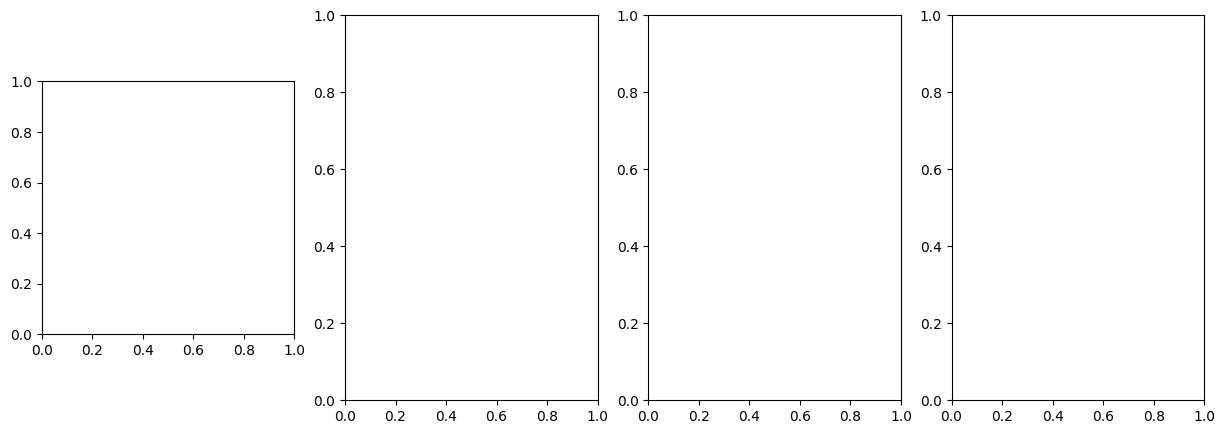

In [50]:
import matplotlib.pyplot as plt


obj_path = 'data/dog.obj'

device = "cuda" if torch.cuda.is_available() else "cpu"

#Path(os.path.join(output_dir, 'renders')).mkdir(parents=True, exist_ok=True)

objbase, extension = os.path.splitext(os.path.basename(obj_path))

# list of possible colors
rgb_to_color = {(204/255, 1., 0.): "highlighter", (180/255, 180/255, 180/255): "gray"}
color_to_rgb = {"highlighter": [204/255, 1., 0.], "gray": [180/255, 180/255, 180/255]}
full_colors = [[204/255, 1., 0.], [180/255, 180/255, 180/255]]
colors = torch.tensor(full_colors).to(device)

#------------ MESH TO POINT CLOUD INIT---------------
from pyvirtualdisplay import Display
display = Display(visible=0, size=(1400, 900))
display.start()

#here we retrieve first the point cloud from the mesh (only for test purpose)
mesh_o3d = o3d.io.read_triangle_mesh(obj_path)
mesh_o3d.compute_vertex_normals()
pcd = mesh_o3d.sample_points_poisson_disk(2048)
o3d.io.write_point_cloud("dog.pcd", pcd)
display.stop()
#------------ MESH TO POINT CLOUD END---------------

# Load the point cloud using Open3D
pcd = o3d.io.read_point_cloud("dog.pcd")

# Extract vertices and colors
points = torch.tensor(np.asarray(pcd.points), dtype=torch.float32, device = device)


# Create a tensor of gray colors for each point
gray_rgb = torch.tensor(color_to_rgb["gray"], dtype=torch.float32, device=device)  # Gray RGB value
gray_colors = gray_rgb.unsqueeze(0).repeat(points.shape[0], 1)  # Repeat gray for all points

# Assume points.shape[0] is the number of points (N)
N = points.shape[0]

# Generate random values for the (N, 2) tensor
#pred_class = torch.rand(N, 2)

if N % 2 != 0:
    raise ValueError("N must be an even number to split evenly into halves.")

# Create the tensor
half_N = N // 2
column1 = torch.cat((torch.zeros(half_N), torch.ones(half_N)))
column2 = torch.cat((torch.zeros(half_N), torch.ones(half_N)))

# Stack columns to form the final tensor
pred_class = torch.stack((column1, column2), dim=1)


# Normalize along the last dimension to ensure probabilities sum to 1
pred_class = pred_class / pred_class.sum(dim=1, keepdim=True)

#print("probabilites:", pred_class)

point_colors = assign_colors(pred_class.to(device), colors, device)

#print("Color tensor: ", point_colors)

# Create a PyTorch3D Pointclouds object
point_cloud = Pointclouds(points=[points], features=[point_colors])

# Define multiple camera views
num_views = 4
elevations = [10, 20, 30, 40]  # Example elevation angles
azimuths = [0, 90, 180, 270]   # Example azimuth angles
Rs, Ts = zip(*(look_at_view_transform(20, elev, azim) for elev, azim in zip(elevations, azimuths)))

# Initialize rasterizer and renderer
raster_settings = PointsRasterizationSettings(
    image_size=224,
    radius=0.003,
    points_per_pixel=10
)
# Initialize variables
background = torch.tensor((1., 1., 1.)).to(device)

# Render images from multiple views
rendered_images = []
for R, T in zip(Rs, Ts):
    # Create a new camera for the current view
    cameras = FoVOrthographicCameras(device=device, R=R, T=T, znear=0.01)

    # Initialize the renderer with the new camera
    renderer = PulsarPointsRenderer(
        rasterizer=PointsRasterizer(cameras=cameras, raster_settings=raster_settings),
        n_channels=3
    ).to(device)

    # Render the image for the current camera view
    image = renderer(
        point_cloud,
        gamma=(1e-4,),
        bg_col=background
    )
    rendered_images.append(image.permute(0,3,1,2))  # Extract RGB channels

print(rendered_images[0].shape)
import matplotlib.pyplot as plt

# Assuming rendered_images is a list of images (NumPy arrays)
num_images = len(rendered_images)

# Create a figure and axes for the combined image
fig, axes = plt.subplots(1, num_images, figsize=(15, 5))  # Adjust figsize as needed

# Iterate through the rendered images and display them on the subplots
for i, image in enumerate(rendered_images):
    axes[i].imshow(image)
    axes[i].axis('off')  # Turn off axis labels and ticks

# Display the combined image
plt.show()

In [60]:
from torch.optim.lr_scheduler import MultiStepLR
import matplotlib.pyplot as plt
# Constrain most sources of randomness
# (some torch backwards functions within CLIP are non-determinstic)
seed = 0
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
random.seed(seed)
np.random.seed(seed)
torch.backends.cudnn.benchmark = False
torch.backends.cudnn.deterministic = True

render_res = 224
learning_rate = 0.0001
n_iter = 2500
res = 224
obj_path = 'data/dog.obj'
#output_dir = './output/'
clip_model_name = 'ViT-B/32'

device = "cuda" if torch.cuda.is_available() else "cpu"

#Path(os.path.join(output_dir, 'renders')).mkdir(parents=True, exist_ok=True)

objbase, extension = os.path.splitext(os.path.basename(obj_path))

# list of possible colors
rgb_to_color = {(204/255, 1., 0.): "highlighter", (180/255, 180/255, 180/255): "gray"}
color_to_rgb = {"highlighter": [204/255, 1., 0.], "gray": [180/255, 180/255, 180/255]}
full_colors = [[204/255, 1., 0.], [180/255, 180/255, 180/255]]
colors = torch.tensor(full_colors).to(device)

#------------ MESH TO POINT CLOUD INIT---------------
from pyvirtualdisplay import Display
display = Display(visible=0, size=(1400, 900))
display.start()

#here we retrieve first the point cloud from the mesh (only for test purpose)
mesh_o3d = o3d.io.read_triangle_mesh(obj_path)
mesh_o3d.compute_vertex_normals()
pcd = mesh_o3d.sample_points_poisson_disk(2048)
o3d.io.write_point_cloud("dog.pcd", pcd)
display.stop()
#------------ MESH TO POINT CLOUD END---------------

# Load the point cloud using Open3D
pcd = o3d.io.read_point_cloud("dog.pcd")

# Extract vertices and colors
points = torch.tensor(np.asarray(pcd.points), dtype=torch.float32, device = device)


# Create a tensor of gray colors for each point
gray_rgb = torch.tensor(color_to_rgb["gray"], dtype=torch.float32, device=device)  # Gray RGB value
gray_colors = gray_rgb.unsqueeze(0).repeat(points.shape[0], 1)  # Repeat gray for all points

# Create a PyTorch3D Pointclouds object
point_cloud = Pointclouds(points=[points], features=[gray_colors])

# Define multiple camera views
num_views = 4
elevations = [10, 20, 30, 40]  # Example elevation angles
azimuths = [0, 90, 180, 270]   # Example azimuth angles
Rs, Ts = zip(*(look_at_view_transform(20, elev, azim) for elev, azim in zip(elevations, azimuths)))

# Initialize rasterizer and renderer
raster_settings = PointsRasterizationSettings(
    image_size=224,
    radius=0.003,
    points_per_pixel=10
)
# Initialize variables
background = torch.tensor((1., 1., 1.)).to(device)

# CLIP and Augmentation Transforms
clip_normalizer = transforms.Normalize((0.48145466, 0.4578275, 0.40821073), (0.26862954, 0.26130258, 0.27577711))

clip_transform = transforms.Compose([
        transforms.Resize((res, res)),
        clip_normalizer
])

augment_transform = transforms.Compose([
        transforms.RandomResizedCrop(res, scale=(1, 1)),
        transforms.RandomPerspective(fill=1, p=0.8, distortion_scale=0.5),
        clip_normalizer
])

# MLP Settings
mlp = NeuralHighlighter().to(device)
optim = torch.optim.Adam(mlp.parameters(), learning_rate)

#introducing learning rate decay
#with the prompt horse/saddle the loss plateaus
#scheduler = StepLR(optim, step_size=300, gamma=0.1)

#scheduler = MultiStepLR(optim, milestones=[300, 1800], gamma=0.1)  # Decay a epoch 300 e 1800

name = 'dogPC_d_{}_augs_{}'.format(depth, n_augs)

# --- Prompt ---
# encode prompt with CLIP
clip_model, preprocess = get_clip_model(clip_model_name)
#prompts = ['A 3D render of a gray horse with highlighted hat',
#           'A 3D render of a gray horse with highlighted shoes',
#           'A 3D render of a gray horse with highlighted saddle']
prompts = ['A 3D render of a point cloud of a gray dog with highlighted hat']

for i, prompt in enumerate(prompts):

  output_dir = './output_{}_{}/'.format(name, i)
  Path(os.path.join(output_dir, 'renders')).mkdir(parents=True, exist_ok=True)
  log_dir = output_dir

  #here we compute the text encoding only once
  #if we put it inside the loss, we repeat n_iter times the same computation
  with torch.no_grad():
    text_input = clip.tokenize([prompt]).to(device)
    encoded_text = clip_model.encode_text(text_input)
    encoded_text = encoded_text / encoded_text.norm(dim=1, keepdim=True)

  n_views = 5

  losses = []


  # Optimization loop
  for i in tqdm(range(n_iter)):
    optim.zero_grad()

    # predict highlight probabilities
    pred_class = mlp(points)


    print(pred_class)


    #point cloud coloring
    point_colors = assign_colors(pred_class, colors, device)

    # color and render mesh
    sampled_pcd = Pointclouds(points=[points], features=[point_colors])

    # Render images from multiple views
    rendered_images = []
    for R, T in zip(Rs, Ts):
        # Create a new camera for the current view
        cameras = FoVOrthographicCameras(device=device, R=R, T=T, znear=0.01)

        # Initialize the renderer with the new camera
        renderer = PulsarPointsRenderer(
            rasterizer=PointsRasterizer(cameras=cameras, raster_settings=raster_settings),
            n_channels=3
        ).to(device)

        # Render the image for the current camera view
        image = renderer(
            sampled_pcd,
            gamma=(1e-4,),
            bg_col=background
        )
        # Visualize
        #plt.imshow(image[0, ..., :3].detach().cpu().numpy())
        #plt.show()
        rendered_images.append(image.permute(0,3,1,2))  # Extract RGB channels
    rendered_images = torch.stack(rendered_images).squeeze(1)
    print(rendered_images.shape)
    rendered_images = torch.tensor(rendered_images, dtype=torch.float32, device=device)

    # Calculate CLIP Loss
    loss = clip_loss(rendered_images, encoded_text, clip_transform, augment_transform, clip_model)

    #loss = clip_loss_custom(encoded_text, rendered_images, clip_model, preprocess)
    loss.backward(retain_graph=True)

    optim.step()

    #LR decay
    #scheduler.step()

    # update variables + record loss
    with torch.no_grad():
        losses.append(loss.item())

    # report results
    if i % 100 == 0:
        print("Last 100 CLIP score: {}".format(np.mean(losses[-100:])))
        save_renders(log_dir, i, rendered_images)
        with open(os.path.join(log_dir, "training_info.txt"), "a") as f:
            f.write(f"For iteration {i}... Prompt: {prompt}, Last 100 avg CLIP score: {np.mean(losses[-100:])}, CLIP score {losses[-1]}\n")




  # # save point cloud results
  io = IO()
  io.save_pointcloud(sampled_pcd, f"finalPcd.ply")
  # save point cloud results



  # Save prompts
  with open(os.path.join(output_dir, 'prompt.txt'), "w") as f:
    f.write(prompt)
    f.write("\n")
    f.write("initial learning rate:")
    f.write(str(learning_rate))
    f.write("\n")
    f.write("n_iter:")
    f.write(str(n_iter))
    f.write("\n")
    f.write("n_augs:")
    f.write(str(n_augs))
    f.write("\n")
    f.write("n_views:")
    f.write(str(n_views))
    f.write("\n")
    f.write("clip_model:")
    f.write(clip_model_name)
    f.write("\n")
    f.write("depth:")
    f.write(str(depth))

ModuleList(
  (0): Linear(in_features=3, out_features=256, bias=True)
  (1): ReLU()
  (2): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
  (3): Linear(in_features=256, out_features=256, bias=True)
  (4): ReLU()
  (5): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
  (6): Linear(in_features=256, out_features=256, bias=True)
  (7): ReLU()
  (8): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
  (9): Linear(in_features=256, out_features=256, bias=True)
  (10): ReLU()
  (11): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
  (12): Linear(in_features=256, out_features=256, bias=True)
  (13): ReLU()
  (14): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
  (15): Linear(in_features=256, out_features=2, bias=True)
  (16): Softmax(dim=1)
)


  0%|          | 0/2500 [00:00<?, ?it/s]<ipython-input-60-087cc8b7ce3b>:169: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  rendered_images = torch.tensor(rendered_images, dtype=torch.float32, device=device)
  0%|          | 1/2500 [00:00<05:29,  7.58it/s]

tensor([[0.6405, 0.3595],
        [0.4074, 0.5926],
        [0.4766, 0.5234],
        ...,
        [0.5738, 0.4262],
        [0.5316, 0.4684],
        [0.5621, 0.4379]], device='cuda:0', grad_fn=<SoftmaxBackward0>)
torch.Size([4, 3, 224, 224])
Last 100 CLIP score: 0.6875
tensor([[0.6405, 0.3595],
        [0.4074, 0.5926],
        [0.4766, 0.5234],
        ...,
        [0.5738, 0.4262],
        [0.5316, 0.4684],
        [0.5621, 0.4379]], device='cuda:0', grad_fn=<SoftmaxBackward0>)
torch.Size([4, 3, 224, 224])


  0%|          | 3/2500 [00:00<04:58,  8.37it/s]

tensor([[0.6405, 0.3595],
        [0.4074, 0.5926],
        [0.4766, 0.5234],
        ...,
        [0.5738, 0.4262],
        [0.5316, 0.4684],
        [0.5621, 0.4379]], device='cuda:0', grad_fn=<SoftmaxBackward0>)
torch.Size([4, 3, 224, 224])
tensor([[0.6405, 0.3595],
        [0.4074, 0.5926],
        [0.4766, 0.5234],
        ...,
        [0.5738, 0.4262],
        [0.5316, 0.4684],
        [0.5621, 0.4379]], device='cuda:0', grad_fn=<SoftmaxBackward0>)
torch.Size([4, 3, 224, 224])


  0%|          | 5/2500 [00:00<04:34,  9.10it/s]

tensor([[0.6405, 0.3595],
        [0.4074, 0.5926],
        [0.4766, 0.5234],
        ...,
        [0.5738, 0.4262],
        [0.5316, 0.4684],
        [0.5621, 0.4379]], device='cuda:0', grad_fn=<SoftmaxBackward0>)
torch.Size([4, 3, 224, 224])
tensor([[0.6405, 0.3595],
        [0.4074, 0.5926],
        [0.4766, 0.5234],
        ...,
        [0.5738, 0.4262],
        [0.5316, 0.4684],
        [0.5621, 0.4379]], device='cuda:0', grad_fn=<SoftmaxBackward0>)
torch.Size([4, 3, 224, 224])
tensor([[0.6405, 0.3595],
        [0.4074, 0.5926],
        [0.4766, 0.5234],
        ...,
        [0.5738, 0.4262],
        [0.5316, 0.4684],
        [0.5621, 0.4379]], device='cuda:0', grad_fn=<SoftmaxBackward0>)


  0%|          | 7/2500 [00:00<04:11,  9.90it/s]

torch.Size([4, 3, 224, 224])
tensor([[0.6405, 0.3595],
        [0.4074, 0.5926],
        [0.4766, 0.5234],
        ...,
        [0.5738, 0.4262],
        [0.5316, 0.4684],
        [0.5621, 0.4379]], device='cuda:0', grad_fn=<SoftmaxBackward0>)
torch.Size([4, 3, 224, 224])
tensor([[0.6405, 0.3595],
        [0.4074, 0.5926],
        [0.4766, 0.5234],
        ...,
        [0.5738, 0.4262],
        [0.5316, 0.4684],
        [0.5621, 0.4379]], device='cuda:0', grad_fn=<SoftmaxBackward0>)
torch.Size([4, 3, 224, 224])


  0%|          | 11/2500 [00:01<04:01, 10.29it/s]

tensor([[0.6405, 0.3595],
        [0.4074, 0.5926],
        [0.4766, 0.5234],
        ...,
        [0.5738, 0.4262],
        [0.5316, 0.4684],
        [0.5621, 0.4379]], device='cuda:0', grad_fn=<SoftmaxBackward0>)
torch.Size([4, 3, 224, 224])
tensor([[0.6405, 0.3595],
        [0.4074, 0.5926],
        [0.4766, 0.5234],
        ...,
        [0.5738, 0.4262],
        [0.5316, 0.4684],
        [0.5621, 0.4379]], device='cuda:0', grad_fn=<SoftmaxBackward0>)
torch.Size([4, 3, 224, 224])


  1%|          | 13/2500 [00:01<03:55, 10.55it/s]

tensor([[0.6405, 0.3595],
        [0.4074, 0.5926],
        [0.4766, 0.5234],
        ...,
        [0.5738, 0.4262],
        [0.5316, 0.4684],
        [0.5621, 0.4379]], device='cuda:0', grad_fn=<SoftmaxBackward0>)
torch.Size([4, 3, 224, 224])
tensor([[0.6405, 0.3595],
        [0.4074, 0.5926],
        [0.4766, 0.5234],
        ...,
        [0.5738, 0.4262],
        [0.5316, 0.4684],
        [0.5621, 0.4379]], device='cuda:0', grad_fn=<SoftmaxBackward0>)
torch.Size([4, 3, 224, 224])
tensor([[0.6405, 0.3595],
        [0.4074, 0.5926],
        [0.4766, 0.5234],
        ...,
        [0.5738, 0.4262],
        [0.5316, 0.4684],
        [0.5621, 0.4379]], device='cuda:0', grad_fn=<SoftmaxBackward0>)


  1%|          | 15/2500 [00:01<03:48, 10.87it/s]

torch.Size([4, 3, 224, 224])
tensor([[0.6405, 0.3595],
        [0.4074, 0.5926],
        [0.4766, 0.5234],
        ...,
        [0.5738, 0.4262],
        [0.5316, 0.4684],
        [0.5621, 0.4379]], device='cuda:0', grad_fn=<SoftmaxBackward0>)
torch.Size([4, 3, 224, 224])
tensor([[0.6405, 0.3595],
        [0.4074, 0.5926],
        [0.4766, 0.5234],
        ...,
        [0.5738, 0.4262],
        [0.5316, 0.4684],
        [0.5621, 0.4379]], device='cuda:0', grad_fn=<SoftmaxBackward0>)
torch.Size([4, 3, 224, 224])


  1%|          | 17/2500 [00:01<04:01, 10.27it/s]

tensor([[0.6405, 0.3595],
        [0.4074, 0.5926],
        [0.4766, 0.5234],
        ...,
        [0.5738, 0.4262],
        [0.5316, 0.4684],
        [0.5621, 0.4379]], device='cuda:0', grad_fn=<SoftmaxBackward0>)
torch.Size([4, 3, 224, 224])
tensor([[0.6405, 0.3595],
        [0.4074, 0.5926],
        [0.4766, 0.5234],
        ...,
        [0.5738, 0.4262],
        [0.5316, 0.4684],
        [0.5621, 0.4379]], device='cuda:0', grad_fn=<SoftmaxBackward0>)
torch.Size([4, 3, 224, 224])


  1%|          | 19/2500 [00:01<04:00, 10.31it/s]

tensor([[0.6405, 0.3595],
        [0.4074, 0.5926],
        [0.4766, 0.5234],
        ...,
        [0.5738, 0.4262],
        [0.5316, 0.4684],
        [0.5621, 0.4379]], device='cuda:0', grad_fn=<SoftmaxBackward0>)
torch.Size([4, 3, 224, 224])
tensor([[0.6405, 0.3595],
        [0.4074, 0.5926],
        [0.4766, 0.5234],
        ...,
        [0.5738, 0.4262],
        [0.5316, 0.4684],
        [0.5621, 0.4379]], device='cuda:0', grad_fn=<SoftmaxBackward0>)
torch.Size([4, 3, 224, 224])


  1%|          | 21/2500 [00:02<04:19,  9.54it/s]

tensor([[0.6405, 0.3595],
        [0.4074, 0.5926],
        [0.4766, 0.5234],
        ...,
        [0.5738, 0.4262],
        [0.5316, 0.4684],
        [0.5621, 0.4379]], device='cuda:0', grad_fn=<SoftmaxBackward0>)
torch.Size([4, 3, 224, 224])
tensor([[0.6405, 0.3595],
        [0.4074, 0.5926],
        [0.4766, 0.5234],
        ...,
        [0.5738, 0.4262],
        [0.5316, 0.4684],
        [0.5621, 0.4379]], device='cuda:0', grad_fn=<SoftmaxBackward0>)
torch.Size([4, 3, 224, 224])


  1%|          | 23/2500 [00:02<04:21,  9.47it/s]

tensor([[0.6405, 0.3595],
        [0.4074, 0.5926],
        [0.4766, 0.5234],
        ...,
        [0.5738, 0.4262],
        [0.5316, 0.4684],
        [0.5621, 0.4379]], device='cuda:0', grad_fn=<SoftmaxBackward0>)
torch.Size([4, 3, 224, 224])
tensor([[0.6405, 0.3595],
        [0.4074, 0.5926],
        [0.4766, 0.5234],
        ...,
        [0.5738, 0.4262],
        [0.5316, 0.4684],
        [0.5621, 0.4379]], device='cuda:0', grad_fn=<SoftmaxBackward0>)
torch.Size([4, 3, 224, 224])


  1%|          | 25/2500 [00:02<04:54,  8.41it/s]

tensor([[0.6405, 0.3595],
        [0.4074, 0.5926],
        [0.4766, 0.5234],
        ...,
        [0.5738, 0.4262],
        [0.5316, 0.4684],
        [0.5621, 0.4379]], device='cuda:0', grad_fn=<SoftmaxBackward0>)
torch.Size([4, 3, 224, 224])
tensor([[0.6405, 0.3595],
        [0.4074, 0.5926],
        [0.4766, 0.5234],
        ...,
        [0.5738, 0.4262],
        [0.5316, 0.4684],
        [0.5621, 0.4379]], device='cuda:0', grad_fn=<SoftmaxBackward0>)


  1%|          | 27/2500 [00:02<04:51,  8.47it/s]

torch.Size([4, 3, 224, 224])
tensor([[0.6405, 0.3595],
        [0.4074, 0.5926],
        [0.4766, 0.5234],
        ...,
        [0.5738, 0.4262],
        [0.5316, 0.4684],
        [0.5621, 0.4379]], device='cuda:0', grad_fn=<SoftmaxBackward0>)
torch.Size([4, 3, 224, 224])
tensor([[0.6405, 0.3595],
        [0.4074, 0.5926],
        [0.4766, 0.5234],
        ...,
        [0.5738, 0.4262],
        [0.5316, 0.4684],
        [0.5621, 0.4379]], device='cuda:0', grad_fn=<SoftmaxBackward0>)


  1%|          | 29/2500 [00:03<04:54,  8.39it/s]

torch.Size([4, 3, 224, 224])
tensor([[0.6405, 0.3595],
        [0.4074, 0.5926],
        [0.4766, 0.5234],
        ...,
        [0.5738, 0.4262],
        [0.5316, 0.4684],
        [0.5621, 0.4379]], device='cuda:0', grad_fn=<SoftmaxBackward0>)
torch.Size([4, 3, 224, 224])
tensor([[0.6405, 0.3595],
        [0.4074, 0.5926],
        [0.4766, 0.5234],
        ...,
        [0.5738, 0.4262],
        [0.5316, 0.4684],
        [0.5621, 0.4379]], device='cuda:0', grad_fn=<SoftmaxBackward0>)


  1%|          | 31/2500 [00:03<04:58,  8.28it/s]

torch.Size([4, 3, 224, 224])
tensor([[0.6405, 0.3595],
        [0.4074, 0.5926],
        [0.4766, 0.5234],
        ...,
        [0.5738, 0.4262],
        [0.5316, 0.4684],
        [0.5621, 0.4379]], device='cuda:0', grad_fn=<SoftmaxBackward0>)
torch.Size([4, 3, 224, 224])
tensor([[0.6405, 0.3595],
        [0.4074, 0.5926],
        [0.4766, 0.5234],
        ...,
        [0.5738, 0.4262],
        [0.5316, 0.4684],
        [0.5621, 0.4379]], device='cuda:0', grad_fn=<SoftmaxBackward0>)


  1%|▏         | 32/2500 [00:03<04:55,  8.36it/s]

torch.Size([4, 3, 224, 224])
tensor([[0.6405, 0.3595],
        [0.4074, 0.5926],
        [0.4766, 0.5234],
        ...,
        [0.5738, 0.4262],
        [0.5316, 0.4684],
        [0.5621, 0.4379]], device='cuda:0', grad_fn=<SoftmaxBackward0>)
torch.Size([4, 3, 224, 224])


  1%|▏         | 34/2500 [00:03<05:02,  8.14it/s]

tensor([[0.6405, 0.3595],
        [0.4074, 0.5926],
        [0.4766, 0.5234],
        ...,
        [0.5738, 0.4262],
        [0.5316, 0.4684],
        [0.5621, 0.4379]], device='cuda:0', grad_fn=<SoftmaxBackward0>)
torch.Size([4, 3, 224, 224])
tensor([[0.6405, 0.3595],
        [0.4074, 0.5926],
        [0.4766, 0.5234],
        ...,
        [0.5738, 0.4262],
        [0.5316, 0.4684],
        [0.5621, 0.4379]], device='cuda:0', grad_fn=<SoftmaxBackward0>)
torch.Size([4, 3, 224, 224])


  1%|▏         | 36/2500 [00:03<04:55,  8.33it/s]

tensor([[0.6405, 0.3595],
        [0.4074, 0.5926],
        [0.4766, 0.5234],
        ...,
        [0.5738, 0.4262],
        [0.5316, 0.4684],
        [0.5621, 0.4379]], device='cuda:0', grad_fn=<SoftmaxBackward0>)
torch.Size([4, 3, 224, 224])
tensor([[0.6405, 0.3595],
        [0.4074, 0.5926],
        [0.4766, 0.5234],
        ...,
        [0.5738, 0.4262],
        [0.5316, 0.4684],
        [0.5621, 0.4379]], device='cuda:0', grad_fn=<SoftmaxBackward0>)
torch.Size([4, 3, 224, 224])


  2%|▏         | 39/2500 [00:04<04:42,  8.70it/s]

tensor([[0.6405, 0.3595],
        [0.4074, 0.5926],
        [0.4766, 0.5234],
        ...,
        [0.5738, 0.4262],
        [0.5316, 0.4684],
        [0.5621, 0.4379]], device='cuda:0', grad_fn=<SoftmaxBackward0>)
torch.Size([4, 3, 224, 224])
tensor([[0.6405, 0.3595],
        [0.4074, 0.5926],
        [0.4766, 0.5234],
        ...,
        [0.5738, 0.4262],
        [0.5316, 0.4684],
        [0.5621, 0.4379]], device='cuda:0', grad_fn=<SoftmaxBackward0>)
torch.Size([4, 3, 224, 224])


  2%|▏         | 40/2500 [00:04<04:52,  8.42it/s]

tensor([[0.6405, 0.3595],
        [0.4074, 0.5926],
        [0.4766, 0.5234],
        ...,
        [0.5738, 0.4262],
        [0.5316, 0.4684],
        [0.5621, 0.4379]], device='cuda:0', grad_fn=<SoftmaxBackward0>)
torch.Size([4, 3, 224, 224])
tensor([[0.6405, 0.3595],
        [0.4074, 0.5926],
        [0.4766, 0.5234],
        ...,
        [0.5738, 0.4262],
        [0.5316, 0.4684],
        [0.5621, 0.4379]], device='cuda:0', grad_fn=<SoftmaxBackward0>)


  2%|▏         | 42/2500 [00:04<05:25,  7.55it/s]

torch.Size([4, 3, 224, 224])
tensor([[0.6405, 0.3595],
        [0.4074, 0.5926],
        [0.4766, 0.5234],
        ...,
        [0.5738, 0.4262],
        [0.5316, 0.4684],
        [0.5621, 0.4379]], device='cuda:0', grad_fn=<SoftmaxBackward0>)
torch.Size([4, 3, 224, 224])


  2%|▏         | 43/2500 [00:04<05:11,  7.90it/s]

tensor([[0.6405, 0.3595],
        [0.4074, 0.5926],
        [0.4766, 0.5234],
        ...,
        [0.5738, 0.4262],
        [0.5316, 0.4684],
        [0.5621, 0.4379]], device='cuda:0', grad_fn=<SoftmaxBackward0>)
torch.Size([4, 3, 224, 224])
tensor([[0.6405, 0.3595],
        [0.4074, 0.5926],
        [0.4766, 0.5234],
        ...,
        [0.5738, 0.4262],
        [0.5316, 0.4684],
        [0.5621, 0.4379]], device='cuda:0', grad_fn=<SoftmaxBackward0>)
torch.Size([4, 3, 224, 224])


  2%|▏         | 45/2500 [00:05<05:05,  8.04it/s]

tensor([[0.6405, 0.3595],
        [0.4074, 0.5926],
        [0.4766, 0.5234],
        ...,
        [0.5738, 0.4262],
        [0.5316, 0.4684],
        [0.5621, 0.4379]], device='cuda:0', grad_fn=<SoftmaxBackward0>)
torch.Size([4, 3, 224, 224])
tensor([[0.6405, 0.3595],
        [0.4074, 0.5926],
        [0.4766, 0.5234],
        ...,
        [0.5738, 0.4262],
        [0.5316, 0.4684],
        [0.5621, 0.4379]], device='cuda:0', grad_fn=<SoftmaxBackward0>)
torch.Size([4, 3, 224, 224])


  2%|▏         | 47/2500 [00:05<05:09,  7.92it/s]

tensor([[0.6405, 0.3595],
        [0.4074, 0.5926],
        [0.4766, 0.5234],
        ...,
        [0.5738, 0.4262],
        [0.5316, 0.4684],
        [0.5621, 0.4379]], device='cuda:0', grad_fn=<SoftmaxBackward0>)
torch.Size([4, 3, 224, 224])
tensor([[0.6405, 0.3595],
        [0.4074, 0.5926],
        [0.4766, 0.5234],
        ...,
        [0.5738, 0.4262],
        [0.5316, 0.4684],
        [0.5621, 0.4379]], device='cuda:0', grad_fn=<SoftmaxBackward0>)
torch.Size([4, 3, 224, 224])


  2%|▏         | 49/2500 [00:05<05:14,  7.78it/s]

tensor([[0.6405, 0.3595],
        [0.4074, 0.5926],
        [0.4766, 0.5234],
        ...,
        [0.5738, 0.4262],
        [0.5316, 0.4684],
        [0.5621, 0.4379]], device='cuda:0', grad_fn=<SoftmaxBackward0>)
torch.Size([4, 3, 224, 224])
tensor([[0.6405, 0.3595],
        [0.4074, 0.5926],
        [0.4766, 0.5234],
        ...,
        [0.5738, 0.4262],
        [0.5316, 0.4684],
        [0.5621, 0.4379]], device='cuda:0', grad_fn=<SoftmaxBackward0>)
torch.Size([4, 3, 224, 224])


  2%|▏         | 52/2500 [00:05<04:36,  8.84it/s]

tensor([[0.6405, 0.3595],
        [0.4074, 0.5926],
        [0.4766, 0.5234],
        ...,
        [0.5738, 0.4262],
        [0.5316, 0.4684],
        [0.5621, 0.4379]], device='cuda:0', grad_fn=<SoftmaxBackward0>)
torch.Size([4, 3, 224, 224])
tensor([[0.6405, 0.3595],
        [0.4074, 0.5926],
        [0.4766, 0.5234],
        ...,
        [0.5738, 0.4262],
        [0.5316, 0.4684],
        [0.5621, 0.4379]], device='cuda:0', grad_fn=<SoftmaxBackward0>)
torch.Size([4, 3, 224, 224])
tensor([[0.6405, 0.3595],
        [0.4074, 0.5926],
        [0.4766, 0.5234],
        ...,
        [0.5738, 0.4262],
        [0.5316, 0.4684],
        [0.5621, 0.4379]], device='cuda:0', grad_fn=<SoftmaxBackward0>)


  2%|▏         | 53/2500 [00:06<04:39,  8.76it/s]

torch.Size([4, 3, 224, 224])
tensor([[0.6405, 0.3595],
        [0.4074, 0.5926],
        [0.4766, 0.5234],
        ...,
        [0.5738, 0.4262],
        [0.5316, 0.4684],
        [0.5621, 0.4379]], device='cuda:0', grad_fn=<SoftmaxBackward0>)
torch.Size([4, 3, 224, 224])
tensor([[0.6405, 0.3595],
        [0.4074, 0.5926],
        [0.4766, 0.5234],
        ...,
        [0.5738, 0.4262],
        [0.5316, 0.4684],
        [0.5621, 0.4379]], device='cuda:0', grad_fn=<SoftmaxBackward0>)
torch.Size([4, 3, 224, 224])


  2%|▏         | 57/2500 [00:06<03:47, 10.76it/s]

tensor([[0.6405, 0.3595],
        [0.4074, 0.5926],
        [0.4766, 0.5234],
        ...,
        [0.5738, 0.4262],
        [0.5316, 0.4684],
        [0.5621, 0.4379]], device='cuda:0', grad_fn=<SoftmaxBackward0>)
torch.Size([4, 3, 224, 224])
tensor([[0.6405, 0.3595],
        [0.4074, 0.5926],
        [0.4766, 0.5234],
        ...,
        [0.5738, 0.4262],
        [0.5316, 0.4684],
        [0.5621, 0.4379]], device='cuda:0', grad_fn=<SoftmaxBackward0>)
torch.Size([4, 3, 224, 224])
tensor([[0.6405, 0.3595],
        [0.4074, 0.5926],
        [0.4766, 0.5234],
        ...,
        [0.5738, 0.4262],
        [0.5316, 0.4684],
        [0.5621, 0.4379]], device='cuda:0', grad_fn=<SoftmaxBackward0>)
torch.Size([4, 3, 224, 224])


  2%|▏         | 59/2500 [00:06<03:56, 10.33it/s]

tensor([[0.6405, 0.3595],
        [0.4074, 0.5926],
        [0.4766, 0.5234],
        ...,
        [0.5738, 0.4262],
        [0.5316, 0.4684],
        [0.5621, 0.4379]], device='cuda:0', grad_fn=<SoftmaxBackward0>)
torch.Size([4, 3, 224, 224])
tensor([[0.6405, 0.3595],
        [0.4074, 0.5926],
        [0.4766, 0.5234],
        ...,
        [0.5738, 0.4262],
        [0.5316, 0.4684],
        [0.5621, 0.4379]], device='cuda:0', grad_fn=<SoftmaxBackward0>)
torch.Size([4, 3, 224, 224])
tensor([[0.6405, 0.3595],
        [0.4074, 0.5926],
        [0.4766, 0.5234],
        ...,
        [0.5738, 0.4262],
        [0.5316, 0.4684],
        [0.5621, 0.4379]], device='cuda:0', grad_fn=<SoftmaxBackward0>)


  2%|▏         | 61/2500 [00:06<03:56, 10.33it/s]

torch.Size([4, 3, 224, 224])
tensor([[0.6405, 0.3595],
        [0.4074, 0.5926],
        [0.4766, 0.5234],
        ...,
        [0.5738, 0.4262],
        [0.5316, 0.4684],
        [0.5621, 0.4379]], device='cuda:0', grad_fn=<SoftmaxBackward0>)
torch.Size([4, 3, 224, 224])
tensor([[0.6405, 0.3595],
        [0.4074, 0.5926],
        [0.4766, 0.5234],
        ...,
        [0.5738, 0.4262],
        [0.5316, 0.4684],
        [0.5621, 0.4379]], device='cuda:0', grad_fn=<SoftmaxBackward0>)
torch.Size([4, 3, 224, 224])


  3%|▎         | 63/2500 [00:06<03:49, 10.64it/s]

tensor([[0.6405, 0.3595],
        [0.4074, 0.5926],
        [0.4766, 0.5234],
        ...,
        [0.5738, 0.4262],
        [0.5316, 0.4684],
        [0.5621, 0.4379]], device='cuda:0', grad_fn=<SoftmaxBackward0>)
torch.Size([4, 3, 224, 224])
tensor([[0.6405, 0.3595],
        [0.4074, 0.5926],
        [0.4766, 0.5234],
        ...,
        [0.5738, 0.4262],
        [0.5316, 0.4684],
        [0.5621, 0.4379]], device='cuda:0', grad_fn=<SoftmaxBackward0>)
torch.Size([4, 3, 224, 224])


  3%|▎         | 67/2500 [00:07<03:48, 10.67it/s]

tensor([[0.6405, 0.3595],
        [0.4074, 0.5926],
        [0.4766, 0.5234],
        ...,
        [0.5738, 0.4262],
        [0.5316, 0.4684],
        [0.5621, 0.4379]], device='cuda:0', grad_fn=<SoftmaxBackward0>)
torch.Size([4, 3, 224, 224])
tensor([[0.6405, 0.3595],
        [0.4074, 0.5926],
        [0.4766, 0.5234],
        ...,
        [0.5738, 0.4262],
        [0.5316, 0.4684],
        [0.5621, 0.4379]], device='cuda:0', grad_fn=<SoftmaxBackward0>)
torch.Size([4, 3, 224, 224])
tensor([[0.6405, 0.3595],
        [0.4074, 0.5926],
        [0.4766, 0.5234],
        ...,
        [0.5738, 0.4262],
        [0.5316, 0.4684],
        [0.5621, 0.4379]], device='cuda:0', grad_fn=<SoftmaxBackward0>)


  3%|▎         | 69/2500 [00:07<03:46, 10.71it/s]

torch.Size([4, 3, 224, 224])
tensor([[0.6405, 0.3595],
        [0.4074, 0.5926],
        [0.4766, 0.5234],
        ...,
        [0.5738, 0.4262],
        [0.5316, 0.4684],
        [0.5621, 0.4379]], device='cuda:0', grad_fn=<SoftmaxBackward0>)
torch.Size([4, 3, 224, 224])
tensor([[0.6405, 0.3595],
        [0.4074, 0.5926],
        [0.4766, 0.5234],
        ...,
        [0.5738, 0.4262],
        [0.5316, 0.4684],
        [0.5621, 0.4379]], device='cuda:0', grad_fn=<SoftmaxBackward0>)
torch.Size([4, 3, 224, 224])


  3%|▎         | 71/2500 [00:07<03:43, 10.87it/s]

tensor([[0.6405, 0.3595],
        [0.4074, 0.5926],
        [0.4766, 0.5234],
        ...,
        [0.5738, 0.4262],
        [0.5316, 0.4684],
        [0.5621, 0.4379]], device='cuda:0', grad_fn=<SoftmaxBackward0>)
torch.Size([4, 3, 224, 224])
tensor([[0.6405, 0.3595],
        [0.4074, 0.5926],
        [0.4766, 0.5234],
        ...,
        [0.5738, 0.4262],
        [0.5316, 0.4684],
        [0.5621, 0.4379]], device='cuda:0', grad_fn=<SoftmaxBackward0>)
torch.Size([4, 3, 224, 224])


  3%|▎         | 73/2500 [00:07<03:57, 10.24it/s]

tensor([[0.6405, 0.3595],
        [0.4074, 0.5926],
        [0.4766, 0.5234],
        ...,
        [0.5738, 0.4262],
        [0.5316, 0.4684],
        [0.5621, 0.4379]], device='cuda:0', grad_fn=<SoftmaxBackward0>)
torch.Size([4, 3, 224, 224])
tensor([[0.6405, 0.3595],
        [0.4074, 0.5926],
        [0.4766, 0.5234],
        ...,
        [0.5738, 0.4262],
        [0.5316, 0.4684],
        [0.5621, 0.4379]], device='cuda:0', grad_fn=<SoftmaxBackward0>)
torch.Size([4, 3, 224, 224])
tensor([[0.6405, 0.3595],
        [0.4074, 0.5926],
        [0.4766, 0.5234],
        ...,
        [0.5738, 0.4262],
        [0.5316, 0.4684],
        [0.5621, 0.4379]], device='cuda:0', grad_fn=<SoftmaxBackward0>)


  3%|▎         | 75/2500 [00:08<03:51, 10.50it/s]

torch.Size([4, 3, 224, 224])
tensor([[0.6405, 0.3595],
        [0.4074, 0.5926],
        [0.4766, 0.5234],
        ...,
        [0.5738, 0.4262],
        [0.5316, 0.4684],
        [0.5621, 0.4379]], device='cuda:0', grad_fn=<SoftmaxBackward0>)
torch.Size([4, 3, 224, 224])
tensor([[0.6405, 0.3595],
        [0.4074, 0.5926],
        [0.4766, 0.5234],
        ...,
        [0.5738, 0.4262],
        [0.5316, 0.4684],
        [0.5621, 0.4379]], device='cuda:0', grad_fn=<SoftmaxBackward0>)
torch.Size([4, 3, 224, 224])


  3%|▎         | 79/2500 [00:08<03:51, 10.48it/s]

tensor([[0.6405, 0.3595],
        [0.4074, 0.5926],
        [0.4766, 0.5234],
        ...,
        [0.5738, 0.4262],
        [0.5316, 0.4684],
        [0.5621, 0.4379]], device='cuda:0', grad_fn=<SoftmaxBackward0>)
torch.Size([4, 3, 224, 224])
tensor([[0.6405, 0.3595],
        [0.4074, 0.5926],
        [0.4766, 0.5234],
        ...,
        [0.5738, 0.4262],
        [0.5316, 0.4684],
        [0.5621, 0.4379]], device='cuda:0', grad_fn=<SoftmaxBackward0>)
torch.Size([4, 3, 224, 224])


  3%|▎         | 81/2500 [00:08<03:47, 10.61it/s]

tensor([[0.6405, 0.3595],
        [0.4074, 0.5926],
        [0.4766, 0.5234],
        ...,
        [0.5738, 0.4262],
        [0.5316, 0.4684],
        [0.5621, 0.4379]], device='cuda:0', grad_fn=<SoftmaxBackward0>)
torch.Size([4, 3, 224, 224])
tensor([[0.6405, 0.3595],
        [0.4074, 0.5926],
        [0.4766, 0.5234],
        ...,
        [0.5738, 0.4262],
        [0.5316, 0.4684],
        [0.5621, 0.4379]], device='cuda:0', grad_fn=<SoftmaxBackward0>)
torch.Size([4, 3, 224, 224])
tensor([[0.6405, 0.3595],
        [0.4074, 0.5926],
        [0.4766, 0.5234],
        ...,
        [0.5738, 0.4262],
        [0.5316, 0.4684],
        [0.5621, 0.4379]], device='cuda:0', grad_fn=<SoftmaxBackward0>)


  3%|▎         | 83/2500 [00:08<03:47, 10.63it/s]

torch.Size([4, 3, 224, 224])
tensor([[0.6405, 0.3595],
        [0.4074, 0.5926],
        [0.4766, 0.5234],
        ...,
        [0.5738, 0.4262],
        [0.5316, 0.4684],
        [0.5621, 0.4379]], device='cuda:0', grad_fn=<SoftmaxBackward0>)
torch.Size([4, 3, 224, 224])
tensor([[0.6405, 0.3595],
        [0.4074, 0.5926],
        [0.4766, 0.5234],
        ...,
        [0.5738, 0.4262],
        [0.5316, 0.4684],
        [0.5621, 0.4379]], device='cuda:0', grad_fn=<SoftmaxBackward0>)
torch.Size([4, 3, 224, 224])


  3%|▎         | 85/2500 [00:09<03:38, 11.03it/s]

tensor([[0.6405, 0.3595],
        [0.4074, 0.5926],
        [0.4766, 0.5234],
        ...,
        [0.5738, 0.4262],
        [0.5316, 0.4684],
        [0.5621, 0.4379]], device='cuda:0', grad_fn=<SoftmaxBackward0>)
torch.Size([4, 3, 224, 224])
tensor([[0.6405, 0.3595],
        [0.4074, 0.5926],
        [0.4766, 0.5234],
        ...,
        [0.5738, 0.4262],
        [0.5316, 0.4684],
        [0.5621, 0.4379]], device='cuda:0', grad_fn=<SoftmaxBackward0>)
torch.Size([4, 3, 224, 224])


  3%|▎         | 87/2500 [00:09<03:48, 10.56it/s]

tensor([[0.6405, 0.3595],
        [0.4074, 0.5926],
        [0.4766, 0.5234],
        ...,
        [0.5738, 0.4262],
        [0.5316, 0.4684],
        [0.5621, 0.4379]], device='cuda:0', grad_fn=<SoftmaxBackward0>)
torch.Size([4, 3, 224, 224])
tensor([[0.6405, 0.3595],
        [0.4074, 0.5926],
        [0.4766, 0.5234],
        ...,
        [0.5738, 0.4262],
        [0.5316, 0.4684],
        [0.5621, 0.4379]], device='cuda:0', grad_fn=<SoftmaxBackward0>)
torch.Size([4, 3, 224, 224])
tensor([[0.6405, 0.3595],
        [0.4074, 0.5926],
        [0.4766, 0.5234],
        ...,
        [0.5738, 0.4262],
        [0.5316, 0.4684],
        [0.5621, 0.4379]], device='cuda:0', grad_fn=<SoftmaxBackward0>)


  4%|▎         | 89/2500 [00:09<03:45, 10.68it/s]

torch.Size([4, 3, 224, 224])
tensor([[0.6405, 0.3595],
        [0.4074, 0.5926],
        [0.4766, 0.5234],
        ...,
        [0.5738, 0.4262],
        [0.5316, 0.4684],
        [0.5621, 0.4379]], device='cuda:0', grad_fn=<SoftmaxBackward0>)
torch.Size([4, 3, 224, 224])
tensor([[0.6405, 0.3595],
        [0.4074, 0.5926],
        [0.4766, 0.5234],
        ...,
        [0.5738, 0.4262],
        [0.5316, 0.4684],
        [0.5621, 0.4379]], device='cuda:0', grad_fn=<SoftmaxBackward0>)
torch.Size([4, 3, 224, 224])


  4%|▎         | 91/2500 [00:09<03:41, 10.89it/s]

tensor([[0.6405, 0.3595],
        [0.4074, 0.5926],
        [0.4766, 0.5234],
        ...,
        [0.5738, 0.4262],
        [0.5316, 0.4684],
        [0.5621, 0.4379]], device='cuda:0', grad_fn=<SoftmaxBackward0>)
torch.Size([4, 3, 224, 224])
tensor([[0.6405, 0.3595],
        [0.4074, 0.5926],
        [0.4766, 0.5234],
        ...,
        [0.5738, 0.4262],
        [0.5316, 0.4684],
        [0.5621, 0.4379]], device='cuda:0', grad_fn=<SoftmaxBackward0>)
torch.Size([4, 3, 224, 224])


  4%|▍         | 95/2500 [00:09<03:54, 10.28it/s]

tensor([[0.6405, 0.3595],
        [0.4074, 0.5926],
        [0.4766, 0.5234],
        ...,
        [0.5738, 0.4262],
        [0.5316, 0.4684],
        [0.5621, 0.4379]], device='cuda:0', grad_fn=<SoftmaxBackward0>)
torch.Size([4, 3, 224, 224])
tensor([[0.6405, 0.3595],
        [0.4074, 0.5926],
        [0.4766, 0.5234],
        ...,
        [0.5738, 0.4262],
        [0.5316, 0.4684],
        [0.5621, 0.4379]], device='cuda:0', grad_fn=<SoftmaxBackward0>)
torch.Size([4, 3, 224, 224])
tensor([[0.6405, 0.3595],
        [0.4074, 0.5926],
        [0.4766, 0.5234],
        ...,
        [0.5738, 0.4262],
        [0.5316, 0.4684],
        [0.5621, 0.4379]], device='cuda:0', grad_fn=<SoftmaxBackward0>)


  4%|▍         | 97/2500 [00:10<03:46, 10.60it/s]

torch.Size([4, 3, 224, 224])
tensor([[0.6405, 0.3595],
        [0.4074, 0.5926],
        [0.4766, 0.5234],
        ...,
        [0.5738, 0.4262],
        [0.5316, 0.4684],
        [0.5621, 0.4379]], device='cuda:0', grad_fn=<SoftmaxBackward0>)
torch.Size([4, 3, 224, 224])
tensor([[0.6405, 0.3595],
        [0.4074, 0.5926],
        [0.4766, 0.5234],
        ...,
        [0.5738, 0.4262],
        [0.5316, 0.4684],
        [0.5621, 0.4379]], device='cuda:0', grad_fn=<SoftmaxBackward0>)
torch.Size([4, 3, 224, 224])


  4%|▍         | 99/2500 [00:10<03:36, 11.10it/s]

tensor([[0.6405, 0.3595],
        [0.4074, 0.5926],
        [0.4766, 0.5234],
        ...,
        [0.5738, 0.4262],
        [0.5316, 0.4684],
        [0.5621, 0.4379]], device='cuda:0', grad_fn=<SoftmaxBackward0>)
torch.Size([4, 3, 224, 224])
tensor([[0.6405, 0.3595],
        [0.4074, 0.5926],
        [0.4766, 0.5234],
        ...,
        [0.5738, 0.4262],
        [0.5316, 0.4684],
        [0.5621, 0.4379]], device='cuda:0', grad_fn=<SoftmaxBackward0>)
torch.Size([4, 3, 224, 224])


  4%|▍         | 101/2500 [00:10<03:55, 10.17it/s]

tensor([[0.6405, 0.3595],
        [0.4074, 0.5926],
        [0.4766, 0.5234],
        ...,
        [0.5738, 0.4262],
        [0.5316, 0.4684],
        [0.5621, 0.4379]], device='cuda:0', grad_fn=<SoftmaxBackward0>)
torch.Size([4, 3, 224, 224])
Last 100 CLIP score: 0.693271484375
tensor([[0.6405, 0.3595],
        [0.4074, 0.5926],
        [0.4766, 0.5234],
        ...,
        [0.5738, 0.4262],
        [0.5316, 0.4684],
        [0.5621, 0.4379]], device='cuda:0', grad_fn=<SoftmaxBackward0>)
torch.Size([4, 3, 224, 224])


  4%|▍         | 103/2500 [00:10<03:55, 10.17it/s]

tensor([[0.6405, 0.3595],
        [0.4074, 0.5926],
        [0.4766, 0.5234],
        ...,
        [0.5738, 0.4262],
        [0.5316, 0.4684],
        [0.5621, 0.4379]], device='cuda:0', grad_fn=<SoftmaxBackward0>)
torch.Size([4, 3, 224, 224])
tensor([[0.6405, 0.3595],
        [0.4074, 0.5926],
        [0.4766, 0.5234],
        ...,
        [0.5738, 0.4262],
        [0.5316, 0.4684],
        [0.5621, 0.4379]], device='cuda:0', grad_fn=<SoftmaxBackward0>)
torch.Size([4, 3, 224, 224])
tensor([[0.6405, 0.3595],
        [0.4074, 0.5926],
        [0.4766, 0.5234],
        ...,
        [0.5738, 0.4262],
        [0.5316, 0.4684],
        [0.5621, 0.4379]], device='cuda:0', grad_fn=<SoftmaxBackward0>)


  4%|▍         | 105/2500 [00:10<03:52, 10.29it/s]

torch.Size([4, 3, 224, 224])
tensor([[0.6405, 0.3595],
        [0.4074, 0.5926],
        [0.4766, 0.5234],
        ...,
        [0.5738, 0.4262],
        [0.5316, 0.4684],
        [0.5621, 0.4379]], device='cuda:0', grad_fn=<SoftmaxBackward0>)
torch.Size([4, 3, 224, 224])
tensor([[0.6405, 0.3595],
        [0.4074, 0.5926],
        [0.4766, 0.5234],
        ...,
        [0.5738, 0.4262],
        [0.5316, 0.4684],
        [0.5621, 0.4379]], device='cuda:0', grad_fn=<SoftmaxBackward0>)
torch.Size([4, 3, 224, 224])


  4%|▍         | 109/2500 [00:11<03:48, 10.45it/s]

tensor([[0.6405, 0.3595],
        [0.4074, 0.5926],
        [0.4766, 0.5234],
        ...,
        [0.5738, 0.4262],
        [0.5316, 0.4684],
        [0.5621, 0.4379]], device='cuda:0', grad_fn=<SoftmaxBackward0>)
torch.Size([4, 3, 224, 224])
tensor([[0.6405, 0.3595],
        [0.4074, 0.5926],
        [0.4766, 0.5234],
        ...,
        [0.5738, 0.4262],
        [0.5316, 0.4684],
        [0.5621, 0.4379]], device='cuda:0', grad_fn=<SoftmaxBackward0>)
torch.Size([4, 3, 224, 224])
tensor([[0.6405, 0.3595],
        [0.4074, 0.5926],
        [0.4766, 0.5234],
        ...,
        [0.5738, 0.4262],
        [0.5316, 0.4684],
        [0.5621, 0.4379]], device='cuda:0', grad_fn=<SoftmaxBackward0>)


  4%|▍         | 111/2500 [00:11<03:47, 10.51it/s]

torch.Size([4, 3, 224, 224])
tensor([[0.6405, 0.3595],
        [0.4074, 0.5926],
        [0.4766, 0.5234],
        ...,
        [0.5738, 0.4262],
        [0.5316, 0.4684],
        [0.5621, 0.4379]], device='cuda:0', grad_fn=<SoftmaxBackward0>)
torch.Size([4, 3, 224, 224])
tensor([[0.6405, 0.3595],
        [0.4074, 0.5926],
        [0.4766, 0.5234],
        ...,
        [0.5738, 0.4262],
        [0.5316, 0.4684],
        [0.5621, 0.4379]], device='cuda:0', grad_fn=<SoftmaxBackward0>)
torch.Size([4, 3, 224, 224])


  5%|▍         | 113/2500 [00:11<03:43, 10.68it/s]

tensor([[0.6405, 0.3595],
        [0.4074, 0.5926],
        [0.4766, 0.5234],
        ...,
        [0.5738, 0.4262],
        [0.5316, 0.4684],
        [0.5621, 0.4379]], device='cuda:0', grad_fn=<SoftmaxBackward0>)
torch.Size([4, 3, 224, 224])
tensor([[0.6405, 0.3595],
        [0.4074, 0.5926],
        [0.4766, 0.5234],
        ...,
        [0.5738, 0.4262],
        [0.5316, 0.4684],
        [0.5621, 0.4379]], device='cuda:0', grad_fn=<SoftmaxBackward0>)
torch.Size([4, 3, 224, 224])
tensor([[0.6405, 0.3595],
        [0.4074, 0.5926],
        [0.4766, 0.5234],
        ...,
        [0.5738, 0.4262],
        [0.5316, 0.4684],
        [0.5621, 0.4379]], device='cuda:0', grad_fn=<SoftmaxBackward0>)


  5%|▍         | 115/2500 [00:11<03:42, 10.70it/s]

torch.Size([4, 3, 224, 224])
tensor([[0.6405, 0.3595],
        [0.4074, 0.5926],
        [0.4766, 0.5234],
        ...,
        [0.5738, 0.4262],
        [0.5316, 0.4684],
        [0.5621, 0.4379]], device='cuda:0', grad_fn=<SoftmaxBackward0>)
torch.Size([4, 3, 224, 224])
tensor([[0.6405, 0.3595],
        [0.4074, 0.5926],
        [0.4766, 0.5234],
        ...,
        [0.5738, 0.4262],
        [0.5316, 0.4684],
        [0.5621, 0.4379]], device='cuda:0', grad_fn=<SoftmaxBackward0>)


  5%|▍         | 117/2500 [00:12<03:47, 10.46it/s]

torch.Size([4, 3, 224, 224])
tensor([[0.6405, 0.3595],
        [0.4074, 0.5926],
        [0.4766, 0.5234],
        ...,
        [0.5738, 0.4262],
        [0.5316, 0.4684],
        [0.5621, 0.4379]], device='cuda:0', grad_fn=<SoftmaxBackward0>)
torch.Size([4, 3, 224, 224])
tensor([[0.6405, 0.3595],
        [0.4074, 0.5926],
        [0.4766, 0.5234],
        ...,
        [0.5738, 0.4262],
        [0.5316, 0.4684],
        [0.5621, 0.4379]], device='cuda:0', grad_fn=<SoftmaxBackward0>)
torch.Size([4, 3, 224, 224])


  5%|▍         | 121/2500 [00:12<03:37, 10.95it/s]

tensor([[0.6405, 0.3595],
        [0.4074, 0.5926],
        [0.4766, 0.5234],
        ...,
        [0.5738, 0.4262],
        [0.5316, 0.4684],
        [0.5621, 0.4379]], device='cuda:0', grad_fn=<SoftmaxBackward0>)
torch.Size([4, 3, 224, 224])
tensor([[0.6405, 0.3595],
        [0.4074, 0.5926],
        [0.4766, 0.5234],
        ...,
        [0.5738, 0.4262],
        [0.5316, 0.4684],
        [0.5621, 0.4379]], device='cuda:0', grad_fn=<SoftmaxBackward0>)
torch.Size([4, 3, 224, 224])
tensor([[0.6405, 0.3595],
        [0.4074, 0.5926],
        [0.4766, 0.5234],
        ...,
        [0.5738, 0.4262],
        [0.5316, 0.4684],
        [0.5621, 0.4379]], device='cuda:0', grad_fn=<SoftmaxBackward0>)
torch.Size([4, 3, 224, 224])


  5%|▍         | 123/2500 [00:12<03:45, 10.54it/s]

tensor([[0.6405, 0.3595],
        [0.4074, 0.5926],
        [0.4766, 0.5234],
        ...,
        [0.5738, 0.4262],
        [0.5316, 0.4684],
        [0.5621, 0.4379]], device='cuda:0', grad_fn=<SoftmaxBackward0>)
torch.Size([4, 3, 224, 224])
tensor([[0.6405, 0.3595],
        [0.4074, 0.5926],
        [0.4766, 0.5234],
        ...,
        [0.5738, 0.4262],
        [0.5316, 0.4684],
        [0.5621, 0.4379]], device='cuda:0', grad_fn=<SoftmaxBackward0>)
torch.Size([4, 3, 224, 224])


  5%|▌         | 125/2500 [00:12<03:44, 10.56it/s]

tensor([[0.6405, 0.3595],
        [0.4074, 0.5926],
        [0.4766, 0.5234],
        ...,
        [0.5738, 0.4262],
        [0.5316, 0.4684],
        [0.5621, 0.4379]], device='cuda:0', grad_fn=<SoftmaxBackward0>)
torch.Size([4, 3, 224, 224])
tensor([[0.6405, 0.3595],
        [0.4074, 0.5926],
        [0.4766, 0.5234],
        ...,
        [0.5738, 0.4262],
        [0.5316, 0.4684],
        [0.5621, 0.4379]], device='cuda:0', grad_fn=<SoftmaxBackward0>)
torch.Size([4, 3, 224, 224])
tensor([[0.6405, 0.3595],
        [0.4074, 0.5926],
        [0.4766, 0.5234],
        ...,
        [0.5738, 0.4262],
        [0.5316, 0.4684],
        [0.5621, 0.4379]], device='cuda:0', grad_fn=<SoftmaxBackward0>)


  5%|▌         | 127/2500 [00:13<03:43, 10.63it/s]

torch.Size([4, 3, 224, 224])
tensor([[0.6405, 0.3595],
        [0.4074, 0.5926],
        [0.4766, 0.5234],
        ...,
        [0.5738, 0.4262],
        [0.5316, 0.4684],
        [0.5621, 0.4379]], device='cuda:0', grad_fn=<SoftmaxBackward0>)
torch.Size([4, 3, 224, 224])
tensor([[0.6405, 0.3595],
        [0.4074, 0.5926],
        [0.4766, 0.5234],
        ...,
        [0.5738, 0.4262],
        [0.5316, 0.4684],
        [0.5621, 0.4379]], device='cuda:0', grad_fn=<SoftmaxBackward0>)
torch.Size([4, 3, 224, 224])


  5%|▌         | 131/2500 [00:13<03:43, 10.61it/s]

tensor([[0.6405, 0.3595],
        [0.4074, 0.5926],
        [0.4766, 0.5234],
        ...,
        [0.5738, 0.4262],
        [0.5316, 0.4684],
        [0.5621, 0.4379]], device='cuda:0', grad_fn=<SoftmaxBackward0>)
torch.Size([4, 3, 224, 224])
tensor([[0.6405, 0.3595],
        [0.4074, 0.5926],
        [0.4766, 0.5234],
        ...,
        [0.5738, 0.4262],
        [0.5316, 0.4684],
        [0.5621, 0.4379]], device='cuda:0', grad_fn=<SoftmaxBackward0>)
torch.Size([4, 3, 224, 224])
tensor([[0.6405, 0.3595],
        [0.4074, 0.5926],
        [0.4766, 0.5234],
        ...,
        [0.5738, 0.4262],
        [0.5316, 0.4684],
        [0.5621, 0.4379]], device='cuda:0', grad_fn=<SoftmaxBackward0>)


  5%|▌         | 133/2500 [00:13<03:40, 10.75it/s]

torch.Size([4, 3, 224, 224])
tensor([[0.6405, 0.3595],
        [0.4074, 0.5926],
        [0.4766, 0.5234],
        ...,
        [0.5738, 0.4262],
        [0.5316, 0.4684],
        [0.5621, 0.4379]], device='cuda:0', grad_fn=<SoftmaxBackward0>)
torch.Size([4, 3, 224, 224])
tensor([[0.6405, 0.3595],
        [0.4074, 0.5926],
        [0.4766, 0.5234],
        ...,
        [0.5738, 0.4262],
        [0.5316, 0.4684],
        [0.5621, 0.4379]], device='cuda:0', grad_fn=<SoftmaxBackward0>)
torch.Size([4, 3, 224, 224])


  5%|▌         | 135/2500 [00:13<03:38, 10.82it/s]

tensor([[0.6405, 0.3595],
        [0.4074, 0.5926],
        [0.4766, 0.5234],
        ...,
        [0.5738, 0.4262],
        [0.5316, 0.4684],
        [0.5621, 0.4379]], device='cuda:0', grad_fn=<SoftmaxBackward0>)
torch.Size([4, 3, 224, 224])
tensor([[0.6405, 0.3595],
        [0.4074, 0.5926],
        [0.4766, 0.5234],
        ...,
        [0.5738, 0.4262],
        [0.5316, 0.4684],
        [0.5621, 0.4379]], device='cuda:0', grad_fn=<SoftmaxBackward0>)
torch.Size([4, 3, 224, 224])
tensor([[0.6405, 0.3595],
        [0.4074, 0.5926],
        [0.4766, 0.5234],
        ...,
        [0.5738, 0.4262],
        [0.5316, 0.4684],
        [0.5621, 0.4379]], device='cuda:0', grad_fn=<SoftmaxBackward0>)


  5%|▌         | 137/2500 [00:13<03:47, 10.39it/s]

torch.Size([4, 3, 224, 224])
tensor([[0.6405, 0.3595],
        [0.4074, 0.5926],
        [0.4766, 0.5234],
        ...,
        [0.5738, 0.4262],
        [0.5316, 0.4684],
        [0.5621, 0.4379]], device='cuda:0', grad_fn=<SoftmaxBackward0>)
torch.Size([4, 3, 224, 224])
tensor([[0.6405, 0.3595],
        [0.4074, 0.5926],
        [0.4766, 0.5234],
        ...,
        [0.5738, 0.4262],
        [0.5316, 0.4684],
        [0.5621, 0.4379]], device='cuda:0', grad_fn=<SoftmaxBackward0>)


  6%|▌         | 139/2500 [00:14<03:44, 10.51it/s]

torch.Size([4, 3, 224, 224])
tensor([[0.6405, 0.3595],
        [0.4074, 0.5926],
        [0.4766, 0.5234],
        ...,
        [0.5738, 0.4262],
        [0.5316, 0.4684],
        [0.5621, 0.4379]], device='cuda:0', grad_fn=<SoftmaxBackward0>)
torch.Size([4, 3, 224, 224])
tensor([[0.6405, 0.3595],
        [0.4074, 0.5926],
        [0.4766, 0.5234],
        ...,
        [0.5738, 0.4262],
        [0.5316, 0.4684],
        [0.5621, 0.4379]], device='cuda:0', grad_fn=<SoftmaxBackward0>)
torch.Size([4, 3, 224, 224])


  6%|▌         | 143/2500 [00:14<03:31, 11.14it/s]

tensor([[0.6405, 0.3595],
        [0.4074, 0.5926],
        [0.4766, 0.5234],
        ...,
        [0.5738, 0.4262],
        [0.5316, 0.4684],
        [0.5621, 0.4379]], device='cuda:0', grad_fn=<SoftmaxBackward0>)
torch.Size([4, 3, 224, 224])
tensor([[0.6405, 0.3595],
        [0.4074, 0.5926],
        [0.4766, 0.5234],
        ...,
        [0.5738, 0.4262],
        [0.5316, 0.4684],
        [0.5621, 0.4379]], device='cuda:0', grad_fn=<SoftmaxBackward0>)
torch.Size([4, 3, 224, 224])
tensor([[0.6405, 0.3595],
        [0.4074, 0.5926],
        [0.4766, 0.5234],
        ...,
        [0.5738, 0.4262],
        [0.5316, 0.4684],
        [0.5621, 0.4379]], device='cuda:0', grad_fn=<SoftmaxBackward0>)


  6%|▌         | 145/2500 [00:14<03:45, 10.46it/s]

torch.Size([4, 3, 224, 224])
tensor([[0.6405, 0.3595],
        [0.4074, 0.5926],
        [0.4766, 0.5234],
        ...,
        [0.5738, 0.4262],
        [0.5316, 0.4684],
        [0.5621, 0.4379]], device='cuda:0', grad_fn=<SoftmaxBackward0>)
torch.Size([4, 3, 224, 224])
tensor([[0.6405, 0.3595],
        [0.4074, 0.5926],
        [0.4766, 0.5234],
        ...,
        [0.5738, 0.4262],
        [0.5316, 0.4684],
        [0.5621, 0.4379]], device='cuda:0', grad_fn=<SoftmaxBackward0>)


  6%|▌         | 147/2500 [00:14<03:43, 10.54it/s]

torch.Size([4, 3, 224, 224])
tensor([[0.6405, 0.3595],
        [0.4074, 0.5926],
        [0.4766, 0.5234],
        ...,
        [0.5738, 0.4262],
        [0.5316, 0.4684],
        [0.5621, 0.4379]], device='cuda:0', grad_fn=<SoftmaxBackward0>)
torch.Size([4, 3, 224, 224])
tensor([[0.6405, 0.3595],
        [0.4074, 0.5926],
        [0.4766, 0.5234],
        ...,
        [0.5738, 0.4262],
        [0.5316, 0.4684],
        [0.5621, 0.4379]], device='cuda:0', grad_fn=<SoftmaxBackward0>)
torch.Size([4, 3, 224, 224])


  6%|▌         | 149/2500 [00:15<03:46, 10.36it/s]

tensor([[0.6405, 0.3595],
        [0.4074, 0.5926],
        [0.4766, 0.5234],
        ...,
        [0.5738, 0.4262],
        [0.5316, 0.4684],
        [0.5621, 0.4379]], device='cuda:0', grad_fn=<SoftmaxBackward0>)
torch.Size([4, 3, 224, 224])
tensor([[0.6405, 0.3595],
        [0.4074, 0.5926],
        [0.4766, 0.5234],
        ...,
        [0.5738, 0.4262],
        [0.5316, 0.4684],
        [0.5621, 0.4379]], device='cuda:0', grad_fn=<SoftmaxBackward0>)
torch.Size([4, 3, 224, 224])
tensor([[0.6405, 0.3595],
        [0.4074, 0.5926],
        [0.4766, 0.5234],
        ...,
        [0.5738, 0.4262],
        [0.5316, 0.4684],
        [0.5621, 0.4379]], device='cuda:0', grad_fn=<SoftmaxBackward0>)


  6%|▌         | 151/2500 [00:15<03:38, 10.75it/s]

torch.Size([4, 3, 224, 224])
tensor([[0.6405, 0.3595],
        [0.4074, 0.5926],
        [0.4766, 0.5234],
        ...,
        [0.5738, 0.4262],
        [0.5316, 0.4684],
        [0.5621, 0.4379]], device='cuda:0', grad_fn=<SoftmaxBackward0>)
torch.Size([4, 3, 224, 224])
tensor([[0.6405, 0.3595],
        [0.4074, 0.5926],
        [0.4766, 0.5234],
        ...,
        [0.5738, 0.4262],
        [0.5316, 0.4684],
        [0.5621, 0.4379]], device='cuda:0', grad_fn=<SoftmaxBackward0>)
torch.Size([4, 3, 224, 224])


  6%|▌         | 155/2500 [00:15<03:45, 10.38it/s]

tensor([[0.6405, 0.3595],
        [0.4074, 0.5926],
        [0.4766, 0.5234],
        ...,
        [0.5738, 0.4262],
        [0.5316, 0.4684],
        [0.5621, 0.4379]], device='cuda:0', grad_fn=<SoftmaxBackward0>)
torch.Size([4, 3, 224, 224])
tensor([[0.6405, 0.3595],
        [0.4074, 0.5926],
        [0.4766, 0.5234],
        ...,
        [0.5738, 0.4262],
        [0.5316, 0.4684],
        [0.5621, 0.4379]], device='cuda:0', grad_fn=<SoftmaxBackward0>)
torch.Size([4, 3, 224, 224])
tensor([[0.6405, 0.3595],
        [0.4074, 0.5926],
        [0.4766, 0.5234],
        ...,
        [0.5738, 0.4262],
        [0.5316, 0.4684],
        [0.5621, 0.4379]], device='cuda:0', grad_fn=<SoftmaxBackward0>)


  6%|▋         | 157/2500 [00:15<03:52, 10.06it/s]

torch.Size([4, 3, 224, 224])
tensor([[0.6405, 0.3595],
        [0.4074, 0.5926],
        [0.4766, 0.5234],
        ...,
        [0.5738, 0.4262],
        [0.5316, 0.4684],
        [0.5621, 0.4379]], device='cuda:0', grad_fn=<SoftmaxBackward0>)
torch.Size([4, 3, 224, 224])
tensor([[0.6405, 0.3595],
        [0.4074, 0.5926],
        [0.4766, 0.5234],
        ...,
        [0.5738, 0.4262],
        [0.5316, 0.4684],
        [0.5621, 0.4379]], device='cuda:0', grad_fn=<SoftmaxBackward0>)


  6%|▋         | 159/2500 [00:16<04:12,  9.26it/s]

torch.Size([4, 3, 224, 224])
tensor([[0.6405, 0.3595],
        [0.4074, 0.5926],
        [0.4766, 0.5234],
        ...,
        [0.5738, 0.4262],
        [0.5316, 0.4684],
        [0.5621, 0.4379]], device='cuda:0', grad_fn=<SoftmaxBackward0>)
torch.Size([4, 3, 224, 224])
tensor([[0.6405, 0.3595],
        [0.4074, 0.5926],
        [0.4766, 0.5234],
        ...,
        [0.5738, 0.4262],
        [0.5316, 0.4684],
        [0.5621, 0.4379]], device='cuda:0', grad_fn=<SoftmaxBackward0>)


  6%|▋         | 160/2500 [00:16<04:12,  9.26it/s]

torch.Size([4, 3, 224, 224])
tensor([[0.6405, 0.3595],
        [0.4074, 0.5926],
        [0.4766, 0.5234],
        ...,
        [0.5738, 0.4262],
        [0.5316, 0.4684],
        [0.5621, 0.4379]], device='cuda:0', grad_fn=<SoftmaxBackward0>)
torch.Size([4, 3, 224, 224])
tensor([[0.6405, 0.3595],
        [0.4074, 0.5926],
        [0.4766, 0.5234],
        ...,
        [0.5738, 0.4262],
        [0.5316, 0.4684],
        [0.5621, 0.4379]], device='cuda:0', grad_fn=<SoftmaxBackward0>)


  6%|▋         | 162/2500 [00:16<04:09,  9.39it/s]

torch.Size([4, 3, 224, 224])
tensor([[0.6405, 0.3595],
        [0.4074, 0.5926],
        [0.4766, 0.5234],
        ...,
        [0.5738, 0.4262],
        [0.5316, 0.4684],
        [0.5621, 0.4379]], device='cuda:0', grad_fn=<SoftmaxBackward0>)
torch.Size([4, 3, 224, 224])


  7%|▋         | 164/2500 [00:16<04:24,  8.83it/s]

tensor([[0.6405, 0.3595],
        [0.4074, 0.5926],
        [0.4766, 0.5234],
        ...,
        [0.5738, 0.4262],
        [0.5316, 0.4684],
        [0.5621, 0.4379]], device='cuda:0', grad_fn=<SoftmaxBackward0>)
torch.Size([4, 3, 224, 224])
tensor([[0.6405, 0.3595],
        [0.4074, 0.5926],
        [0.4766, 0.5234],
        ...,
        [0.5738, 0.4262],
        [0.5316, 0.4684],
        [0.5621, 0.4379]], device='cuda:0', grad_fn=<SoftmaxBackward0>)
torch.Size([4, 3, 224, 224])


  7%|▋         | 166/2500 [00:16<04:30,  8.64it/s]

tensor([[0.6405, 0.3595],
        [0.4074, 0.5926],
        [0.4766, 0.5234],
        ...,
        [0.5738, 0.4262],
        [0.5316, 0.4684],
        [0.5621, 0.4379]], device='cuda:0', grad_fn=<SoftmaxBackward0>)
torch.Size([4, 3, 224, 224])
tensor([[0.6405, 0.3595],
        [0.4074, 0.5926],
        [0.4766, 0.5234],
        ...,
        [0.5738, 0.4262],
        [0.5316, 0.4684],
        [0.5621, 0.4379]], device='cuda:0', grad_fn=<SoftmaxBackward0>)


  7%|▋         | 168/2500 [00:17<04:45,  8.16it/s]

torch.Size([4, 3, 224, 224])
tensor([[0.6405, 0.3595],
        [0.4074, 0.5926],
        [0.4766, 0.5234],
        ...,
        [0.5738, 0.4262],
        [0.5316, 0.4684],
        [0.5621, 0.4379]], device='cuda:0', grad_fn=<SoftmaxBackward0>)
torch.Size([4, 3, 224, 224])
tensor([[0.6405, 0.3595],
        [0.4074, 0.5926],
        [0.4766, 0.5234],
        ...,
        [0.5738, 0.4262],
        [0.5316, 0.4684],
        [0.5621, 0.4379]], device='cuda:0', grad_fn=<SoftmaxBackward0>)


  7%|▋         | 170/2500 [00:17<04:37,  8.40it/s]

torch.Size([4, 3, 224, 224])
tensor([[0.6405, 0.3595],
        [0.4074, 0.5926],
        [0.4766, 0.5234],
        ...,
        [0.5738, 0.4262],
        [0.5316, 0.4684],
        [0.5621, 0.4379]], device='cuda:0', grad_fn=<SoftmaxBackward0>)
torch.Size([4, 3, 224, 224])
tensor([[0.6405, 0.3595],
        [0.4074, 0.5926],
        [0.4766, 0.5234],
        ...,
        [0.5738, 0.4262],
        [0.5316, 0.4684],
        [0.5621, 0.4379]], device='cuda:0', grad_fn=<SoftmaxBackward0>)


  7%|▋         | 172/2500 [00:17<04:30,  8.62it/s]

torch.Size([4, 3, 224, 224])
tensor([[0.6405, 0.3595],
        [0.4074, 0.5926],
        [0.4766, 0.5234],
        ...,
        [0.5738, 0.4262],
        [0.5316, 0.4684],
        [0.5621, 0.4379]], device='cuda:0', grad_fn=<SoftmaxBackward0>)
torch.Size([4, 3, 224, 224])
tensor([[0.6405, 0.3595],
        [0.4074, 0.5926],
        [0.4766, 0.5234],
        ...,
        [0.5738, 0.4262],
        [0.5316, 0.4684],
        [0.5621, 0.4379]], device='cuda:0', grad_fn=<SoftmaxBackward0>)


  7%|▋         | 174/2500 [00:17<04:32,  8.54it/s]

torch.Size([4, 3, 224, 224])
tensor([[0.6405, 0.3595],
        [0.4074, 0.5926],
        [0.4766, 0.5234],
        ...,
        [0.5738, 0.4262],
        [0.5316, 0.4684],
        [0.5621, 0.4379]], device='cuda:0', grad_fn=<SoftmaxBackward0>)
torch.Size([4, 3, 224, 224])
tensor([[0.6405, 0.3595],
        [0.4074, 0.5926],
        [0.4766, 0.5234],
        ...,
        [0.5738, 0.4262],
        [0.5316, 0.4684],
        [0.5621, 0.4379]], device='cuda:0', grad_fn=<SoftmaxBackward0>)
torch.Size([4, 3, 224, 224])


  7%|▋         | 176/2500 [00:18<04:41,  8.24it/s]

tensor([[0.6405, 0.3595],
        [0.4074, 0.5926],
        [0.4766, 0.5234],
        ...,
        [0.5738, 0.4262],
        [0.5316, 0.4684],
        [0.5621, 0.4379]], device='cuda:0', grad_fn=<SoftmaxBackward0>)
torch.Size([4, 3, 224, 224])
tensor([[0.6405, 0.3595],
        [0.4074, 0.5926],
        [0.4766, 0.5234],
        ...,
        [0.5738, 0.4262],
        [0.5316, 0.4684],
        [0.5621, 0.4379]], device='cuda:0', grad_fn=<SoftmaxBackward0>)
torch.Size([4, 3, 224, 224])


  7%|▋         | 178/2500 [00:18<04:41,  8.25it/s]

tensor([[0.6405, 0.3595],
        [0.4074, 0.5926],
        [0.4766, 0.5234],
        ...,
        [0.5738, 0.4262],
        [0.5316, 0.4684],
        [0.5621, 0.4379]], device='cuda:0', grad_fn=<SoftmaxBackward0>)
torch.Size([4, 3, 224, 224])
tensor([[0.6405, 0.3595],
        [0.4074, 0.5926],
        [0.4766, 0.5234],
        ...,
        [0.5738, 0.4262],
        [0.5316, 0.4684],
        [0.5621, 0.4379]], device='cuda:0', grad_fn=<SoftmaxBackward0>)
torch.Size([4, 3, 224, 224])


  7%|▋         | 180/2500 [00:18<04:39,  8.31it/s]

tensor([[0.6405, 0.3595],
        [0.4074, 0.5926],
        [0.4766, 0.5234],
        ...,
        [0.5738, 0.4262],
        [0.5316, 0.4684],
        [0.5621, 0.4379]], device='cuda:0', grad_fn=<SoftmaxBackward0>)
torch.Size([4, 3, 224, 224])
tensor([[0.6405, 0.3595],
        [0.4074, 0.5926],
        [0.4766, 0.5234],
        ...,
        [0.5738, 0.4262],
        [0.5316, 0.4684],
        [0.5621, 0.4379]], device='cuda:0', grad_fn=<SoftmaxBackward0>)


  7%|▋         | 182/2500 [00:18<04:49,  8.02it/s]

torch.Size([4, 3, 224, 224])
tensor([[0.6405, 0.3595],
        [0.4074, 0.5926],
        [0.4766, 0.5234],
        ...,
        [0.5738, 0.4262],
        [0.5316, 0.4684],
        [0.5621, 0.4379]], device='cuda:0', grad_fn=<SoftmaxBackward0>)
torch.Size([4, 3, 224, 224])
tensor([[0.6405, 0.3595],
        [0.4074, 0.5926],
        [0.4766, 0.5234],
        ...,
        [0.5738, 0.4262],
        [0.5316, 0.4684],
        [0.5621, 0.4379]], device='cuda:0', grad_fn=<SoftmaxBackward0>)


  7%|▋         | 184/2500 [00:19<04:52,  7.93it/s]

torch.Size([4, 3, 224, 224])
tensor([[0.6405, 0.3595],
        [0.4074, 0.5926],
        [0.4766, 0.5234],
        ...,
        [0.5738, 0.4262],
        [0.5316, 0.4684],
        [0.5621, 0.4379]], device='cuda:0', grad_fn=<SoftmaxBackward0>)
torch.Size([4, 3, 224, 224])
tensor([[0.6405, 0.3595],
        [0.4074, 0.5926],
        [0.4766, 0.5234],
        ...,
        [0.5738, 0.4262],
        [0.5316, 0.4684],
        [0.5621, 0.4379]], device='cuda:0', grad_fn=<SoftmaxBackward0>)


  7%|▋         | 186/2500 [00:19<04:44,  8.15it/s]

torch.Size([4, 3, 224, 224])
tensor([[0.6405, 0.3595],
        [0.4074, 0.5926],
        [0.4766, 0.5234],
        ...,
        [0.5738, 0.4262],
        [0.5316, 0.4684],
        [0.5621, 0.4379]], device='cuda:0', grad_fn=<SoftmaxBackward0>)
torch.Size([4, 3, 224, 224])
tensor([[0.6405, 0.3595],
        [0.4074, 0.5926],
        [0.4766, 0.5234],
        ...,
        [0.5738, 0.4262],
        [0.5316, 0.4684],
        [0.5621, 0.4379]], device='cuda:0', grad_fn=<SoftmaxBackward0>)


  8%|▊         | 188/2500 [00:19<04:53,  7.88it/s]

torch.Size([4, 3, 224, 224])
tensor([[0.6405, 0.3595],
        [0.4074, 0.5926],
        [0.4766, 0.5234],
        ...,
        [0.5738, 0.4262],
        [0.5316, 0.4684],
        [0.5621, 0.4379]], device='cuda:0', grad_fn=<SoftmaxBackward0>)
torch.Size([4, 3, 224, 224])
tensor([[0.6405, 0.3595],
        [0.4074, 0.5926],
        [0.4766, 0.5234],
        ...,
        [0.5738, 0.4262],
        [0.5316, 0.4684],
        [0.5621, 0.4379]], device='cuda:0', grad_fn=<SoftmaxBackward0>)


  8%|▊         | 190/2500 [00:19<05:01,  7.66it/s]

torch.Size([4, 3, 224, 224])
tensor([[0.6405, 0.3595],
        [0.4074, 0.5926],
        [0.4766, 0.5234],
        ...,
        [0.5738, 0.4262],
        [0.5316, 0.4684],
        [0.5621, 0.4379]], device='cuda:0', grad_fn=<SoftmaxBackward0>)
torch.Size([4, 3, 224, 224])
tensor([[0.6405, 0.3595],
        [0.4074, 0.5926],
        [0.4766, 0.5234],
        ...,
        [0.5738, 0.4262],
        [0.5316, 0.4684],
        [0.5621, 0.4379]], device='cuda:0', grad_fn=<SoftmaxBackward0>)


  8%|▊         | 192/2500 [00:20<04:51,  7.91it/s]

torch.Size([4, 3, 224, 224])
tensor([[0.6405, 0.3595],
        [0.4074, 0.5926],
        [0.4766, 0.5234],
        ...,
        [0.5738, 0.4262],
        [0.5316, 0.4684],
        [0.5621, 0.4379]], device='cuda:0', grad_fn=<SoftmaxBackward0>)
torch.Size([4, 3, 224, 224])
tensor([[0.6405, 0.3595],
        [0.4074, 0.5926],
        [0.4766, 0.5234],
        ...,
        [0.5738, 0.4262],
        [0.5316, 0.4684],
        [0.5621, 0.4379]], device='cuda:0', grad_fn=<SoftmaxBackward0>)


  8%|▊         | 193/2500 [00:20<04:35,  8.38it/s]

torch.Size([4, 3, 224, 224])
tensor([[0.6405, 0.3595],
        [0.4074, 0.5926],
        [0.4766, 0.5234],
        ...,
        [0.5738, 0.4262],
        [0.5316, 0.4684],
        [0.5621, 0.4379]], device='cuda:0', grad_fn=<SoftmaxBackward0>)
torch.Size([4, 3, 224, 224])
tensor([[0.6405, 0.3595],
        [0.4074, 0.5926],
        [0.4766, 0.5234],
        ...,
        [0.5738, 0.4262],
        [0.5316, 0.4684],
        [0.5621, 0.4379]], device='cuda:0', grad_fn=<SoftmaxBackward0>)
torch.Size([4, 3, 224, 224])


  8%|▊         | 197/2500 [00:20<03:56,  9.75it/s]

tensor([[0.6405, 0.3595],
        [0.4074, 0.5926],
        [0.4766, 0.5234],
        ...,
        [0.5738, 0.4262],
        [0.5316, 0.4684],
        [0.5621, 0.4379]], device='cuda:0', grad_fn=<SoftmaxBackward0>)
torch.Size([4, 3, 224, 224])
tensor([[0.6405, 0.3595],
        [0.4074, 0.5926],
        [0.4766, 0.5234],
        ...,
        [0.5738, 0.4262],
        [0.5316, 0.4684],
        [0.5621, 0.4379]], device='cuda:0', grad_fn=<SoftmaxBackward0>)
torch.Size([4, 3, 224, 224])
tensor([[0.6405, 0.3595],
        [0.4074, 0.5926],
        [0.4766, 0.5234],
        ...,
        [0.5738, 0.4262],
        [0.5316, 0.4684],
        [0.5621, 0.4379]], device='cuda:0', grad_fn=<SoftmaxBackward0>)


  8%|▊         | 198/2500 [00:20<03:55,  9.77it/s]

torch.Size([4, 3, 224, 224])
tensor([[0.6405, 0.3595],
        [0.4074, 0.5926],
        [0.4766, 0.5234],
        ...,
        [0.5738, 0.4262],
        [0.5316, 0.4684],
        [0.5621, 0.4379]], device='cuda:0', grad_fn=<SoftmaxBackward0>)
torch.Size([4, 3, 224, 224])
tensor([[0.6405, 0.3595],
        [0.4074, 0.5926],
        [0.4766, 0.5234],
        ...,
        [0.5738, 0.4262],
        [0.5316, 0.4684],
        [0.5621, 0.4379]], device='cuda:0', grad_fn=<SoftmaxBackward0>)
torch.Size([4, 3, 224, 224])


  8%|▊         | 202/2500 [00:21<03:47, 10.09it/s]

tensor([[0.6405, 0.3595],
        [0.4074, 0.5926],
        [0.4766, 0.5234],
        ...,
        [0.5738, 0.4262],
        [0.5316, 0.4684],
        [0.5621, 0.4379]], device='cuda:0', grad_fn=<SoftmaxBackward0>)
torch.Size([4, 3, 224, 224])
Last 100 CLIP score: 0.6931982421875
tensor([[0.6405, 0.3595],
        [0.4074, 0.5926],
        [0.4766, 0.5234],
        ...,
        [0.5738, 0.4262],
        [0.5316, 0.4684],
        [0.5621, 0.4379]], device='cuda:0', grad_fn=<SoftmaxBackward0>)
torch.Size([4, 3, 224, 224])


  8%|▊         | 204/2500 [00:21<03:51,  9.93it/s]

tensor([[0.6405, 0.3595],
        [0.4074, 0.5926],
        [0.4766, 0.5234],
        ...,
        [0.5738, 0.4262],
        [0.5316, 0.4684],
        [0.5621, 0.4379]], device='cuda:0', grad_fn=<SoftmaxBackward0>)
torch.Size([4, 3, 224, 224])
tensor([[0.6405, 0.3595],
        [0.4074, 0.5926],
        [0.4766, 0.5234],
        ...,
        [0.5738, 0.4262],
        [0.5316, 0.4684],
        [0.5621, 0.4379]], device='cuda:0', grad_fn=<SoftmaxBackward0>)
torch.Size([4, 3, 224, 224])


  8%|▊         | 206/2500 [00:21<03:49, 10.02it/s]

tensor([[0.6405, 0.3595],
        [0.4074, 0.5926],
        [0.4766, 0.5234],
        ...,
        [0.5738, 0.4262],
        [0.5316, 0.4684],
        [0.5621, 0.4379]], device='cuda:0', grad_fn=<SoftmaxBackward0>)
torch.Size([4, 3, 224, 224])
tensor([[0.6405, 0.3595],
        [0.4074, 0.5926],
        [0.4766, 0.5234],
        ...,
        [0.5738, 0.4262],
        [0.5316, 0.4684],
        [0.5621, 0.4379]], device='cuda:0', grad_fn=<SoftmaxBackward0>)
torch.Size([4, 3, 224, 224])
tensor([[0.6405, 0.3595],
        [0.4074, 0.5926],
        [0.4766, 0.5234],
        ...,
        [0.5738, 0.4262],
        [0.5316, 0.4684],
        [0.5621, 0.4379]], device='cuda:0', grad_fn=<SoftmaxBackward0>)


  8%|▊         | 208/2500 [00:21<03:44, 10.22it/s]

torch.Size([4, 3, 224, 224])
tensor([[0.6405, 0.3595],
        [0.4074, 0.5926],
        [0.4766, 0.5234],
        ...,
        [0.5738, 0.4262],
        [0.5316, 0.4684],
        [0.5621, 0.4379]], device='cuda:0', grad_fn=<SoftmaxBackward0>)
torch.Size([4, 3, 224, 224])
tensor([[0.6405, 0.3595],
        [0.4074, 0.5926],
        [0.4766, 0.5234],
        ...,
        [0.5738, 0.4262],
        [0.5316, 0.4684],
        [0.5621, 0.4379]], device='cuda:0', grad_fn=<SoftmaxBackward0>)
torch.Size([4, 3, 224, 224])


  8%|▊         | 210/2500 [00:21<03:35, 10.65it/s]

tensor([[0.6405, 0.3595],
        [0.4074, 0.5926],
        [0.4766, 0.5234],
        ...,
        [0.5738, 0.4262],
        [0.5316, 0.4684],
        [0.5621, 0.4379]], device='cuda:0', grad_fn=<SoftmaxBackward0>)
torch.Size([4, 3, 224, 224])
tensor([[0.6405, 0.3595],
        [0.4074, 0.5926],
        [0.4766, 0.5234],
        ...,
        [0.5738, 0.4262],
        [0.5316, 0.4684],
        [0.5621, 0.4379]], device='cuda:0', grad_fn=<SoftmaxBackward0>)
torch.Size([4, 3, 224, 224])


  8%|▊         | 212/2500 [00:22<03:42, 10.30it/s]

tensor([[0.6405, 0.3595],
        [0.4074, 0.5926],
        [0.4766, 0.5234],
        ...,
        [0.5738, 0.4262],
        [0.5316, 0.4684],
        [0.5621, 0.4379]], device='cuda:0', grad_fn=<SoftmaxBackward0>)
torch.Size([4, 3, 224, 224])
tensor([[0.6405, 0.3595],
        [0.4074, 0.5926],
        [0.4766, 0.5234],
        ...,
        [0.5738, 0.4262],
        [0.5316, 0.4684],
        [0.5621, 0.4379]], device='cuda:0', grad_fn=<SoftmaxBackward0>)
torch.Size([4, 3, 224, 224])
tensor([[0.6405, 0.3595],
        [0.4074, 0.5926],
        [0.4766, 0.5234],
        ...,
        [0.5738, 0.4262],
        [0.5316, 0.4684],
        [0.5621, 0.4379]], device='cuda:0', grad_fn=<SoftmaxBackward0>)


  9%|▊         | 214/2500 [00:22<03:43, 10.24it/s]

torch.Size([4, 3, 224, 224])
tensor([[0.6405, 0.3595],
        [0.4074, 0.5926],
        [0.4766, 0.5234],
        ...,
        [0.5738, 0.4262],
        [0.5316, 0.4684],
        [0.5621, 0.4379]], device='cuda:0', grad_fn=<SoftmaxBackward0>)
torch.Size([4, 3, 224, 224])
tensor([[0.6405, 0.3595],
        [0.4074, 0.5926],
        [0.4766, 0.5234],
        ...,
        [0.5738, 0.4262],
        [0.5316, 0.4684],
        [0.5621, 0.4379]], device='cuda:0', grad_fn=<SoftmaxBackward0>)
torch.Size([4, 3, 224, 224])


  9%|▊         | 216/2500 [00:22<03:33, 10.70it/s]

tensor([[0.6405, 0.3595],
        [0.4074, 0.5926],
        [0.4766, 0.5234],
        ...,
        [0.5738, 0.4262],
        [0.5316, 0.4684],
        [0.5621, 0.4379]], device='cuda:0', grad_fn=<SoftmaxBackward0>)
torch.Size([4, 3, 224, 224])
tensor([[0.6405, 0.3595],
        [0.4074, 0.5926],
        [0.4766, 0.5234],
        ...,
        [0.5738, 0.4262],
        [0.5316, 0.4684],
        [0.5621, 0.4379]], device='cuda:0', grad_fn=<SoftmaxBackward0>)
torch.Size([4, 3, 224, 224])


  9%|▉         | 220/2500 [00:22<03:41, 10.31it/s]

tensor([[0.6405, 0.3595],
        [0.4074, 0.5926],
        [0.4766, 0.5234],
        ...,
        [0.5738, 0.4262],
        [0.5316, 0.4684],
        [0.5621, 0.4379]], device='cuda:0', grad_fn=<SoftmaxBackward0>)
torch.Size([4, 3, 224, 224])
tensor([[0.6405, 0.3595],
        [0.4074, 0.5926],
        [0.4766, 0.5234],
        ...,
        [0.5738, 0.4262],
        [0.5316, 0.4684],
        [0.5621, 0.4379]], device='cuda:0', grad_fn=<SoftmaxBackward0>)
torch.Size([4, 3, 224, 224])
tensor([[0.6405, 0.3595],
        [0.4074, 0.5926],
        [0.4766, 0.5234],
        ...,
        [0.5738, 0.4262],
        [0.5316, 0.4684],
        [0.5621, 0.4379]], device='cuda:0', grad_fn=<SoftmaxBackward0>)


  9%|▉         | 222/2500 [00:23<03:41, 10.29it/s]

torch.Size([4, 3, 224, 224])
tensor([[0.6405, 0.3595],
        [0.4074, 0.5926],
        [0.4766, 0.5234],
        ...,
        [0.5738, 0.4262],
        [0.5316, 0.4684],
        [0.5621, 0.4379]], device='cuda:0', grad_fn=<SoftmaxBackward0>)
torch.Size([4, 3, 224, 224])
tensor([[0.6405, 0.3595],
        [0.4074, 0.5926],
        [0.4766, 0.5234],
        ...,
        [0.5738, 0.4262],
        [0.5316, 0.4684],
        [0.5621, 0.4379]], device='cuda:0', grad_fn=<SoftmaxBackward0>)
torch.Size([4, 3, 224, 224])


  9%|▉         | 224/2500 [00:23<03:37, 10.45it/s]

tensor([[0.6405, 0.3595],
        [0.4074, 0.5926],
        [0.4766, 0.5234],
        ...,
        [0.5738, 0.4262],
        [0.5316, 0.4684],
        [0.5621, 0.4379]], device='cuda:0', grad_fn=<SoftmaxBackward0>)
torch.Size([4, 3, 224, 224])
tensor([[0.6405, 0.3595],
        [0.4074, 0.5926],
        [0.4766, 0.5234],
        ...,
        [0.5738, 0.4262],
        [0.5316, 0.4684],
        [0.5621, 0.4379]], device='cuda:0', grad_fn=<SoftmaxBackward0>)
torch.Size([4, 3, 224, 224])
tensor([[0.6405, 0.3595],
        [0.4074, 0.5926],
        [0.4766, 0.5234],
        ...,
        [0.5738, 0.4262],
        [0.5316, 0.4684],
        [0.5621, 0.4379]], device='cuda:0', grad_fn=<SoftmaxBackward0>)


  9%|▉         | 226/2500 [00:23<03:29, 10.85it/s]

torch.Size([4, 3, 224, 224])
tensor([[0.6405, 0.3595],
        [0.4074, 0.5926],
        [0.4766, 0.5234],
        ...,
        [0.5738, 0.4262],
        [0.5316, 0.4684],
        [0.5621, 0.4379]], device='cuda:0', grad_fn=<SoftmaxBackward0>)
torch.Size([4, 3, 224, 224])
tensor([[0.6405, 0.3595],
        [0.4074, 0.5926],
        [0.4766, 0.5234],
        ...,
        [0.5738, 0.4262],
        [0.5316, 0.4684],
        [0.5621, 0.4379]], device='cuda:0', grad_fn=<SoftmaxBackward0>)


  9%|▉         | 228/2500 [00:23<03:36, 10.52it/s]

torch.Size([4, 3, 224, 224])
tensor([[0.6405, 0.3595],
        [0.4074, 0.5926],
        [0.4766, 0.5234],
        ...,
        [0.5738, 0.4262],
        [0.5316, 0.4684],
        [0.5621, 0.4379]], device='cuda:0', grad_fn=<SoftmaxBackward0>)
torch.Size([4, 3, 224, 224])
tensor([[0.6405, 0.3595],
        [0.4074, 0.5926],
        [0.4766, 0.5234],
        ...,
        [0.5738, 0.4262],
        [0.5316, 0.4684],
        [0.5621, 0.4379]], device='cuda:0', grad_fn=<SoftmaxBackward0>)
torch.Size([4, 3, 224, 224])


  9%|▉         | 232/2500 [00:24<03:29, 10.81it/s]

tensor([[0.6405, 0.3595],
        [0.4074, 0.5926],
        [0.4766, 0.5234],
        ...,
        [0.5738, 0.4262],
        [0.5316, 0.4684],
        [0.5621, 0.4379]], device='cuda:0', grad_fn=<SoftmaxBackward0>)
torch.Size([4, 3, 224, 224])
tensor([[0.6405, 0.3595],
        [0.4074, 0.5926],
        [0.4766, 0.5234],
        ...,
        [0.5738, 0.4262],
        [0.5316, 0.4684],
        [0.5621, 0.4379]], device='cuda:0', grad_fn=<SoftmaxBackward0>)
torch.Size([4, 3, 224, 224])
tensor([[0.6405, 0.3595],
        [0.4074, 0.5926],
        [0.4766, 0.5234],
        ...,
        [0.5738, 0.4262],
        [0.5316, 0.4684],
        [0.5621, 0.4379]], device='cuda:0', grad_fn=<SoftmaxBackward0>)
torch.Size([4, 3, 224, 224])


  9%|▉         | 234/2500 [00:24<03:34, 10.54it/s]

tensor([[0.6405, 0.3595],
        [0.4074, 0.5926],
        [0.4766, 0.5234],
        ...,
        [0.5738, 0.4262],
        [0.5316, 0.4684],
        [0.5621, 0.4379]], device='cuda:0', grad_fn=<SoftmaxBackward0>)
torch.Size([4, 3, 224, 224])
tensor([[0.6405, 0.3595],
        [0.4074, 0.5926],
        [0.4766, 0.5234],
        ...,
        [0.5738, 0.4262],
        [0.5316, 0.4684],
        [0.5621, 0.4379]], device='cuda:0', grad_fn=<SoftmaxBackward0>)
torch.Size([4, 3, 224, 224])


  9%|▉         | 236/2500 [00:24<03:36, 10.46it/s]

tensor([[0.6405, 0.3595],
        [0.4074, 0.5926],
        [0.4766, 0.5234],
        ...,
        [0.5738, 0.4262],
        [0.5316, 0.4684],
        [0.5621, 0.4379]], device='cuda:0', grad_fn=<SoftmaxBackward0>)
torch.Size([4, 3, 224, 224])
tensor([[0.6405, 0.3595],
        [0.4074, 0.5926],
        [0.4766, 0.5234],
        ...,
        [0.5738, 0.4262],
        [0.5316, 0.4684],
        [0.5621, 0.4379]], device='cuda:0', grad_fn=<SoftmaxBackward0>)
torch.Size([4, 3, 224, 224])
tensor([[0.6405, 0.3595],
        [0.4074, 0.5926],
        [0.4766, 0.5234],
        ...,
        [0.5738, 0.4262],
        [0.5316, 0.4684],
        [0.5621, 0.4379]], device='cuda:0', grad_fn=<SoftmaxBackward0>)


 10%|▉         | 238/2500 [00:24<03:32, 10.64it/s]

torch.Size([4, 3, 224, 224])
tensor([[0.6405, 0.3595],
        [0.4074, 0.5926],
        [0.4766, 0.5234],
        ...,
        [0.5738, 0.4262],
        [0.5316, 0.4684],
        [0.5621, 0.4379]], device='cuda:0', grad_fn=<SoftmaxBackward0>)
torch.Size([4, 3, 224, 224])
tensor([[0.6405, 0.3595],
        [0.4074, 0.5926],
        [0.4766, 0.5234],
        ...,
        [0.5738, 0.4262],
        [0.5316, 0.4684],
        [0.5621, 0.4379]], device='cuda:0', grad_fn=<SoftmaxBackward0>)
torch.Size([4, 3, 224, 224])


 10%|▉         | 242/2500 [00:24<03:34, 10.54it/s]

tensor([[0.6405, 0.3595],
        [0.4074, 0.5926],
        [0.4766, 0.5234],
        ...,
        [0.5738, 0.4262],
        [0.5316, 0.4684],
        [0.5621, 0.4379]], device='cuda:0', grad_fn=<SoftmaxBackward0>)
torch.Size([4, 3, 224, 224])
tensor([[0.6405, 0.3595],
        [0.4074, 0.5926],
        [0.4766, 0.5234],
        ...,
        [0.5738, 0.4262],
        [0.5316, 0.4684],
        [0.5621, 0.4379]], device='cuda:0', grad_fn=<SoftmaxBackward0>)
torch.Size([4, 3, 224, 224])
tensor([[0.6405, 0.3595],
        [0.4074, 0.5926],
        [0.4766, 0.5234],
        ...,
        [0.5738, 0.4262],
        [0.5316, 0.4684],
        [0.5621, 0.4379]], device='cuda:0', grad_fn=<SoftmaxBackward0>)


 10%|▉         | 244/2500 [00:25<03:31, 10.68it/s]

torch.Size([4, 3, 224, 224])
tensor([[0.6405, 0.3595],
        [0.4074, 0.5926],
        [0.4766, 0.5234],
        ...,
        [0.5738, 0.4262],
        [0.5316, 0.4684],
        [0.5621, 0.4379]], device='cuda:0', grad_fn=<SoftmaxBackward0>)
torch.Size([4, 3, 224, 224])
tensor([[0.6405, 0.3595],
        [0.4074, 0.5926],
        [0.4766, 0.5234],
        ...,
        [0.5738, 0.4262],
        [0.5316, 0.4684],
        [0.5621, 0.4379]], device='cuda:0', grad_fn=<SoftmaxBackward0>)
torch.Size([4, 3, 224, 224])


 10%|▉         | 246/2500 [00:25<03:29, 10.74it/s]

tensor([[0.6405, 0.3595],
        [0.4074, 0.5926],
        [0.4766, 0.5234],
        ...,
        [0.5738, 0.4262],
        [0.5316, 0.4684],
        [0.5621, 0.4379]], device='cuda:0', grad_fn=<SoftmaxBackward0>)
torch.Size([4, 3, 224, 224])
tensor([[0.6405, 0.3595],
        [0.4074, 0.5926],
        [0.4766, 0.5234],
        ...,
        [0.5738, 0.4262],
        [0.5316, 0.4684],
        [0.5621, 0.4379]], device='cuda:0', grad_fn=<SoftmaxBackward0>)
torch.Size([4, 3, 224, 224])
tensor([[0.6405, 0.3595],
        [0.4074, 0.5926],
        [0.4766, 0.5234],
        ...,
        [0.5738, 0.4262],
        [0.5316, 0.4684],
        [0.5621, 0.4379]], device='cuda:0', grad_fn=<SoftmaxBackward0>)


 10%|▉         | 248/2500 [00:25<03:35, 10.43it/s]

torch.Size([4, 3, 224, 224])
tensor([[0.6405, 0.3595],
        [0.4074, 0.5926],
        [0.4766, 0.5234],
        ...,
        [0.5738, 0.4262],
        [0.5316, 0.4684],
        [0.5621, 0.4379]], device='cuda:0', grad_fn=<SoftmaxBackward0>)
torch.Size([4, 3, 224, 224])
tensor([[0.6405, 0.3595],
        [0.4074, 0.5926],
        [0.4766, 0.5234],
        ...,
        [0.5738, 0.4262],
        [0.5316, 0.4684],
        [0.5621, 0.4379]], device='cuda:0', grad_fn=<SoftmaxBackward0>)


 10%|█         | 250/2500 [00:25<03:44, 10.04it/s]

torch.Size([4, 3, 224, 224])
tensor([[0.6405, 0.3595],
        [0.4074, 0.5926],
        [0.4766, 0.5234],
        ...,
        [0.5738, 0.4262],
        [0.5316, 0.4684],
        [0.5621, 0.4379]], device='cuda:0', grad_fn=<SoftmaxBackward0>)
torch.Size([4, 3, 224, 224])
tensor([[0.6405, 0.3595],
        [0.4074, 0.5926],
        [0.4766, 0.5234],
        ...,
        [0.5738, 0.4262],
        [0.5316, 0.4684],
        [0.5621, 0.4379]], device='cuda:0', grad_fn=<SoftmaxBackward0>)


 10%|█         | 252/2500 [00:25<03:47,  9.87it/s]

torch.Size([4, 3, 224, 224])
tensor([[0.6405, 0.3595],
        [0.4074, 0.5926],
        [0.4766, 0.5234],
        ...,
        [0.5738, 0.4262],
        [0.5316, 0.4684],
        [0.5621, 0.4379]], device='cuda:0', grad_fn=<SoftmaxBackward0>)
torch.Size([4, 3, 224, 224])
tensor([[0.6405, 0.3595],
        [0.4074, 0.5926],
        [0.4766, 0.5234],
        ...,
        [0.5738, 0.4262],
        [0.5316, 0.4684],
        [0.5621, 0.4379]], device='cuda:0', grad_fn=<SoftmaxBackward0>)
torch.Size([4, 3, 224, 224])


 10%|█         | 256/2500 [00:26<03:31, 10.59it/s]

tensor([[0.6405, 0.3595],
        [0.4074, 0.5926],
        [0.4766, 0.5234],
        ...,
        [0.5738, 0.4262],
        [0.5316, 0.4684],
        [0.5621, 0.4379]], device='cuda:0', grad_fn=<SoftmaxBackward0>)
torch.Size([4, 3, 224, 224])
tensor([[0.6405, 0.3595],
        [0.4074, 0.5926],
        [0.4766, 0.5234],
        ...,
        [0.5738, 0.4262],
        [0.5316, 0.4684],
        [0.5621, 0.4379]], device='cuda:0', grad_fn=<SoftmaxBackward0>)
torch.Size([4, 3, 224, 224])
tensor([[0.6405, 0.3595],
        [0.4074, 0.5926],
        [0.4766, 0.5234],
        ...,
        [0.5738, 0.4262],
        [0.5316, 0.4684],
        [0.5621, 0.4379]], device='cuda:0', grad_fn=<SoftmaxBackward0>)


 10%|█         | 258/2500 [00:26<03:26, 10.86it/s]

torch.Size([4, 3, 224, 224])
tensor([[0.6405, 0.3595],
        [0.4074, 0.5926],
        [0.4766, 0.5234],
        ...,
        [0.5738, 0.4262],
        [0.5316, 0.4684],
        [0.5621, 0.4379]], device='cuda:0', grad_fn=<SoftmaxBackward0>)
torch.Size([4, 3, 224, 224])
tensor([[0.6405, 0.3595],
        [0.4074, 0.5926],
        [0.4766, 0.5234],
        ...,
        [0.5738, 0.4262],
        [0.5316, 0.4684],
        [0.5621, 0.4379]], device='cuda:0', grad_fn=<SoftmaxBackward0>)
torch.Size([4, 3, 224, 224])


 10%|█         | 260/2500 [00:26<03:37, 10.32it/s]

tensor([[0.6405, 0.3595],
        [0.4074, 0.5926],
        [0.4766, 0.5234],
        ...,
        [0.5738, 0.4262],
        [0.5316, 0.4684],
        [0.5621, 0.4379]], device='cuda:0', grad_fn=<SoftmaxBackward0>)
torch.Size([4, 3, 224, 224])
tensor([[0.6405, 0.3595],
        [0.4074, 0.5926],
        [0.4766, 0.5234],
        ...,
        [0.5738, 0.4262],
        [0.5316, 0.4684],
        [0.5621, 0.4379]], device='cuda:0', grad_fn=<SoftmaxBackward0>)
torch.Size([4, 3, 224, 224])
tensor([[0.6405, 0.3595],
        [0.4074, 0.5926],
        [0.4766, 0.5234],
        ...,
        [0.5738, 0.4262],
        [0.5316, 0.4684],
        [0.5621, 0.4379]], device='cuda:0', grad_fn=<SoftmaxBackward0>)


 10%|█         | 262/2500 [00:26<03:35, 10.39it/s]

torch.Size([4, 3, 224, 224])
tensor([[0.6405, 0.3595],
        [0.4074, 0.5926],
        [0.4766, 0.5234],
        ...,
        [0.5738, 0.4262],
        [0.5316, 0.4684],
        [0.5621, 0.4379]], device='cuda:0', grad_fn=<SoftmaxBackward0>)
torch.Size([4, 3, 224, 224])
tensor([[0.6405, 0.3595],
        [0.4074, 0.5926],
        [0.4766, 0.5234],
        ...,
        [0.5738, 0.4262],
        [0.5316, 0.4684],
        [0.5621, 0.4379]], device='cuda:0', grad_fn=<SoftmaxBackward0>)
torch.Size([4, 3, 224, 224])


 11%|█         | 264/2500 [00:27<03:26, 10.84it/s]

tensor([[0.6405, 0.3595],
        [0.4074, 0.5926],
        [0.4766, 0.5234],
        ...,
        [0.5738, 0.4262],
        [0.5316, 0.4684],
        [0.5621, 0.4379]], device='cuda:0', grad_fn=<SoftmaxBackward0>)
torch.Size([4, 3, 224, 224])
tensor([[0.6405, 0.3595],
        [0.4074, 0.5926],
        [0.4766, 0.5234],
        ...,
        [0.5738, 0.4262],
        [0.5316, 0.4684],
        [0.5621, 0.4379]], device='cuda:0', grad_fn=<SoftmaxBackward0>)
torch.Size([4, 3, 224, 224])


 11%|█         | 268/2500 [00:27<03:34, 10.41it/s]

tensor([[0.6405, 0.3595],
        [0.4074, 0.5926],
        [0.4766, 0.5234],
        ...,
        [0.5738, 0.4262],
        [0.5316, 0.4684],
        [0.5621, 0.4379]], device='cuda:0', grad_fn=<SoftmaxBackward0>)
torch.Size([4, 3, 224, 224])
tensor([[0.6405, 0.3595],
        [0.4074, 0.5926],
        [0.4766, 0.5234],
        ...,
        [0.5738, 0.4262],
        [0.5316, 0.4684],
        [0.5621, 0.4379]], device='cuda:0', grad_fn=<SoftmaxBackward0>)
torch.Size([4, 3, 224, 224])
tensor([[0.6405, 0.3595],
        [0.4074, 0.5926],
        [0.4766, 0.5234],
        ...,
        [0.5738, 0.4262],
        [0.5316, 0.4684],
        [0.5621, 0.4379]], device='cuda:0', grad_fn=<SoftmaxBackward0>)


 11%|█         | 270/2500 [00:27<03:27, 10.74it/s]

torch.Size([4, 3, 224, 224])
tensor([[0.6405, 0.3595],
        [0.4074, 0.5926],
        [0.4766, 0.5234],
        ...,
        [0.5738, 0.4262],
        [0.5316, 0.4684],
        [0.5621, 0.4379]], device='cuda:0', grad_fn=<SoftmaxBackward0>)
torch.Size([4, 3, 224, 224])
tensor([[0.6405, 0.3595],
        [0.4074, 0.5926],
        [0.4766, 0.5234],
        ...,
        [0.5738, 0.4262],
        [0.5316, 0.4684],
        [0.5621, 0.4379]], device='cuda:0', grad_fn=<SoftmaxBackward0>)
torch.Size([4, 3, 224, 224])


 11%|█         | 272/2500 [00:27<03:24, 10.92it/s]

tensor([[0.6405, 0.3595],
        [0.4074, 0.5926],
        [0.4766, 0.5234],
        ...,
        [0.5738, 0.4262],
        [0.5316, 0.4684],
        [0.5621, 0.4379]], device='cuda:0', grad_fn=<SoftmaxBackward0>)
torch.Size([4, 3, 224, 224])
tensor([[0.6405, 0.3595],
        [0.4074, 0.5926],
        [0.4766, 0.5234],
        ...,
        [0.5738, 0.4262],
        [0.5316, 0.4684],
        [0.5621, 0.4379]], device='cuda:0', grad_fn=<SoftmaxBackward0>)
torch.Size([4, 3, 224, 224])


 11%|█         | 274/2500 [00:28<03:31, 10.54it/s]

tensor([[0.6405, 0.3595],
        [0.4074, 0.5926],
        [0.4766, 0.5234],
        ...,
        [0.5738, 0.4262],
        [0.5316, 0.4684],
        [0.5621, 0.4379]], device='cuda:0', grad_fn=<SoftmaxBackward0>)
torch.Size([4, 3, 224, 224])
tensor([[0.6405, 0.3595],
        [0.4074, 0.5926],
        [0.4766, 0.5234],
        ...,
        [0.5738, 0.4262],
        [0.5316, 0.4684],
        [0.5621, 0.4379]], device='cuda:0', grad_fn=<SoftmaxBackward0>)
torch.Size([4, 3, 224, 224])
tensor([[0.6405, 0.3595],
        [0.4074, 0.5926],
        [0.4766, 0.5234],
        ...,
        [0.5738, 0.4262],
        [0.5316, 0.4684],
        [0.5621, 0.4379]], device='cuda:0', grad_fn=<SoftmaxBackward0>)


 11%|█         | 276/2500 [00:28<03:29, 10.61it/s]

torch.Size([4, 3, 224, 224])
tensor([[0.6405, 0.3595],
        [0.4074, 0.5926],
        [0.4766, 0.5234],
        ...,
        [0.5738, 0.4262],
        [0.5316, 0.4684],
        [0.5621, 0.4379]], device='cuda:0', grad_fn=<SoftmaxBackward0>)
torch.Size([4, 3, 224, 224])
tensor([[0.6405, 0.3595],
        [0.4074, 0.5926],
        [0.4766, 0.5234],
        ...,
        [0.5738, 0.4262],
        [0.5316, 0.4684],
        [0.5621, 0.4379]], device='cuda:0', grad_fn=<SoftmaxBackward0>)
torch.Size([4, 3, 224, 224])


 11%|█         | 278/2500 [00:28<03:27, 10.71it/s]

tensor([[0.6405, 0.3595],
        [0.4074, 0.5926],
        [0.4766, 0.5234],
        ...,
        [0.5738, 0.4262],
        [0.5316, 0.4684],
        [0.5621, 0.4379]], device='cuda:0', grad_fn=<SoftmaxBackward0>)
torch.Size([4, 3, 224, 224])
tensor([[0.6405, 0.3595],
        [0.4074, 0.5926],
        [0.4766, 0.5234],
        ...,
        [0.5738, 0.4262],
        [0.5316, 0.4684],
        [0.5621, 0.4379]], device='cuda:0', grad_fn=<SoftmaxBackward0>)
torch.Size([4, 3, 224, 224])


 11%|█▏        | 282/2500 [00:28<03:32, 10.41it/s]

tensor([[0.6405, 0.3595],
        [0.4074, 0.5926],
        [0.4766, 0.5234],
        ...,
        [0.5738, 0.4262],
        [0.5316, 0.4684],
        [0.5621, 0.4379]], device='cuda:0', grad_fn=<SoftmaxBackward0>)
torch.Size([4, 3, 224, 224])
tensor([[0.6405, 0.3595],
        [0.4074, 0.5926],
        [0.4766, 0.5234],
        ...,
        [0.5738, 0.4262],
        [0.5316, 0.4684],
        [0.5621, 0.4379]], device='cuda:0', grad_fn=<SoftmaxBackward0>)
torch.Size([4, 3, 224, 224])
tensor([[0.6405, 0.3595],
        [0.4074, 0.5926],
        [0.4766, 0.5234],
        ...,
        [0.5738, 0.4262],
        [0.5316, 0.4684],
        [0.5621, 0.4379]], device='cuda:0', grad_fn=<SoftmaxBackward0>)


 11%|█▏        | 284/2500 [00:28<03:29, 10.59it/s]

torch.Size([4, 3, 224, 224])
tensor([[0.6405, 0.3595],
        [0.4074, 0.5926],
        [0.4766, 0.5234],
        ...,
        [0.5738, 0.4262],
        [0.5316, 0.4684],
        [0.5621, 0.4379]], device='cuda:0', grad_fn=<SoftmaxBackward0>)
torch.Size([4, 3, 224, 224])
tensor([[0.6405, 0.3595],
        [0.4074, 0.5926],
        [0.4766, 0.5234],
        ...,
        [0.5738, 0.4262],
        [0.5316, 0.4684],
        [0.5621, 0.4379]], device='cuda:0', grad_fn=<SoftmaxBackward0>)
torch.Size([4, 3, 224, 224])


 11%|█▏        | 286/2500 [00:29<03:21, 11.00it/s]

tensor([[0.6405, 0.3595],
        [0.4074, 0.5926],
        [0.4766, 0.5234],
        ...,
        [0.5738, 0.4262],
        [0.5316, 0.4684],
        [0.5621, 0.4379]], device='cuda:0', grad_fn=<SoftmaxBackward0>)
torch.Size([4, 3, 224, 224])
tensor([[0.6405, 0.3595],
        [0.4074, 0.5926],
        [0.4766, 0.5234],
        ...,
        [0.5738, 0.4262],
        [0.5316, 0.4684],
        [0.5621, 0.4379]], device='cuda:0', grad_fn=<SoftmaxBackward0>)
torch.Size([4, 3, 224, 224])


 12%|█▏        | 288/2500 [00:29<03:31, 10.47it/s]

tensor([[0.6405, 0.3595],
        [0.4074, 0.5926],
        [0.4766, 0.5234],
        ...,
        [0.5738, 0.4262],
        [0.5316, 0.4684],
        [0.5621, 0.4379]], device='cuda:0', grad_fn=<SoftmaxBackward0>)
torch.Size([4, 3, 224, 224])
tensor([[0.6405, 0.3595],
        [0.4074, 0.5926],
        [0.4766, 0.5234],
        ...,
        [0.5738, 0.4262],
        [0.5316, 0.4684],
        [0.5621, 0.4379]], device='cuda:0', grad_fn=<SoftmaxBackward0>)
torch.Size([4, 3, 224, 224])
tensor([[0.6405, 0.3595],
        [0.4074, 0.5926],
        [0.4766, 0.5234],
        ...,
        [0.5738, 0.4262],
        [0.5316, 0.4684],
        [0.5621, 0.4379]], device='cuda:0', grad_fn=<SoftmaxBackward0>)


 12%|█▏        | 290/2500 [00:29<03:32, 10.39it/s]

torch.Size([4, 3, 224, 224])
tensor([[0.6405, 0.3595],
        [0.4074, 0.5926],
        [0.4766, 0.5234],
        ...,
        [0.5738, 0.4262],
        [0.5316, 0.4684],
        [0.5621, 0.4379]], device='cuda:0', grad_fn=<SoftmaxBackward0>)
torch.Size([4, 3, 224, 224])
tensor([[0.6405, 0.3595],
        [0.4074, 0.5926],
        [0.4766, 0.5234],
        ...,
        [0.5738, 0.4262],
        [0.5316, 0.4684],
        [0.5621, 0.4379]], device='cuda:0', grad_fn=<SoftmaxBackward0>)
torch.Size([4, 3, 224, 224])


 12%|█▏        | 292/2500 [00:29<03:27, 10.62it/s]

tensor([[0.6405, 0.3595],
        [0.4074, 0.5926],
        [0.4766, 0.5234],
        ...,
        [0.5738, 0.4262],
        [0.5316, 0.4684],
        [0.5621, 0.4379]], device='cuda:0', grad_fn=<SoftmaxBackward0>)
torch.Size([4, 3, 224, 224])
tensor([[0.6405, 0.3595],
        [0.4074, 0.5926],
        [0.4766, 0.5234],
        ...,
        [0.5738, 0.4262],
        [0.5316, 0.4684],
        [0.5621, 0.4379]], device='cuda:0', grad_fn=<SoftmaxBackward0>)
torch.Size([4, 3, 224, 224])


 12%|█▏        | 296/2500 [00:30<03:26, 10.66it/s]

tensor([[0.6405, 0.3595],
        [0.4074, 0.5926],
        [0.4766, 0.5234],
        ...,
        [0.5738, 0.4262],
        [0.5316, 0.4684],
        [0.5621, 0.4379]], device='cuda:0', grad_fn=<SoftmaxBackward0>)
torch.Size([4, 3, 224, 224])
tensor([[0.6405, 0.3595],
        [0.4074, 0.5926],
        [0.4766, 0.5234],
        ...,
        [0.5738, 0.4262],
        [0.5316, 0.4684],
        [0.5621, 0.4379]], device='cuda:0', grad_fn=<SoftmaxBackward0>)
torch.Size([4, 3, 224, 224])
tensor([[0.6405, 0.3595],
        [0.4074, 0.5926],
        [0.4766, 0.5234],
        ...,
        [0.5738, 0.4262],
        [0.5316, 0.4684],
        [0.5621, 0.4379]], device='cuda:0', grad_fn=<SoftmaxBackward0>)


 12%|█▏        | 298/2500 [00:30<03:41,  9.93it/s]

torch.Size([4, 3, 224, 224])
tensor([[0.6405, 0.3595],
        [0.4074, 0.5926],
        [0.4766, 0.5234],
        ...,
        [0.5738, 0.4262],
        [0.5316, 0.4684],
        [0.5621, 0.4379]], device='cuda:0', grad_fn=<SoftmaxBackward0>)
torch.Size([4, 3, 224, 224])
tensor([[0.6405, 0.3595],
        [0.4074, 0.5926],
        [0.4766, 0.5234],
        ...,
        [0.5738, 0.4262],
        [0.5316, 0.4684],
        [0.5621, 0.4379]], device='cuda:0', grad_fn=<SoftmaxBackward0>)


 12%|█▏        | 300/2500 [00:30<03:55,  9.34it/s]

torch.Size([4, 3, 224, 224])
tensor([[0.6405, 0.3595],
        [0.4074, 0.5926],
        [0.4766, 0.5234],
        ...,
        [0.5738, 0.4262],
        [0.5316, 0.4684],
        [0.5621, 0.4379]], device='cuda:0', grad_fn=<SoftmaxBackward0>)
torch.Size([4, 3, 224, 224])
tensor([[0.6405, 0.3595],
        [0.4074, 0.5926],
        [0.4766, 0.5234],
        ...,
        [0.5738, 0.4262],
        [0.5316, 0.4684],
        [0.5621, 0.4379]], device='cuda:0', grad_fn=<SoftmaxBackward0>)


 12%|█▏        | 301/2500 [00:30<04:12,  8.71it/s]

torch.Size([4, 3, 224, 224])
Last 100 CLIP score: 0.6894677734375
tensor([[0.6405, 0.3595],
        [0.4074, 0.5926],
        [0.4766, 0.5234],
        ...,
        [0.5738, 0.4262],
        [0.5316, 0.4684],
        [0.5621, 0.4379]], device='cuda:0', grad_fn=<SoftmaxBackward0>)
torch.Size([4, 3, 224, 224])


 12%|█▏        | 303/2500 [00:31<04:30,  8.11it/s]

tensor([[0.6405, 0.3595],
        [0.4074, 0.5926],
        [0.4766, 0.5234],
        ...,
        [0.5738, 0.4262],
        [0.5316, 0.4684],
        [0.5621, 0.4379]], device='cuda:0', grad_fn=<SoftmaxBackward0>)
torch.Size([4, 3, 224, 224])
tensor([[0.6405, 0.3595],
        [0.4074, 0.5926],
        [0.4766, 0.5234],
        ...,
        [0.5738, 0.4262],
        [0.5316, 0.4684],
        [0.5621, 0.4379]], device='cuda:0', grad_fn=<SoftmaxBackward0>)


 12%|█▏        | 305/2500 [00:31<04:24,  8.28it/s]

torch.Size([4, 3, 224, 224])
tensor([[0.6405, 0.3595],
        [0.4074, 0.5926],
        [0.4766, 0.5234],
        ...,
        [0.5738, 0.4262],
        [0.5316, 0.4684],
        [0.5621, 0.4379]], device='cuda:0', grad_fn=<SoftmaxBackward0>)
torch.Size([4, 3, 224, 224])
tensor([[0.6405, 0.3595],
        [0.4074, 0.5926],
        [0.4766, 0.5234],
        ...,
        [0.5738, 0.4262],
        [0.5316, 0.4684],
        [0.5621, 0.4379]], device='cuda:0', grad_fn=<SoftmaxBackward0>)


 12%|█▏        | 306/2500 [00:31<04:24,  8.30it/s]

torch.Size([4, 3, 224, 224])
tensor([[0.6405, 0.3595],
        [0.4074, 0.5926],
        [0.4766, 0.5234],
        ...,
        [0.5738, 0.4262],
        [0.5316, 0.4684],
        [0.5621, 0.4379]], device='cuda:0', grad_fn=<SoftmaxBackward0>)
torch.Size([4, 3, 224, 224])


 12%|█▏        | 308/2500 [00:31<04:30,  8.11it/s]

tensor([[0.6405, 0.3595],
        [0.4074, 0.5926],
        [0.4766, 0.5234],
        ...,
        [0.5738, 0.4262],
        [0.5316, 0.4684],
        [0.5621, 0.4379]], device='cuda:0', grad_fn=<SoftmaxBackward0>)
torch.Size([4, 3, 224, 224])
tensor([[0.6405, 0.3595],
        [0.4074, 0.5926],
        [0.4766, 0.5234],
        ...,
        [0.5738, 0.4262],
        [0.5316, 0.4684],
        [0.5621, 0.4379]], device='cuda:0', grad_fn=<SoftmaxBackward0>)
torch.Size([4, 3, 224, 224])


 12%|█▏        | 310/2500 [00:31<04:18,  8.49it/s]

tensor([[0.6405, 0.3595],
        [0.4074, 0.5926],
        [0.4766, 0.5234],
        ...,
        [0.5738, 0.4262],
        [0.5316, 0.4684],
        [0.5621, 0.4379]], device='cuda:0', grad_fn=<SoftmaxBackward0>)
torch.Size([4, 3, 224, 224])
tensor([[0.6405, 0.3595],
        [0.4074, 0.5926],
        [0.4766, 0.5234],
        ...,
        [0.5738, 0.4262],
        [0.5316, 0.4684],
        [0.5621, 0.4379]], device='cuda:0', grad_fn=<SoftmaxBackward0>)
torch.Size([4, 3, 224, 224])


 12%|█▏        | 312/2500 [00:32<04:24,  8.28it/s]

tensor([[0.6405, 0.3595],
        [0.4074, 0.5926],
        [0.4766, 0.5234],
        ...,
        [0.5738, 0.4262],
        [0.5316, 0.4684],
        [0.5621, 0.4379]], device='cuda:0', grad_fn=<SoftmaxBackward0>)
torch.Size([4, 3, 224, 224])
tensor([[0.6405, 0.3595],
        [0.4074, 0.5926],
        [0.4766, 0.5234],
        ...,
        [0.5738, 0.4262],
        [0.5316, 0.4684],
        [0.5621, 0.4379]], device='cuda:0', grad_fn=<SoftmaxBackward0>)
torch.Size([4, 3, 224, 224])


 13%|█▎        | 314/2500 [00:32<04:19,  8.42it/s]

tensor([[0.6405, 0.3595],
        [0.4074, 0.5926],
        [0.4766, 0.5234],
        ...,
        [0.5738, 0.4262],
        [0.5316, 0.4684],
        [0.5621, 0.4379]], device='cuda:0', grad_fn=<SoftmaxBackward0>)
torch.Size([4, 3, 224, 224])
tensor([[0.6405, 0.3595],
        [0.4074, 0.5926],
        [0.4766, 0.5234],
        ...,
        [0.5738, 0.4262],
        [0.5316, 0.4684],
        [0.5621, 0.4379]], device='cuda:0', grad_fn=<SoftmaxBackward0>)
torch.Size([4, 3, 224, 224])


 13%|█▎        | 316/2500 [00:32<04:41,  7.75it/s]

tensor([[0.6405, 0.3595],
        [0.4074, 0.5926],
        [0.4766, 0.5234],
        ...,
        [0.5738, 0.4262],
        [0.5316, 0.4684],
        [0.5621, 0.4379]], device='cuda:0', grad_fn=<SoftmaxBackward0>)
torch.Size([4, 3, 224, 224])
tensor([[0.6405, 0.3595],
        [0.4074, 0.5926],
        [0.4766, 0.5234],
        ...,
        [0.5738, 0.4262],
        [0.5316, 0.4684],
        [0.5621, 0.4379]], device='cuda:0', grad_fn=<SoftmaxBackward0>)
torch.Size([4, 3, 224, 224])


 13%|█▎        | 318/2500 [00:32<04:54,  7.41it/s]

tensor([[0.6405, 0.3595],
        [0.4074, 0.5926],
        [0.4766, 0.5234],
        ...,
        [0.5738, 0.4262],
        [0.5316, 0.4684],
        [0.5621, 0.4379]], device='cuda:0', grad_fn=<SoftmaxBackward0>)
torch.Size([4, 3, 224, 224])
tensor([[0.6405, 0.3595],
        [0.4074, 0.5926],
        [0.4766, 0.5234],
        ...,
        [0.5738, 0.4262],
        [0.5316, 0.4684],
        [0.5621, 0.4379]], device='cuda:0', grad_fn=<SoftmaxBackward0>)
torch.Size([4, 3, 224, 224])


 13%|█▎        | 320/2500 [00:33<04:55,  7.37it/s]

tensor([[0.6405, 0.3595],
        [0.4074, 0.5926],
        [0.4766, 0.5234],
        ...,
        [0.5738, 0.4262],
        [0.5316, 0.4684],
        [0.5621, 0.4379]], device='cuda:0', grad_fn=<SoftmaxBackward0>)
torch.Size([4, 3, 224, 224])
tensor([[0.6405, 0.3595],
        [0.4074, 0.5926],
        [0.4766, 0.5234],
        ...,
        [0.5738, 0.4262],
        [0.5316, 0.4684],
        [0.5621, 0.4379]], device='cuda:0', grad_fn=<SoftmaxBackward0>)
torch.Size([4, 3, 224, 224])

 13%|█▎        | 321/2500 [00:33<04:44,  7.65it/s]


tensor([[0.6405, 0.3595],
        [0.4074, 0.5926],
        [0.4766, 0.5234],
        ...,
        [0.5738, 0.4262],
        [0.5316, 0.4684],
        [0.5621, 0.4379]], device='cuda:0', grad_fn=<SoftmaxBackward0>)
torch.Size([4, 3, 224, 224])


 13%|█▎        | 323/2500 [00:33<04:52,  7.44it/s]

tensor([[0.6405, 0.3595],
        [0.4074, 0.5926],
        [0.4766, 0.5234],
        ...,
        [0.5738, 0.4262],
        [0.5316, 0.4684],
        [0.5621, 0.4379]], device='cuda:0', grad_fn=<SoftmaxBackward0>)
torch.Size([4, 3, 224, 224])
tensor([[0.6405, 0.3595],
        [0.4074, 0.5926],
        [0.4766, 0.5234],
        ...,
        [0.5738, 0.4262],
        [0.5316, 0.4684],
        [0.5621, 0.4379]], device='cuda:0', grad_fn=<SoftmaxBackward0>)
torch.Size([4, 3, 224, 224])


 13%|█▎        | 325/2500 [00:33<04:46,  7.60it/s]

tensor([[0.6405, 0.3595],
        [0.4074, 0.5926],
        [0.4766, 0.5234],
        ...,
        [0.5738, 0.4262],
        [0.5316, 0.4684],
        [0.5621, 0.4379]], device='cuda:0', grad_fn=<SoftmaxBackward0>)
torch.Size([4, 3, 224, 224])
tensor([[0.6405, 0.3595],
        [0.4074, 0.5926],
        [0.4766, 0.5234],
        ...,
        [0.5738, 0.4262],
        [0.5316, 0.4684],
        [0.5621, 0.4379]], device='cuda:0', grad_fn=<SoftmaxBackward0>)
torch.Size([4, 3, 224, 224])


 13%|█▎        | 327/2500 [00:34<04:33,  7.95it/s]

tensor([[0.6405, 0.3595],
        [0.4074, 0.5926],
        [0.4766, 0.5234],
        ...,
        [0.5738, 0.4262],
        [0.5316, 0.4684],
        [0.5621, 0.4379]], device='cuda:0', grad_fn=<SoftmaxBackward0>)
torch.Size([4, 3, 224, 224])
tensor([[0.6405, 0.3595],
        [0.4074, 0.5926],
        [0.4766, 0.5234],
        ...,
        [0.5738, 0.4262],
        [0.5316, 0.4684],
        [0.5621, 0.4379]], device='cuda:0', grad_fn=<SoftmaxBackward0>)
torch.Size([4, 3, 224, 224])


 13%|█▎        | 328/2500 [00:34<04:29,  8.05it/s]

tensor([[0.6405, 0.3595],
        [0.4074, 0.5926],
        [0.4766, 0.5234],
        ...,
        [0.5738, 0.4262],
        [0.5316, 0.4684],
        [0.5621, 0.4379]], device='cuda:0', grad_fn=<SoftmaxBackward0>)
torch.Size([4, 3, 224, 224])
tensor([[0.6405, 0.3595],
        [0.4074, 0.5926],
        [0.4766, 0.5234],
        ...,
        [0.5738, 0.4262],
        [0.5316, 0.4684],
        [0.5621, 0.4379]], device='cuda:0', grad_fn=<SoftmaxBackward0>)
torch.Size([4, 3, 224, 224])


 13%|█▎        | 332/2500 [00:34<03:56,  9.18it/s]

tensor([[0.6405, 0.3595],
        [0.4074, 0.5926],
        [0.4766, 0.5234],
        ...,
        [0.5738, 0.4262],
        [0.5316, 0.4684],
        [0.5621, 0.4379]], device='cuda:0', grad_fn=<SoftmaxBackward0>)
torch.Size([4, 3, 224, 224])
tensor([[0.6405, 0.3595],
        [0.4074, 0.5926],
        [0.4766, 0.5234],
        ...,
        [0.5738, 0.4262],
        [0.5316, 0.4684],
        [0.5621, 0.4379]], device='cuda:0', grad_fn=<SoftmaxBackward0>)
torch.Size([4, 3, 224, 224])
tensor([[0.6405, 0.3595],
        [0.4074, 0.5926],
        [0.4766, 0.5234],
        ...,
        [0.5738, 0.4262],
        [0.5316, 0.4684],
        [0.5621, 0.4379]], device='cuda:0', grad_fn=<SoftmaxBackward0>)


 13%|█▎        | 334/2500 [00:34<03:51,  9.36it/s]

torch.Size([4, 3, 224, 224])
tensor([[0.6405, 0.3595],
        [0.4074, 0.5926],
        [0.4766, 0.5234],
        ...,
        [0.5738, 0.4262],
        [0.5316, 0.4684],
        [0.5621, 0.4379]], device='cuda:0', grad_fn=<SoftmaxBackward0>)
torch.Size([4, 3, 224, 224])
tensor([[0.6405, 0.3595],
        [0.4074, 0.5926],
        [0.4766, 0.5234],
        ...,
        [0.5738, 0.4262],
        [0.5316, 0.4684],
        [0.5621, 0.4379]], device='cuda:0', grad_fn=<SoftmaxBackward0>)


 13%|█▎        | 336/2500 [00:34<03:37,  9.96it/s]

torch.Size([4, 3, 224, 224])
tensor([[0.6405, 0.3595],
        [0.4074, 0.5926],
        [0.4766, 0.5234],
        ...,
        [0.5738, 0.4262],
        [0.5316, 0.4684],
        [0.5621, 0.4379]], device='cuda:0', grad_fn=<SoftmaxBackward0>)
torch.Size([4, 3, 224, 224])
tensor([[0.6405, 0.3595],
        [0.4074, 0.5926],
        [0.4766, 0.5234],
        ...,
        [0.5738, 0.4262],
        [0.5316, 0.4684],
        [0.5621, 0.4379]], device='cuda:0', grad_fn=<SoftmaxBackward0>)
torch.Size([4, 3, 224, 224])


 14%|█▎        | 338/2500 [00:35<03:30, 10.27it/s]

tensor([[0.6405, 0.3595],
        [0.4074, 0.5926],
        [0.4766, 0.5234],
        ...,
        [0.5738, 0.4262],
        [0.5316, 0.4684],
        [0.5621, 0.4379]], device='cuda:0', grad_fn=<SoftmaxBackward0>)
torch.Size([4, 3, 224, 224])
tensor([[0.6405, 0.3595],
        [0.4074, 0.5926],
        [0.4766, 0.5234],
        ...,
        [0.5738, 0.4262],
        [0.5316, 0.4684],
        [0.5621, 0.4379]], device='cuda:0', grad_fn=<SoftmaxBackward0>)
torch.Size([4, 3, 224, 224])
tensor([[0.6405, 0.3595],
        [0.4074, 0.5926],
        [0.4766, 0.5234],
        ...,
        [0.5738, 0.4262],
        [0.5316, 0.4684],
        [0.5621, 0.4379]], device='cuda:0', grad_fn=<SoftmaxBackward0>)


 14%|█▎        | 340/2500 [00:35<03:22, 10.69it/s]

torch.Size([4, 3, 224, 224])
tensor([[0.6405, 0.3595],
        [0.4074, 0.5926],
        [0.4766, 0.5234],
        ...,
        [0.5738, 0.4262],
        [0.5316, 0.4684],
        [0.5621, 0.4379]], device='cuda:0', grad_fn=<SoftmaxBackward0>)
torch.Size([4, 3, 224, 224])
tensor([[0.6405, 0.3595],
        [0.4074, 0.5926],
        [0.4766, 0.5234],
        ...,
        [0.5738, 0.4262],
        [0.5316, 0.4684],
        [0.5621, 0.4379]], device='cuda:0', grad_fn=<SoftmaxBackward0>)


 14%|█▎        | 342/2500 [00:35<03:29, 10.30it/s]

torch.Size([4, 3, 224, 224])
tensor([[0.6405, 0.3595],
        [0.4074, 0.5926],
        [0.4766, 0.5234],
        ...,
        [0.5738, 0.4262],
        [0.5316, 0.4684],
        [0.5621, 0.4379]], device='cuda:0', grad_fn=<SoftmaxBackward0>)
torch.Size([4, 3, 224, 224])
tensor([[0.6405, 0.3595],
        [0.4074, 0.5926],
        [0.4766, 0.5234],
        ...,
        [0.5738, 0.4262],
        [0.5316, 0.4684],
        [0.5621, 0.4379]], device='cuda:0', grad_fn=<SoftmaxBackward0>)
torch.Size([4, 3, 224, 224])


 14%|█▍        | 346/2500 [00:35<03:31, 10.20it/s]

tensor([[0.6405, 0.3595],
        [0.4074, 0.5926],
        [0.4766, 0.5234],
        ...,
        [0.5738, 0.4262],
        [0.5316, 0.4684],
        [0.5621, 0.4379]], device='cuda:0', grad_fn=<SoftmaxBackward0>)
torch.Size([4, 3, 224, 224])
tensor([[0.6405, 0.3595],
        [0.4074, 0.5926],
        [0.4766, 0.5234],
        ...,
        [0.5738, 0.4262],
        [0.5316, 0.4684],
        [0.5621, 0.4379]], device='cuda:0', grad_fn=<SoftmaxBackward0>)
torch.Size([4, 3, 224, 224])
tensor([[0.6405, 0.3595],
        [0.4074, 0.5926],
        [0.4766, 0.5234],
        ...,
        [0.5738, 0.4262],
        [0.5316, 0.4684],
        [0.5621, 0.4379]], device='cuda:0', grad_fn=<SoftmaxBackward0>)


 14%|█▍        | 348/2500 [00:36<03:33, 10.06it/s]

torch.Size([4, 3, 224, 224])
tensor([[0.6405, 0.3595],
        [0.4074, 0.5926],
        [0.4766, 0.5234],
        ...,
        [0.5738, 0.4262],
        [0.5316, 0.4684],
        [0.5621, 0.4379]], device='cuda:0', grad_fn=<SoftmaxBackward0>)
torch.Size([4, 3, 224, 224])
tensor([[0.6405, 0.3595],
        [0.4074, 0.5926],
        [0.4766, 0.5234],
        ...,
        [0.5738, 0.4262],
        [0.5316, 0.4684],
        [0.5621, 0.4379]], device='cuda:0', grad_fn=<SoftmaxBackward0>)
torch.Size([4, 3, 224, 224])


 14%|█▍        | 350/2500 [00:36<03:26, 10.42it/s]

tensor([[0.6405, 0.3595],
        [0.4074, 0.5926],
        [0.4766, 0.5234],
        ...,
        [0.5738, 0.4262],
        [0.5316, 0.4684],
        [0.5621, 0.4379]], device='cuda:0', grad_fn=<SoftmaxBackward0>)
torch.Size([4, 3, 224, 224])
tensor([[0.6405, 0.3595],
        [0.4074, 0.5926],
        [0.4766, 0.5234],
        ...,
        [0.5738, 0.4262],
        [0.5316, 0.4684],
        [0.5621, 0.4379]], device='cuda:0', grad_fn=<SoftmaxBackward0>)
torch.Size([4, 3, 224, 224])
tensor([[0.6405, 0.3595],
        [0.4074, 0.5926],
        [0.4766, 0.5234],
        ...,
        [0.5738, 0.4262],
        [0.5316, 0.4684],
        [0.5621, 0.4379]], device='cuda:0', grad_fn=<SoftmaxBackward0>)


 14%|█▍        | 352/2500 [00:36<03:31, 10.14it/s]

torch.Size([4, 3, 224, 224])
tensor([[0.6405, 0.3595],
        [0.4074, 0.5926],
        [0.4766, 0.5234],
        ...,
        [0.5738, 0.4262],
        [0.5316, 0.4684],
        [0.5621, 0.4379]], device='cuda:0', grad_fn=<SoftmaxBackward0>)
torch.Size([4, 3, 224, 224])
tensor([[0.6405, 0.3595],
        [0.4074, 0.5926],
        [0.4766, 0.5234],
        ...,
        [0.5738, 0.4262],
        [0.5316, 0.4684],
        [0.5621, 0.4379]], device='cuda:0', grad_fn=<SoftmaxBackward0>)


 14%|█▍        | 354/2500 [00:36<03:37,  9.87it/s]

torch.Size([4, 3, 224, 224])
tensor([[0.6405, 0.3595],
        [0.4074, 0.5926],
        [0.4766, 0.5234],
        ...,
        [0.5738, 0.4262],
        [0.5316, 0.4684],
        [0.5621, 0.4379]], device='cuda:0', grad_fn=<SoftmaxBackward0>)
torch.Size([4, 3, 224, 224])
tensor([[0.6405, 0.3595],
        [0.4074, 0.5926],
        [0.4766, 0.5234],
        ...,
        [0.5738, 0.4262],
        [0.5316, 0.4684],
        [0.5621, 0.4379]], device='cuda:0', grad_fn=<SoftmaxBackward0>)


 14%|█▍        | 356/2500 [00:36<03:32, 10.11it/s]

torch.Size([4, 3, 224, 224])
tensor([[0.6405, 0.3595],
        [0.4074, 0.5926],
        [0.4766, 0.5234],
        ...,
        [0.5738, 0.4262],
        [0.5316, 0.4684],
        [0.5621, 0.4379]], device='cuda:0', grad_fn=<SoftmaxBackward0>)
torch.Size([4, 3, 224, 224])
tensor([[0.6405, 0.3595],
        [0.4074, 0.5926],
        [0.4766, 0.5234],
        ...,
        [0.5738, 0.4262],
        [0.5316, 0.4684],
        [0.5621, 0.4379]], device='cuda:0', grad_fn=<SoftmaxBackward0>)
torch.Size([4, 3, 224, 224])


 14%|█▍        | 360/2500 [00:37<03:12, 11.12it/s]

tensor([[0.6405, 0.3595],
        [0.4074, 0.5926],
        [0.4766, 0.5234],
        ...,
        [0.5738, 0.4262],
        [0.5316, 0.4684],
        [0.5621, 0.4379]], device='cuda:0', grad_fn=<SoftmaxBackward0>)
torch.Size([4, 3, 224, 224])
tensor([[0.6405, 0.3595],
        [0.4074, 0.5926],
        [0.4766, 0.5234],
        ...,
        [0.5738, 0.4262],
        [0.5316, 0.4684],
        [0.5621, 0.4379]], device='cuda:0', grad_fn=<SoftmaxBackward0>)
torch.Size([4, 3, 224, 224])
tensor([[0.6405, 0.3595],
        [0.4074, 0.5926],
        [0.4766, 0.5234],
        ...,
        [0.5738, 0.4262],
        [0.5316, 0.4684],
        [0.5621, 0.4379]], device='cuda:0', grad_fn=<SoftmaxBackward0>)
torch.Size([4, 3, 224, 224])


 14%|█▍        | 362/2500 [00:37<03:23, 10.51it/s]

tensor([[0.6405, 0.3595],
        [0.4074, 0.5926],
        [0.4766, 0.5234],
        ...,
        [0.5738, 0.4262],
        [0.5316, 0.4684],
        [0.5621, 0.4379]], device='cuda:0', grad_fn=<SoftmaxBackward0>)
torch.Size([4, 3, 224, 224])
tensor([[0.6405, 0.3595],
        [0.4074, 0.5926],
        [0.4766, 0.5234],
        ...,
        [0.5738, 0.4262],
        [0.5316, 0.4684],
        [0.5621, 0.4379]], device='cuda:0', grad_fn=<SoftmaxBackward0>)
torch.Size([4, 3, 224, 224])
tensor([[0.6405, 0.3595],
        [0.4074, 0.5926],
        [0.4766, 0.5234],
        ...,
        [0.5738, 0.4262],
        [0.5316, 0.4684],
        [0.5621, 0.4379]], device='cuda:0', grad_fn=<SoftmaxBackward0>)


 15%|█▍        | 364/2500 [00:37<03:21, 10.59it/s]

torch.Size([4, 3, 224, 224])
tensor([[0.6405, 0.3595],
        [0.4074, 0.5926],
        [0.4766, 0.5234],
        ...,
        [0.5738, 0.4262],
        [0.5316, 0.4684],
        [0.5621, 0.4379]], device='cuda:0', grad_fn=<SoftmaxBackward0>)
torch.Size([4, 3, 224, 224])
tensor([[0.6405, 0.3595],
        [0.4074, 0.5926],
        [0.4766, 0.5234],
        ...,
        [0.5738, 0.4262],
        [0.5316, 0.4684],
        [0.5621, 0.4379]], device='cuda:0', grad_fn=<SoftmaxBackward0>)
torch.Size([4, 3, 224, 224])


 15%|█▍        | 368/2500 [00:38<03:16, 10.87it/s]

tensor([[0.6405, 0.3595],
        [0.4074, 0.5926],
        [0.4766, 0.5234],
        ...,
        [0.5738, 0.4262],
        [0.5316, 0.4684],
        [0.5621, 0.4379]], device='cuda:0', grad_fn=<SoftmaxBackward0>)
torch.Size([4, 3, 224, 224])
tensor([[0.6405, 0.3595],
        [0.4074, 0.5926],
        [0.4766, 0.5234],
        ...,
        [0.5738, 0.4262],
        [0.5316, 0.4684],
        [0.5621, 0.4379]], device='cuda:0', grad_fn=<SoftmaxBackward0>)
torch.Size([4, 3, 224, 224])
tensor([[0.6405, 0.3595],
        [0.4074, 0.5926],
        [0.4766, 0.5234],
        ...,
        [0.5738, 0.4262],
        [0.5316, 0.4684],
        [0.5621, 0.4379]], device='cuda:0', grad_fn=<SoftmaxBackward0>)
torch.Size([4, 3, 224, 224])


 15%|█▍        | 370/2500 [00:38<03:23, 10.47it/s]

tensor([[0.6405, 0.3595],
        [0.4074, 0.5926],
        [0.4766, 0.5234],
        ...,
        [0.5738, 0.4262],
        [0.5316, 0.4684],
        [0.5621, 0.4379]], device='cuda:0', grad_fn=<SoftmaxBackward0>)
torch.Size([4, 3, 224, 224])
tensor([[0.6405, 0.3595],
        [0.4074, 0.5926],
        [0.4766, 0.5234],
        ...,
        [0.5738, 0.4262],
        [0.5316, 0.4684],
        [0.5621, 0.4379]], device='cuda:0', grad_fn=<SoftmaxBackward0>)
torch.Size([4, 3, 224, 224])
tensor([[0.6405, 0.3595],
        [0.4074, 0.5926],
        [0.4766, 0.5234],
        ...,
        [0.5738, 0.4262],
        [0.5316, 0.4684],
        [0.5621, 0.4379]], device='cuda:0', grad_fn=<SoftmaxBackward0>)


 15%|█▍        | 372/2500 [00:38<03:18, 10.71it/s]

torch.Size([4, 3, 224, 224])
tensor([[0.6405, 0.3595],
        [0.4074, 0.5926],
        [0.4766, 0.5234],
        ...,
        [0.5738, 0.4262],
        [0.5316, 0.4684],
        [0.5621, 0.4379]], device='cuda:0', grad_fn=<SoftmaxBackward0>)
torch.Size([4, 3, 224, 224])
tensor([[0.6405, 0.3595],
        [0.4074, 0.5926],
        [0.4766, 0.5234],
        ...,
        [0.5738, 0.4262],
        [0.5316, 0.4684],
        [0.5621, 0.4379]], device='cuda:0', grad_fn=<SoftmaxBackward0>)
torch.Size([4, 3, 224, 224])


 15%|█▍        | 374/2500 [00:38<03:11, 11.12it/s]

tensor([[0.6405, 0.3595],
        [0.4074, 0.5926],
        [0.4766, 0.5234],
        ...,
        [0.5738, 0.4262],
        [0.5316, 0.4684],
        [0.5621, 0.4379]], device='cuda:0', grad_fn=<SoftmaxBackward0>)
torch.Size([4, 3, 224, 224])
tensor([[0.6405, 0.3595],
        [0.4074, 0.5926],
        [0.4766, 0.5234],
        ...,
        [0.5738, 0.4262],
        [0.5316, 0.4684],
        [0.5621, 0.4379]], device='cuda:0', grad_fn=<SoftmaxBackward0>)
torch.Size([4, 3, 224, 224])


 15%|█▌        | 378/2500 [00:38<03:25, 10.33it/s]

tensor([[0.6405, 0.3595],
        [0.4074, 0.5926],
        [0.4766, 0.5234],
        ...,
        [0.5738, 0.4262],
        [0.5316, 0.4684],
        [0.5621, 0.4379]], device='cuda:0', grad_fn=<SoftmaxBackward0>)
torch.Size([4, 3, 224, 224])
tensor([[0.6405, 0.3595],
        [0.4074, 0.5926],
        [0.4766, 0.5234],
        ...,
        [0.5738, 0.4262],
        [0.5316, 0.4684],
        [0.5621, 0.4379]], device='cuda:0', grad_fn=<SoftmaxBackward0>)
torch.Size([4, 3, 224, 224])
tensor([[0.6405, 0.3595],
        [0.4074, 0.5926],
        [0.4766, 0.5234],
        ...,
        [0.5738, 0.4262],
        [0.5316, 0.4684],
        [0.5621, 0.4379]], device='cuda:0', grad_fn=<SoftmaxBackward0>)


 15%|█▌        | 380/2500 [00:39<03:22, 10.49it/s]

torch.Size([4, 3, 224, 224])
tensor([[0.6405, 0.3595],
        [0.4074, 0.5926],
        [0.4766, 0.5234],
        ...,
        [0.5738, 0.4262],
        [0.5316, 0.4684],
        [0.5621, 0.4379]], device='cuda:0', grad_fn=<SoftmaxBackward0>)
torch.Size([4, 3, 224, 224])
tensor([[0.6405, 0.3595],
        [0.4074, 0.5926],
        [0.4766, 0.5234],
        ...,
        [0.5738, 0.4262],
        [0.5316, 0.4684],
        [0.5621, 0.4379]], device='cuda:0', grad_fn=<SoftmaxBackward0>)
torch.Size([4, 3, 224, 224])


 15%|█▌        | 382/2500 [00:39<03:15, 10.85it/s]

tensor([[0.6405, 0.3595],
        [0.4074, 0.5926],
        [0.4766, 0.5234],
        ...,
        [0.5738, 0.4262],
        [0.5316, 0.4684],
        [0.5621, 0.4379]], device='cuda:0', grad_fn=<SoftmaxBackward0>)
torch.Size([4, 3, 224, 224])
tensor([[0.6405, 0.3595],
        [0.4074, 0.5926],
        [0.4766, 0.5234],
        ...,
        [0.5738, 0.4262],
        [0.5316, 0.4684],
        [0.5621, 0.4379]], device='cuda:0', grad_fn=<SoftmaxBackward0>)
torch.Size([4, 3, 224, 224])
tensor([[0.6405, 0.3595],
        [0.4074, 0.5926],
        [0.4766, 0.5234],
        ...,
        [0.5738, 0.4262],
        [0.5316, 0.4684],
        [0.5621, 0.4379]], device='cuda:0', grad_fn=<SoftmaxBackward0>)
torch.Size([4, 3, 224, 224])


 15%|█▌        | 386/2500 [00:39<03:21, 10.50it/s]

tensor([[0.6405, 0.3595],
        [0.4074, 0.5926],
        [0.4766, 0.5234],
        ...,
        [0.5738, 0.4262],
        [0.5316, 0.4684],
        [0.5621, 0.4379]], device='cuda:0', grad_fn=<SoftmaxBackward0>)
torch.Size([4, 3, 224, 224])
tensor([[0.6405, 0.3595],
        [0.4074, 0.5926],
        [0.4766, 0.5234],
        ...,
        [0.5738, 0.4262],
        [0.5316, 0.4684],
        [0.5621, 0.4379]], device='cuda:0', grad_fn=<SoftmaxBackward0>)
torch.Size([4, 3, 224, 224])
tensor([[0.6405, 0.3595],
        [0.4074, 0.5926],
        [0.4766, 0.5234],
        ...,
        [0.5738, 0.4262],
        [0.5316, 0.4684],
        [0.5621, 0.4379]], device='cuda:0', grad_fn=<SoftmaxBackward0>)


 16%|█▌        | 388/2500 [00:39<03:20, 10.51it/s]

torch.Size([4, 3, 224, 224])
tensor([[0.6405, 0.3595],
        [0.4074, 0.5926],
        [0.4766, 0.5234],
        ...,
        [0.5738, 0.4262],
        [0.5316, 0.4684],
        [0.5621, 0.4379]], device='cuda:0', grad_fn=<SoftmaxBackward0>)
torch.Size([4, 3, 224, 224])
tensor([[0.6405, 0.3595],
        [0.4074, 0.5926],
        [0.4766, 0.5234],
        ...,
        [0.5738, 0.4262],
        [0.5316, 0.4684],
        [0.5621, 0.4379]], device='cuda:0', grad_fn=<SoftmaxBackward0>)
torch.Size([4, 3, 224, 224])


 16%|█▌        | 390/2500 [00:40<03:20, 10.51it/s]

tensor([[0.6405, 0.3595],
        [0.4074, 0.5926],
        [0.4766, 0.5234],
        ...,
        [0.5738, 0.4262],
        [0.5316, 0.4684],
        [0.5621, 0.4379]], device='cuda:0', grad_fn=<SoftmaxBackward0>)
torch.Size([4, 3, 224, 224])
tensor([[0.6405, 0.3595],
        [0.4074, 0.5926],
        [0.4766, 0.5234],
        ...,
        [0.5738, 0.4262],
        [0.5316, 0.4684],
        [0.5621, 0.4379]], device='cuda:0', grad_fn=<SoftmaxBackward0>)
torch.Size([4, 3, 224, 224])
tensor([[0.6405, 0.3595],
        [0.4074, 0.5926],
        [0.4766, 0.5234],
        ...,
        [0.5738, 0.4262],
        [0.5316, 0.4684],
        [0.5621, 0.4379]], device='cuda:0', grad_fn=<SoftmaxBackward0>)


 16%|█▌        | 392/2500 [00:40<03:14, 10.84it/s]

torch.Size([4, 3, 224, 224])
tensor([[0.6405, 0.3595],
        [0.4074, 0.5926],
        [0.4766, 0.5234],
        ...,
        [0.5738, 0.4262],
        [0.5316, 0.4684],
        [0.5621, 0.4379]], device='cuda:0', grad_fn=<SoftmaxBackward0>)
torch.Size([4, 3, 224, 224])
tensor([[0.6405, 0.3595],
        [0.4074, 0.5926],
        [0.4766, 0.5234],
        ...,
        [0.5738, 0.4262],
        [0.5316, 0.4684],
        [0.5621, 0.4379]], device='cuda:0', grad_fn=<SoftmaxBackward0>)


 16%|█▌        | 394/2500 [00:40<03:22, 10.39it/s]

torch.Size([4, 3, 224, 224])
tensor([[0.6405, 0.3595],
        [0.4074, 0.5926],
        [0.4766, 0.5234],
        ...,
        [0.5738, 0.4262],
        [0.5316, 0.4684],
        [0.5621, 0.4379]], device='cuda:0', grad_fn=<SoftmaxBackward0>)
torch.Size([4, 3, 224, 224])
tensor([[0.6405, 0.3595],
        [0.4074, 0.5926],
        [0.4766, 0.5234],
        ...,
        [0.5738, 0.4262],
        [0.5316, 0.4684],
        [0.5621, 0.4379]], device='cuda:0', grad_fn=<SoftmaxBackward0>)
torch.Size([4, 3, 224, 224])


 16%|█▌        | 398/2500 [00:40<03:16, 10.68it/s]

tensor([[0.6405, 0.3595],
        [0.4074, 0.5926],
        [0.4766, 0.5234],
        ...,
        [0.5738, 0.4262],
        [0.5316, 0.4684],
        [0.5621, 0.4379]], device='cuda:0', grad_fn=<SoftmaxBackward0>)
torch.Size([4, 3, 224, 224])
tensor([[0.6405, 0.3595],
        [0.4074, 0.5926],
        [0.4766, 0.5234],
        ...,
        [0.5738, 0.4262],
        [0.5316, 0.4684],
        [0.5621, 0.4379]], device='cuda:0', grad_fn=<SoftmaxBackward0>)
torch.Size([4, 3, 224, 224])
tensor([[0.6405, 0.3595],
        [0.4074, 0.5926],
        [0.4766, 0.5234],
        ...,
        [0.5738, 0.4262],
        [0.5316, 0.4684],
        [0.5621, 0.4379]], device='cuda:0', grad_fn=<SoftmaxBackward0>)


 16%|█▌        | 400/2500 [00:41<03:26, 10.16it/s]

torch.Size([4, 3, 224, 224])
tensor([[0.6405, 0.3595],
        [0.4074, 0.5926],
        [0.4766, 0.5234],
        ...,
        [0.5738, 0.4262],
        [0.5316, 0.4684],
        [0.5621, 0.4379]], device='cuda:0', grad_fn=<SoftmaxBackward0>)
torch.Size([4, 3, 224, 224])
tensor([[0.6405, 0.3595],
        [0.4074, 0.5926],
        [0.4766, 0.5234],
        ...,
        [0.5738, 0.4262],
        [0.5316, 0.4684],
        [0.5621, 0.4379]], device='cuda:0', grad_fn=<SoftmaxBackward0>)


 16%|█▌        | 402/2500 [00:41<03:29, 10.02it/s]

torch.Size([4, 3, 224, 224])
Last 100 CLIP score: 0.693154296875
tensor([[0.6405, 0.3595],
        [0.4074, 0.5926],
        [0.4766, 0.5234],
        ...,
        [0.5738, 0.4262],
        [0.5316, 0.4684],
        [0.5621, 0.4379]], device='cuda:0', grad_fn=<SoftmaxBackward0>)
torch.Size([4, 3, 224, 224])
tensor([[0.6405, 0.3595],
        [0.4074, 0.5926],
        [0.4766, 0.5234],
        ...,
        [0.5738, 0.4262],
        [0.5316, 0.4684],
        [0.5621, 0.4379]], device='cuda:0', grad_fn=<SoftmaxBackward0>)


 16%|█▌        | 404/2500 [00:41<03:26, 10.16it/s]

torch.Size([4, 3, 224, 224])
tensor([[0.6405, 0.3595],
        [0.4074, 0.5926],
        [0.4766, 0.5234],
        ...,
        [0.5738, 0.4262],
        [0.5316, 0.4684],
        [0.5621, 0.4379]], device='cuda:0', grad_fn=<SoftmaxBackward0>)
torch.Size([4, 3, 224, 224])
tensor([[0.6405, 0.3595],
        [0.4074, 0.5926],
        [0.4766, 0.5234],
        ...,
        [0.5738, 0.4262],
        [0.5316, 0.4684],
        [0.5621, 0.4379]], device='cuda:0', grad_fn=<SoftmaxBackward0>)
torch.Size([4, 3, 224, 224])


 16%|█▌        | 406/2500 [00:41<03:19, 10.49it/s]

tensor([[0.6405, 0.3595],
        [0.4074, 0.5926],
        [0.4766, 0.5234],
        ...,
        [0.5738, 0.4262],
        [0.5316, 0.4684],
        [0.5621, 0.4379]], device='cuda:0', grad_fn=<SoftmaxBackward0>)
torch.Size([4, 3, 224, 224])
tensor([[0.6405, 0.3595],
        [0.4074, 0.5926],
        [0.4766, 0.5234],
        ...,
        [0.5738, 0.4262],
        [0.5316, 0.4684],
        [0.5621, 0.4379]], device='cuda:0', grad_fn=<SoftmaxBackward0>)
torch.Size([4, 3, 224, 224])
tensor([[0.6405, 0.3595],
        [0.4074, 0.5926],
        [0.4766, 0.5234],
        ...,
        [0.5738, 0.4262],
        [0.5316, 0.4684],
        [0.5621, 0.4379]], device='cuda:0', grad_fn=<SoftmaxBackward0>)


 16%|█▋        | 408/2500 [00:41<03:18, 10.56it/s]

torch.Size([4, 3, 224, 224])
tensor([[0.6405, 0.3595],
        [0.4074, 0.5926],
        [0.4766, 0.5234],
        ...,
        [0.5738, 0.4262],
        [0.5316, 0.4684],
        [0.5621, 0.4379]], device='cuda:0', grad_fn=<SoftmaxBackward0>)
torch.Size([4, 3, 224, 224])
tensor([[0.6405, 0.3595],
        [0.4074, 0.5926],
        [0.4766, 0.5234],
        ...,
        [0.5738, 0.4262],
        [0.5316, 0.4684],
        [0.5621, 0.4379]], device='cuda:0', grad_fn=<SoftmaxBackward0>)
torch.Size([4, 3, 224, 224])


 16%|█▋        | 412/2500 [00:42<03:21, 10.35it/s]

tensor([[0.6405, 0.3595],
        [0.4074, 0.5926],
        [0.4766, 0.5234],
        ...,
        [0.5738, 0.4262],
        [0.5316, 0.4684],
        [0.5621, 0.4379]], device='cuda:0', grad_fn=<SoftmaxBackward0>)
torch.Size([4, 3, 224, 224])
tensor([[0.6405, 0.3595],
        [0.4074, 0.5926],
        [0.4766, 0.5234],
        ...,
        [0.5738, 0.4262],
        [0.5316, 0.4684],
        [0.5621, 0.4379]], device='cuda:0', grad_fn=<SoftmaxBackward0>)
torch.Size([4, 3, 224, 224])
tensor([[0.6405, 0.3595],
        [0.4074, 0.5926],
        [0.4766, 0.5234],
        ...,
        [0.5738, 0.4262],
        [0.5316, 0.4684],
        [0.5621, 0.4379]], device='cuda:0', grad_fn=<SoftmaxBackward0>)

 17%|█▋        | 414/2500 [00:42<03:15, 10.67it/s]


torch.Size([4, 3, 224, 224])
tensor([[0.6405, 0.3595],
        [0.4074, 0.5926],
        [0.4766, 0.5234],
        ...,
        [0.5738, 0.4262],
        [0.5316, 0.4684],
        [0.5621, 0.4379]], device='cuda:0', grad_fn=<SoftmaxBackward0>)
torch.Size([4, 3, 224, 224])
tensor([[0.6405, 0.3595],
        [0.4074, 0.5926],
        [0.4766, 0.5234],
        ...,
        [0.5738, 0.4262],
        [0.5316, 0.4684],
        [0.5621, 0.4379]], device='cuda:0', grad_fn=<SoftmaxBackward0>)


 17%|█▋        | 416/2500 [00:42<03:20, 10.37it/s]

torch.Size([4, 3, 224, 224])
tensor([[0.6405, 0.3595],
        [0.4074, 0.5926],
        [0.4766, 0.5234],
        ...,
        [0.5738, 0.4262],
        [0.5316, 0.4684],
        [0.5621, 0.4379]], device='cuda:0', grad_fn=<SoftmaxBackward0>)
torch.Size([4, 3, 224, 224])
tensor([[0.6405, 0.3595],
        [0.4074, 0.5926],
        [0.4766, 0.5234],
        ...,
        [0.5738, 0.4262],
        [0.5316, 0.4684],
        [0.5621, 0.4379]], device='cuda:0', grad_fn=<SoftmaxBackward0>)


 17%|█▋        | 418/2500 [00:42<03:20, 10.36it/s]

torch.Size([4, 3, 224, 224])
tensor([[0.6405, 0.3595],
        [0.4074, 0.5926],
        [0.4766, 0.5234],
        ...,
        [0.5738, 0.4262],
        [0.5316, 0.4684],
        [0.5621, 0.4379]], device='cuda:0', grad_fn=<SoftmaxBackward0>)
torch.Size([4, 3, 224, 224])
tensor([[0.6405, 0.3595],
        [0.4074, 0.5926],
        [0.4766, 0.5234],
        ...,
        [0.5738, 0.4262],
        [0.5316, 0.4684],
        [0.5621, 0.4379]], device='cuda:0', grad_fn=<SoftmaxBackward0>)
torch.Size([4, 3, 224, 224])


 17%|█▋        | 420/2500 [00:43<03:17, 10.55it/s]

tensor([[0.6405, 0.3595],
        [0.4074, 0.5926],
        [0.4766, 0.5234],
        ...,
        [0.5738, 0.4262],
        [0.5316, 0.4684],
        [0.5621, 0.4379]], device='cuda:0', grad_fn=<SoftmaxBackward0>)
torch.Size([4, 3, 224, 224])
tensor([[0.6405, 0.3595],
        [0.4074, 0.5926],
        [0.4766, 0.5234],
        ...,
        [0.5738, 0.4262],
        [0.5316, 0.4684],
        [0.5621, 0.4379]], device='cuda:0', grad_fn=<SoftmaxBackward0>)
torch.Size([4, 3, 224, 224])
tensor([[0.6405, 0.3595],
        [0.4074, 0.5926],
        [0.4766, 0.5234],
        ...,
        [0.5738, 0.4262],
        [0.5316, 0.4684],
        [0.5621, 0.4379]], device='cuda:0', grad_fn=<SoftmaxBackward0>)
torch.Size([4, 3, 224, 224])


 17%|█▋        | 422/2500 [00:43<03:07, 11.05it/s]

tensor([[0.6405, 0.3595],
        [0.4074, 0.5926],
        [0.4766, 0.5234],
        ...,
        [0.5738, 0.4262],
        [0.5316, 0.4684],
        [0.5621, 0.4379]], device='cuda:0', grad_fn=<SoftmaxBackward0>)
torch.Size([4, 3, 224, 224])
tensor([[0.6405, 0.3595],
        [0.4074, 0.5926],
        [0.4766, 0.5234],
        ...,
        [0.5738, 0.4262],
        [0.5316, 0.4684],
        [0.5621, 0.4379]], device='cuda:0', grad_fn=<SoftmaxBackward0>)
torch.Size([4, 3, 224, 224])


 17%|█▋        | 426/2500 [00:43<03:13, 10.71it/s]

tensor([[0.6405, 0.3595],
        [0.4074, 0.5926],
        [0.4766, 0.5234],
        ...,
        [0.5738, 0.4262],
        [0.5316, 0.4684],
        [0.5621, 0.4379]], device='cuda:0', grad_fn=<SoftmaxBackward0>)
torch.Size([4, 3, 224, 224])
tensor([[0.6405, 0.3595],
        [0.4074, 0.5926],
        [0.4766, 0.5234],
        ...,
        [0.5738, 0.4262],
        [0.5316, 0.4684],
        [0.5621, 0.4379]], device='cuda:0', grad_fn=<SoftmaxBackward0>)
torch.Size([4, 3, 224, 224])
tensor([[0.6405, 0.3595],
        [0.4074, 0.5926],
        [0.4766, 0.5234],
        ...,
        [0.5738, 0.4262],
        [0.5316, 0.4684],
        [0.5621, 0.4379]], device='cuda:0', grad_fn=<SoftmaxBackward0>)


 17%|█▋        | 428/2500 [00:43<03:12, 10.75it/s]

torch.Size([4, 3, 224, 224])
tensor([[0.6405, 0.3595],
        [0.4074, 0.5926],
        [0.4766, 0.5234],
        ...,
        [0.5738, 0.4262],
        [0.5316, 0.4684],
        [0.5621, 0.4379]], device='cuda:0', grad_fn=<SoftmaxBackward0>)
torch.Size([4, 3, 224, 224])
tensor([[0.6405, 0.3595],
        [0.4074, 0.5926],
        [0.4766, 0.5234],
        ...,
        [0.5738, 0.4262],
        [0.5316, 0.4684],
        [0.5621, 0.4379]], device='cuda:0', grad_fn=<SoftmaxBackward0>)
torch.Size([4, 3, 224, 224])


 17%|█▋        | 430/2500 [00:43<03:21, 10.29it/s]

tensor([[0.6405, 0.3595],
        [0.4074, 0.5926],
        [0.4766, 0.5234],
        ...,
        [0.5738, 0.4262],
        [0.5316, 0.4684],
        [0.5621, 0.4379]], device='cuda:0', grad_fn=<SoftmaxBackward0>)
torch.Size([4, 3, 224, 224])
tensor([[0.6405, 0.3595],
        [0.4074, 0.5926],
        [0.4766, 0.5234],
        ...,
        [0.5738, 0.4262],
        [0.5316, 0.4684],
        [0.5621, 0.4379]], device='cuda:0', grad_fn=<SoftmaxBackward0>)
torch.Size([4, 3, 224, 224])


 17%|█▋        | 432/2500 [00:44<03:18, 10.41it/s]

tensor([[0.6405, 0.3595],
        [0.4074, 0.5926],
        [0.4766, 0.5234],
        ...,
        [0.5738, 0.4262],
        [0.5316, 0.4684],
        [0.5621, 0.4379]], device='cuda:0', grad_fn=<SoftmaxBackward0>)
torch.Size([4, 3, 224, 224])
tensor([[0.6405, 0.3595],
        [0.4074, 0.5926],
        [0.4766, 0.5234],
        ...,
        [0.5738, 0.4262],
        [0.5316, 0.4684],
        [0.5621, 0.4379]], device='cuda:0', grad_fn=<SoftmaxBackward0>)
torch.Size([4, 3, 224, 224])
tensor([[0.6405, 0.3595],
        [0.4074, 0.5926],
        [0.4766, 0.5234],
        ...,
        [0.5738, 0.4262],
        [0.5316, 0.4684],
        [0.5621, 0.4379]], device='cuda:0', grad_fn=<SoftmaxBackward0>)


 17%|█▋        | 434/2500 [00:44<03:25, 10.05it/s]

torch.Size([4, 3, 224, 224])
tensor([[0.6405, 0.3595],
        [0.4074, 0.5926],
        [0.4766, 0.5234],
        ...,
        [0.5738, 0.4262],
        [0.5316, 0.4684],
        [0.5621, 0.4379]], device='cuda:0', grad_fn=<SoftmaxBackward0>)
torch.Size([4, 3, 224, 224])
tensor([[0.6405, 0.3595],
        [0.4074, 0.5926],
        [0.4766, 0.5234],
        ...,
        [0.5738, 0.4262],
        [0.5316, 0.4684],
        [0.5621, 0.4379]], device='cuda:0', grad_fn=<SoftmaxBackward0>)


 17%|█▋        | 437/2500 [00:44<03:46,  9.11it/s]

torch.Size([4, 3, 224, 224])
tensor([[0.6405, 0.3595],
        [0.4074, 0.5926],
        [0.4766, 0.5234],
        ...,
        [0.5738, 0.4262],
        [0.5316, 0.4684],
        [0.5621, 0.4379]], device='cuda:0', grad_fn=<SoftmaxBackward0>)
torch.Size([4, 3, 224, 224])
tensor([[0.6405, 0.3595],
        [0.4074, 0.5926],
        [0.4766, 0.5234],
        ...,
        [0.5738, 0.4262],
        [0.5316, 0.4684],
        [0.5621, 0.4379]], device='cuda:0', grad_fn=<SoftmaxBackward0>)


 18%|█▊        | 439/2500 [00:44<03:56,  8.70it/s]

torch.Size([4, 3, 224, 224])
tensor([[0.6405, 0.3595],
        [0.4074, 0.5926],
        [0.4766, 0.5234],
        ...,
        [0.5738, 0.4262],
        [0.5316, 0.4684],
        [0.5621, 0.4379]], device='cuda:0', grad_fn=<SoftmaxBackward0>)
torch.Size([4, 3, 224, 224])
tensor([[0.6405, 0.3595],
        [0.4074, 0.5926],
        [0.4766, 0.5234],
        ...,
        [0.5738, 0.4262],
        [0.5316, 0.4684],
        [0.5621, 0.4379]], device='cuda:0', grad_fn=<SoftmaxBackward0>)


 18%|█▊        | 441/2500 [00:45<03:56,  8.72it/s]

torch.Size([4, 3, 224, 224])
tensor([[0.6405, 0.3595],
        [0.4074, 0.5926],
        [0.4766, 0.5234],
        ...,
        [0.5738, 0.4262],
        [0.5316, 0.4684],
        [0.5621, 0.4379]], device='cuda:0', grad_fn=<SoftmaxBackward0>)
torch.Size([4, 3, 224, 224])
tensor([[0.6405, 0.3595],
        [0.4074, 0.5926],
        [0.4766, 0.5234],
        ...,
        [0.5738, 0.4262],
        [0.5316, 0.4684],
        [0.5621, 0.4379]], device='cuda:0', grad_fn=<SoftmaxBackward0>)


 18%|█▊        | 443/2500 [00:45<04:17,  7.97it/s]

torch.Size([4, 3, 224, 224])
tensor([[0.6405, 0.3595],
        [0.4074, 0.5926],
        [0.4766, 0.5234],
        ...,
        [0.5738, 0.4262],
        [0.5316, 0.4684],
        [0.5621, 0.4379]], device='cuda:0', grad_fn=<SoftmaxBackward0>)
torch.Size([4, 3, 224, 224])
tensor([[0.6405, 0.3595],
        [0.4074, 0.5926],
        [0.4766, 0.5234],
        ...,
        [0.5738, 0.4262],
        [0.5316, 0.4684],
        [0.5621, 0.4379]], device='cuda:0', grad_fn=<SoftmaxBackward0>)


 18%|█▊        | 445/2500 [00:45<04:07,  8.30it/s]

torch.Size([4, 3, 224, 224])
tensor([[0.6405, 0.3595],
        [0.4074, 0.5926],
        [0.4766, 0.5234],
        ...,
        [0.5738, 0.4262],
        [0.5316, 0.4684],
        [0.5621, 0.4379]], device='cuda:0', grad_fn=<SoftmaxBackward0>)
torch.Size([4, 3, 224, 224])
tensor([[0.6405, 0.3595],
        [0.4074, 0.5926],
        [0.4766, 0.5234],
        ...,
        [0.5738, 0.4262],
        [0.5316, 0.4684],
        [0.5621, 0.4379]], device='cuda:0', grad_fn=<SoftmaxBackward0>)


 18%|█▊        | 447/2500 [00:45<04:05,  8.36it/s]

torch.Size([4, 3, 224, 224])
tensor([[0.6405, 0.3595],
        [0.4074, 0.5926],
        [0.4766, 0.5234],
        ...,
        [0.5738, 0.4262],
        [0.5316, 0.4684],
        [0.5621, 0.4379]], device='cuda:0', grad_fn=<SoftmaxBackward0>)
torch.Size([4, 3, 224, 224])
tensor([[0.6405, 0.3595],
        [0.4074, 0.5926],
        [0.4766, 0.5234],
        ...,
        [0.5738, 0.4262],
        [0.5316, 0.4684],
        [0.5621, 0.4379]], device='cuda:0', grad_fn=<SoftmaxBackward0>)


 18%|█▊        | 449/2500 [00:46<04:16,  7.98it/s]

torch.Size([4, 3, 224, 224])
tensor([[0.6405, 0.3595],
        [0.4074, 0.5926],
        [0.4766, 0.5234],
        ...,
        [0.5738, 0.4262],
        [0.5316, 0.4684],
        [0.5621, 0.4379]], device='cuda:0', grad_fn=<SoftmaxBackward0>)
torch.Size([4, 3, 224, 224])
tensor([[0.6405, 0.3595],
        [0.4074, 0.5926],
        [0.4766, 0.5234],
        ...,
        [0.5738, 0.4262],
        [0.5316, 0.4684],
        [0.5621, 0.4379]], device='cuda:0', grad_fn=<SoftmaxBackward0>)


 18%|█▊        | 451/2500 [00:46<04:08,  8.25it/s]

torch.Size([4, 3, 224, 224])
tensor([[0.6405, 0.3595],
        [0.4074, 0.5926],
        [0.4766, 0.5234],
        ...,
        [0.5738, 0.4262],
        [0.5316, 0.4684],
        [0.5621, 0.4379]], device='cuda:0', grad_fn=<SoftmaxBackward0>)
torch.Size([4, 3, 224, 224])
tensor([[0.6405, 0.3595],
        [0.4074, 0.5926],
        [0.4766, 0.5234],
        ...,
        [0.5738, 0.4262],
        [0.5316, 0.4684],
        [0.5621, 0.4379]], device='cuda:0', grad_fn=<SoftmaxBackward0>)


 18%|█▊        | 452/2500 [00:46<04:28,  7.64it/s]

torch.Size([4, 3, 224, 224])
tensor([[0.6405, 0.3595],
        [0.4074, 0.5926],
        [0.4766, 0.5234],
        ...,
        [0.5738, 0.4262],
        [0.5316, 0.4684],
        [0.5621, 0.4379]], device='cuda:0', grad_fn=<SoftmaxBackward0>)
torch.Size([4, 3, 224, 224])


 18%|█▊        | 454/2500 [00:46<04:21,  7.81it/s]

tensor([[0.6405, 0.3595],
        [0.4074, 0.5926],
        [0.4766, 0.5234],
        ...,
        [0.5738, 0.4262],
        [0.5316, 0.4684],
        [0.5621, 0.4379]], device='cuda:0', grad_fn=<SoftmaxBackward0>)
torch.Size([4, 3, 224, 224])
tensor([[0.6405, 0.3595],
        [0.4074, 0.5926],
        [0.4766, 0.5234],
        ...,
        [0.5738, 0.4262],
        [0.5316, 0.4684],
        [0.5621, 0.4379]], device='cuda:0', grad_fn=<SoftmaxBackward0>)
torch.Size([4, 3, 224, 224])


 18%|█▊        | 456/2500 [00:47<04:30,  7.55it/s]

tensor([[0.6405, 0.3595],
        [0.4074, 0.5926],
        [0.4766, 0.5234],
        ...,
        [0.5738, 0.4262],
        [0.5316, 0.4684],
        [0.5621, 0.4379]], device='cuda:0', grad_fn=<SoftmaxBackward0>)
torch.Size([4, 3, 224, 224])
tensor([[0.6405, 0.3595],
        [0.4074, 0.5926],
        [0.4766, 0.5234],
        ...,
        [0.5738, 0.4262],
        [0.5316, 0.4684],
        [0.5621, 0.4379]], device='cuda:0', grad_fn=<SoftmaxBackward0>)
torch.Size([4, 3, 224, 224])


 18%|█▊        | 458/2500 [00:47<04:33,  7.46it/s]

tensor([[0.6405, 0.3595],
        [0.4074, 0.5926],
        [0.4766, 0.5234],
        ...,
        [0.5738, 0.4262],
        [0.5316, 0.4684],
        [0.5621, 0.4379]], device='cuda:0', grad_fn=<SoftmaxBackward0>)
torch.Size([4, 3, 224, 224])
tensor([[0.6405, 0.3595],
        [0.4074, 0.5926],
        [0.4766, 0.5234],
        ...,
        [0.5738, 0.4262],
        [0.5316, 0.4684],
        [0.5621, 0.4379]], device='cuda:0', grad_fn=<SoftmaxBackward0>)
torch.Size([4, 3, 224, 224])


 18%|█▊        | 460/2500 [00:47<04:41,  7.24it/s]

tensor([[0.6405, 0.3595],
        [0.4074, 0.5926],
        [0.4766, 0.5234],
        ...,
        [0.5738, 0.4262],
        [0.5316, 0.4684],
        [0.5621, 0.4379]], device='cuda:0', grad_fn=<SoftmaxBackward0>)
torch.Size([4, 3, 224, 224])
tensor([[0.6405, 0.3595],
        [0.4074, 0.5926],
        [0.4766, 0.5234],
        ...,
        [0.5738, 0.4262],
        [0.5316, 0.4684],
        [0.5621, 0.4379]], device='cuda:0', grad_fn=<SoftmaxBackward0>)
torch.Size([4, 3, 224, 224])


 18%|█▊        | 462/2500 [00:47<04:44,  7.16it/s]

tensor([[0.6405, 0.3595],
        [0.4074, 0.5926],
        [0.4766, 0.5234],
        ...,
        [0.5738, 0.4262],
        [0.5316, 0.4684],
        [0.5621, 0.4379]], device='cuda:0', grad_fn=<SoftmaxBackward0>)
torch.Size([4, 3, 224, 224])
tensor([[0.6405, 0.3595],
        [0.4074, 0.5926],
        [0.4766, 0.5234],
        ...,
        [0.5738, 0.4262],
        [0.5316, 0.4684],
        [0.5621, 0.4379]], device='cuda:0', grad_fn=<SoftmaxBackward0>)
torch.Size([4, 3, 224, 224])


 19%|█▊        | 465/2500 [00:48<04:04,  8.32it/s]

tensor([[0.6405, 0.3595],
        [0.4074, 0.5926],
        [0.4766, 0.5234],
        ...,
        [0.5738, 0.4262],
        [0.5316, 0.4684],
        [0.5621, 0.4379]], device='cuda:0', grad_fn=<SoftmaxBackward0>)
torch.Size([4, 3, 224, 224])
tensor([[0.6405, 0.3595],
        [0.4074, 0.5926],
        [0.4766, 0.5234],
        ...,
        [0.5738, 0.4262],
        [0.5316, 0.4684],
        [0.5621, 0.4379]], device='cuda:0', grad_fn=<SoftmaxBackward0>)
torch.Size([4, 3, 224, 224])
tensor([[0.6405, 0.3595],
        [0.4074, 0.5926],
        [0.4766, 0.5234],
        ...,
        [0.5738, 0.4262],
        [0.5316, 0.4684],
        [0.5621, 0.4379]], device='cuda:0', grad_fn=<SoftmaxBackward0>)


 19%|█▊        | 467/2500 [00:48<03:44,  9.06it/s]

torch.Size([4, 3, 224, 224])
tensor([[0.6405, 0.3595],
        [0.4074, 0.5926],
        [0.4766, 0.5234],
        ...,
        [0.5738, 0.4262],
        [0.5316, 0.4684],
        [0.5621, 0.4379]], device='cuda:0', grad_fn=<SoftmaxBackward0>)
torch.Size([4, 3, 224, 224])
tensor([[0.6405, 0.3595],
        [0.4074, 0.5926],
        [0.4766, 0.5234],
        ...,
        [0.5738, 0.4262],
        [0.5316, 0.4684],
        [0.5621, 0.4379]], device='cuda:0', grad_fn=<SoftmaxBackward0>)
torch.Size([4, 3, 224, 224])


 19%|█▉        | 469/2500 [00:48<03:36,  9.39it/s]

tensor([[0.6405, 0.3595],
        [0.4074, 0.5926],
        [0.4766, 0.5234],
        ...,
        [0.5738, 0.4262],
        [0.5316, 0.4684],
        [0.5621, 0.4379]], device='cuda:0', grad_fn=<SoftmaxBackward0>)
torch.Size([4, 3, 224, 224])
tensor([[0.6405, 0.3595],
        [0.4074, 0.5926],
        [0.4766, 0.5234],
        ...,
        [0.5738, 0.4262],
        [0.5316, 0.4684],
        [0.5621, 0.4379]], device='cuda:0', grad_fn=<SoftmaxBackward0>)
torch.Size([4, 3, 224, 224])
tensor([[0.6405, 0.3595],
        [0.4074, 0.5926],
        [0.4766, 0.5234],
        ...,
        [0.5738, 0.4262],
        [0.5316, 0.4684],
        [0.5621, 0.4379]], device='cuda:0', grad_fn=<SoftmaxBackward0>)


 19%|█▉        | 471/2500 [00:48<03:26,  9.84it/s]

torch.Size([4, 3, 224, 224])
tensor([[0.6405, 0.3595],
        [0.4074, 0.5926],
        [0.4766, 0.5234],
        ...,
        [0.5738, 0.4262],
        [0.5316, 0.4684],
        [0.5621, 0.4379]], device='cuda:0', grad_fn=<SoftmaxBackward0>)
torch.Size([4, 3, 224, 224])
tensor([[0.6405, 0.3595],
        [0.4074, 0.5926],
        [0.4766, 0.5234],
        ...,
        [0.5738, 0.4262],
        [0.5316, 0.4684],
        [0.5621, 0.4379]], device='cuda:0', grad_fn=<SoftmaxBackward0>)
torch.Size([4, 3, 224, 224])


 19%|█▉        | 475/2500 [00:49<03:18, 10.20it/s]

tensor([[0.6405, 0.3595],
        [0.4074, 0.5926],
        [0.4766, 0.5234],
        ...,
        [0.5738, 0.4262],
        [0.5316, 0.4684],
        [0.5621, 0.4379]], device='cuda:0', grad_fn=<SoftmaxBackward0>)
torch.Size([4, 3, 224, 224])
tensor([[0.6405, 0.3595],
        [0.4074, 0.5926],
        [0.4766, 0.5234],
        ...,
        [0.5738, 0.4262],
        [0.5316, 0.4684],
        [0.5621, 0.4379]], device='cuda:0', grad_fn=<SoftmaxBackward0>)
torch.Size([4, 3, 224, 224])


 19%|█▉        | 477/2500 [00:49<03:08, 10.71it/s]

tensor([[0.6405, 0.3595],
        [0.4074, 0.5926],
        [0.4766, 0.5234],
        ...,
        [0.5738, 0.4262],
        [0.5316, 0.4684],
        [0.5621, 0.4379]], device='cuda:0', grad_fn=<SoftmaxBackward0>)
torch.Size([4, 3, 224, 224])
tensor([[0.6405, 0.3595],
        [0.4074, 0.5926],
        [0.4766, 0.5234],
        ...,
        [0.5738, 0.4262],
        [0.5316, 0.4684],
        [0.5621, 0.4379]], device='cuda:0', grad_fn=<SoftmaxBackward0>)
torch.Size([4, 3, 224, 224])
tensor([[0.6405, 0.3595],
        [0.4074, 0.5926],
        [0.4766, 0.5234],
        ...,
        [0.5738, 0.4262],
        [0.5316, 0.4684],
        [0.5621, 0.4379]], device='cuda:0', grad_fn=<SoftmaxBackward0>)
torch.Size([4, 3, 224, 224])


 19%|█▉        | 479/2500 [00:49<03:17, 10.26it/s]

tensor([[0.6405, 0.3595],
        [0.4074, 0.5926],
        [0.4766, 0.5234],
        ...,
        [0.5738, 0.4262],
        [0.5316, 0.4684],
        [0.5621, 0.4379]], device='cuda:0', grad_fn=<SoftmaxBackward0>)
torch.Size([4, 3, 224, 224])
tensor([[0.6405, 0.3595],
        [0.4074, 0.5926],
        [0.4766, 0.5234],
        ...,
        [0.5738, 0.4262],
        [0.5316, 0.4684],
        [0.5621, 0.4379]], device='cuda:0', grad_fn=<SoftmaxBackward0>)
torch.Size([4, 3, 224, 224])


 19%|█▉        | 481/2500 [00:49<03:16, 10.29it/s]

tensor([[0.6405, 0.3595],
        [0.4074, 0.5926],
        [0.4766, 0.5234],
        ...,
        [0.5738, 0.4262],
        [0.5316, 0.4684],
        [0.5621, 0.4379]], device='cuda:0', grad_fn=<SoftmaxBackward0>)
torch.Size([4, 3, 224, 224])
tensor([[0.6405, 0.3595],
        [0.4074, 0.5926],
        [0.4766, 0.5234],
        ...,
        [0.5738, 0.4262],
        [0.5316, 0.4684],
        [0.5621, 0.4379]], device='cuda:0', grad_fn=<SoftmaxBackward0>)
torch.Size([4, 3, 224, 224])
tensor([[0.6405, 0.3595],
        [0.4074, 0.5926],
        [0.4766, 0.5234],
        ...,
        [0.5738, 0.4262],
        [0.5316, 0.4684],
        [0.5621, 0.4379]], device='cuda:0', grad_fn=<SoftmaxBackward0>)


 19%|█▉        | 483/2500 [00:50<03:10, 10.60it/s]

torch.Size([4, 3, 224, 224])
tensor([[0.6405, 0.3595],
        [0.4074, 0.5926],
        [0.4766, 0.5234],
        ...,
        [0.5738, 0.4262],
        [0.5316, 0.4684],
        [0.5621, 0.4379]], device='cuda:0', grad_fn=<SoftmaxBackward0>)
torch.Size([4, 3, 224, 224])
tensor([[0.6405, 0.3595],
        [0.4074, 0.5926],
        [0.4766, 0.5234],
        ...,
        [0.5738, 0.4262],
        [0.5316, 0.4684],
        [0.5621, 0.4379]], device='cuda:0', grad_fn=<SoftmaxBackward0>)
torch.Size([4, 3, 224, 224])


 19%|█▉        | 487/2500 [00:50<03:12, 10.45it/s]

tensor([[0.6405, 0.3595],
        [0.4074, 0.5926],
        [0.4766, 0.5234],
        ...,
        [0.5738, 0.4262],
        [0.5316, 0.4684],
        [0.5621, 0.4379]], device='cuda:0', grad_fn=<SoftmaxBackward0>)
torch.Size([4, 3, 224, 224])
tensor([[0.6405, 0.3595],
        [0.4074, 0.5926],
        [0.4766, 0.5234],
        ...,
        [0.5738, 0.4262],
        [0.5316, 0.4684],
        [0.5621, 0.4379]], device='cuda:0', grad_fn=<SoftmaxBackward0>)
torch.Size([4, 3, 224, 224])


 20%|█▉        | 489/2500 [00:50<03:09, 10.64it/s]

tensor([[0.6405, 0.3595],
        [0.4074, 0.5926],
        [0.4766, 0.5234],
        ...,
        [0.5738, 0.4262],
        [0.5316, 0.4684],
        [0.5621, 0.4379]], device='cuda:0', grad_fn=<SoftmaxBackward0>)
torch.Size([4, 3, 224, 224])
tensor([[0.6405, 0.3595],
        [0.4074, 0.5926],
        [0.4766, 0.5234],
        ...,
        [0.5738, 0.4262],
        [0.5316, 0.4684],
        [0.5621, 0.4379]], device='cuda:0', grad_fn=<SoftmaxBackward0>)
torch.Size([4, 3, 224, 224])
tensor([[0.6405, 0.3595],
        [0.4074, 0.5926],
        [0.4766, 0.5234],
        ...,
        [0.5738, 0.4262],
        [0.5316, 0.4684],
        [0.5621, 0.4379]], device='cuda:0', grad_fn=<SoftmaxBackward0>)


 20%|█▉        | 491/2500 [00:50<03:06, 10.78it/s]

torch.Size([4, 3, 224, 224])
tensor([[0.6405, 0.3595],
        [0.4074, 0.5926],
        [0.4766, 0.5234],
        ...,
        [0.5738, 0.4262],
        [0.5316, 0.4684],
        [0.5621, 0.4379]], device='cuda:0', grad_fn=<SoftmaxBackward0>)
torch.Size([4, 3, 224, 224])
tensor([[0.6405, 0.3595],
        [0.4074, 0.5926],
        [0.4766, 0.5234],
        ...,
        [0.5738, 0.4262],
        [0.5316, 0.4684],
        [0.5621, 0.4379]], device='cuda:0', grad_fn=<SoftmaxBackward0>)
torch.Size([4, 3, 224, 224])


 20%|█▉        | 493/2500 [00:50<03:12, 10.42it/s]

tensor([[0.6405, 0.3595],
        [0.4074, 0.5926],
        [0.4766, 0.5234],
        ...,
        [0.5738, 0.4262],
        [0.5316, 0.4684],
        [0.5621, 0.4379]], device='cuda:0', grad_fn=<SoftmaxBackward0>)
torch.Size([4, 3, 224, 224])
tensor([[0.6405, 0.3595],
        [0.4074, 0.5926],
        [0.4766, 0.5234],
        ...,
        [0.5738, 0.4262],
        [0.5316, 0.4684],
        [0.5621, 0.4379]], device='cuda:0', grad_fn=<SoftmaxBackward0>)
torch.Size([4, 3, 224, 224])


 20%|█▉        | 495/2500 [00:51<03:10, 10.55it/s]

tensor([[0.6405, 0.3595],
        [0.4074, 0.5926],
        [0.4766, 0.5234],
        ...,
        [0.5738, 0.4262],
        [0.5316, 0.4684],
        [0.5621, 0.4379]], device='cuda:0', grad_fn=<SoftmaxBackward0>)
torch.Size([4, 3, 224, 224])
tensor([[0.6405, 0.3595],
        [0.4074, 0.5926],
        [0.4766, 0.5234],
        ...,
        [0.5738, 0.4262],
        [0.5316, 0.4684],
        [0.5621, 0.4379]], device='cuda:0', grad_fn=<SoftmaxBackward0>)
torch.Size([4, 3, 224, 224])
tensor([[0.6405, 0.3595],
        [0.4074, 0.5926],
        [0.4766, 0.5234],
        ...,
        [0.5738, 0.4262],
        [0.5316, 0.4684],
        [0.5621, 0.4379]], device='cuda:0', grad_fn=<SoftmaxBackward0>)


 20%|█▉        | 497/2500 [00:51<03:06, 10.72it/s]

torch.Size([4, 3, 224, 224])
tensor([[0.6405, 0.3595],
        [0.4074, 0.5926],
        [0.4766, 0.5234],
        ...,
        [0.5738, 0.4262],
        [0.5316, 0.4684],
        [0.5621, 0.4379]], device='cuda:0', grad_fn=<SoftmaxBackward0>)
torch.Size([4, 3, 224, 224])
tensor([[0.6405, 0.3595],
        [0.4074, 0.5926],
        [0.4766, 0.5234],
        ...,
        [0.5738, 0.4262],
        [0.5316, 0.4684],
        [0.5621, 0.4379]], device='cuda:0', grad_fn=<SoftmaxBackward0>)
torch.Size([4, 3, 224, 224])


 20%|█▉        | 499/2500 [00:51<03:02, 10.99it/s]

tensor([[0.6405, 0.3595],
        [0.4074, 0.5926],
        [0.4766, 0.5234],
        ...,
        [0.5738, 0.4262],
        [0.5316, 0.4684],
        [0.5621, 0.4379]], device='cuda:0', grad_fn=<SoftmaxBackward0>)
torch.Size([4, 3, 224, 224])
tensor([[0.6405, 0.3595],
        [0.4074, 0.5926],
        [0.4766, 0.5234],
        ...,
        [0.5738, 0.4262],
        [0.5316, 0.4684],
        [0.5621, 0.4379]], device='cuda:0', grad_fn=<SoftmaxBackward0>)
torch.Size([4, 3, 224, 224])


 20%|██        | 501/2500 [00:51<03:17, 10.12it/s]

Last 100 CLIP score: 0.68943359375
tensor([[0.6405, 0.3595],
        [0.4074, 0.5926],
        [0.4766, 0.5234],
        ...,
        [0.5738, 0.4262],
        [0.5316, 0.4684],
        [0.5621, 0.4379]], device='cuda:0', grad_fn=<SoftmaxBackward0>)
torch.Size([4, 3, 224, 224])
tensor([[0.6405, 0.3595],
        [0.4074, 0.5926],
        [0.4766, 0.5234],
        ...,
        [0.5738, 0.4262],
        [0.5316, 0.4684],
        [0.5621, 0.4379]], device='cuda:0', grad_fn=<SoftmaxBackward0>)
torch.Size([4, 3, 224, 224])


 20%|██        | 505/2500 [00:52<03:11, 10.43it/s]

tensor([[0.6405, 0.3595],
        [0.4074, 0.5926],
        [0.4766, 0.5234],
        ...,
        [0.5738, 0.4262],
        [0.5316, 0.4684],
        [0.5621, 0.4379]], device='cuda:0', grad_fn=<SoftmaxBackward0>)
torch.Size([4, 3, 224, 224])
tensor([[0.6405, 0.3595],
        [0.4074, 0.5926],
        [0.4766, 0.5234],
        ...,
        [0.5738, 0.4262],
        [0.5316, 0.4684],
        [0.5621, 0.4379]], device='cuda:0', grad_fn=<SoftmaxBackward0>)
torch.Size([4, 3, 224, 224])
tensor([[0.6405, 0.3595],
        [0.4074, 0.5926],
        [0.4766, 0.5234],
        ...,
        [0.5738, 0.4262],
        [0.5316, 0.4684],
        [0.5621, 0.4379]], device='cuda:0', grad_fn=<SoftmaxBackward0>)


 20%|██        | 507/2500 [00:52<03:08, 10.59it/s]

torch.Size([4, 3, 224, 224])
tensor([[0.6405, 0.3595],
        [0.4074, 0.5926],
        [0.4766, 0.5234],
        ...,
        [0.5738, 0.4262],
        [0.5316, 0.4684],
        [0.5621, 0.4379]], device='cuda:0', grad_fn=<SoftmaxBackward0>)
torch.Size([4, 3, 224, 224])
tensor([[0.6405, 0.3595],
        [0.4074, 0.5926],
        [0.4766, 0.5234],
        ...,
        [0.5738, 0.4262],
        [0.5316, 0.4684],
        [0.5621, 0.4379]], device='cuda:0', grad_fn=<SoftmaxBackward0>)
torch.Size([4, 3, 224, 224])


 20%|██        | 509/2500 [00:52<03:16, 10.14it/s]

tensor([[0.6405, 0.3595],
        [0.4074, 0.5926],
        [0.4766, 0.5234],
        ...,
        [0.5738, 0.4262],
        [0.5316, 0.4684],
        [0.5621, 0.4379]], device='cuda:0', grad_fn=<SoftmaxBackward0>)
torch.Size([4, 3, 224, 224])
tensor([[0.6405, 0.3595],
        [0.4074, 0.5926],
        [0.4766, 0.5234],
        ...,
        [0.5738, 0.4262],
        [0.5316, 0.4684],
        [0.5621, 0.4379]], device='cuda:0', grad_fn=<SoftmaxBackward0>)
torch.Size([4, 3, 224, 224])


 20%|██        | 511/2500 [00:52<03:16, 10.14it/s]

tensor([[0.6405, 0.3595],
        [0.4074, 0.5926],
        [0.4766, 0.5234],
        ...,
        [0.5738, 0.4262],
        [0.5316, 0.4684],
        [0.5621, 0.4379]], device='cuda:0', grad_fn=<SoftmaxBackward0>)
torch.Size([4, 3, 224, 224])
tensor([[0.6405, 0.3595],
        [0.4074, 0.5926],
        [0.4766, 0.5234],
        ...,
        [0.5738, 0.4262],
        [0.5316, 0.4684],
        [0.5621, 0.4379]], device='cuda:0', grad_fn=<SoftmaxBackward0>)
torch.Size([4, 3, 224, 224])
tensor([[0.6405, 0.3595],
        [0.4074, 0.5926],
        [0.4766, 0.5234],
        ...,
        [0.5738, 0.4262],
        [0.5316, 0.4684],
        [0.5621, 0.4379]], device='cuda:0', grad_fn=<SoftmaxBackward0>)


 21%|██        | 513/2500 [00:52<03:14, 10.20it/s]

torch.Size([4, 3, 224, 224])
tensor([[0.6405, 0.3595],
        [0.4074, 0.5926],
        [0.4766, 0.5234],
        ...,
        [0.5738, 0.4262],
        [0.5316, 0.4684],
        [0.5621, 0.4379]], device='cuda:0', grad_fn=<SoftmaxBackward0>)
torch.Size([4, 3, 224, 224])
tensor([[0.6405, 0.3595],
        [0.4074, 0.5926],
        [0.4766, 0.5234],
        ...,
        [0.5738, 0.4262],
        [0.5316, 0.4684],
        [0.5621, 0.4379]], device='cuda:0', grad_fn=<SoftmaxBackward0>)
torch.Size([4, 3, 224, 224])


 21%|██        | 517/2500 [00:53<03:05, 10.66it/s]

tensor([[0.6405, 0.3595],
        [0.4074, 0.5926],
        [0.4766, 0.5234],
        ...,
        [0.5738, 0.4262],
        [0.5316, 0.4684],
        [0.5621, 0.4379]], device='cuda:0', grad_fn=<SoftmaxBackward0>)
torch.Size([4, 3, 224, 224])
tensor([[0.6405, 0.3595],
        [0.4074, 0.5926],
        [0.4766, 0.5234],
        ...,
        [0.5738, 0.4262],
        [0.5316, 0.4684],
        [0.5621, 0.4379]], device='cuda:0', grad_fn=<SoftmaxBackward0>)
torch.Size([4, 3, 224, 224])
tensor([[0.6405, 0.3595],
        [0.4074, 0.5926],
        [0.4766, 0.5234],
        ...,
        [0.5738, 0.4262],
        [0.5316, 0.4684],
        [0.5621, 0.4379]], device='cuda:0', grad_fn=<SoftmaxBackward0>)


 21%|██        | 519/2500 [00:53<03:12, 10.31it/s]

torch.Size([4, 3, 224, 224])
tensor([[0.6405, 0.3595],
        [0.4074, 0.5926],
        [0.4766, 0.5234],
        ...,
        [0.5738, 0.4262],
        [0.5316, 0.4684],
        [0.5621, 0.4379]], device='cuda:0', grad_fn=<SoftmaxBackward0>)
torch.Size([4, 3, 224, 224])
tensor([[0.6405, 0.3595],
        [0.4074, 0.5926],
        [0.4766, 0.5234],
        ...,
        [0.5738, 0.4262],
        [0.5316, 0.4684],
        [0.5621, 0.4379]], device='cuda:0', grad_fn=<SoftmaxBackward0>)


 21%|██        | 521/2500 [00:53<03:08, 10.50it/s]

torch.Size([4, 3, 224, 224])
tensor([[0.6405, 0.3595],
        [0.4074, 0.5926],
        [0.4766, 0.5234],
        ...,
        [0.5738, 0.4262],
        [0.5316, 0.4684],
        [0.5621, 0.4379]], device='cuda:0', grad_fn=<SoftmaxBackward0>)
torch.Size([4, 3, 224, 224])
tensor([[0.6405, 0.3595],
        [0.4074, 0.5926],
        [0.4766, 0.5234],
        ...,
        [0.5738, 0.4262],
        [0.5316, 0.4684],
        [0.5621, 0.4379]], device='cuda:0', grad_fn=<SoftmaxBackward0>)
torch.Size([4, 3, 224, 224])


 21%|██        | 523/2500 [00:53<03:07, 10.53it/s]

tensor([[0.6405, 0.3595],
        [0.4074, 0.5926],
        [0.4766, 0.5234],
        ...,
        [0.5738, 0.4262],
        [0.5316, 0.4684],
        [0.5621, 0.4379]], device='cuda:0', grad_fn=<SoftmaxBackward0>)
torch.Size([4, 3, 224, 224])
tensor([[0.6405, 0.3595],
        [0.4074, 0.5926],
        [0.4766, 0.5234],
        ...,
        [0.5738, 0.4262],
        [0.5316, 0.4684],
        [0.5621, 0.4379]], device='cuda:0', grad_fn=<SoftmaxBackward0>)
torch.Size([4, 3, 224, 224])
tensor([[0.6405, 0.3595],
        [0.4074, 0.5926],
        [0.4766, 0.5234],
        ...,
        [0.5738, 0.4262],
        [0.5316, 0.4684],
        [0.5621, 0.4379]], device='cuda:0', grad_fn=<SoftmaxBackward0>)


 21%|██        | 525/2500 [00:54<03:16, 10.03it/s]

torch.Size([4, 3, 224, 224])
tensor([[0.6405, 0.3595],
        [0.4074, 0.5926],
        [0.4766, 0.5234],
        ...,
        [0.5738, 0.4262],
        [0.5316, 0.4684],
        [0.5621, 0.4379]], device='cuda:0', grad_fn=<SoftmaxBackward0>)
torch.Size([4, 3, 224, 224])
tensor([[0.6405, 0.3595],
        [0.4074, 0.5926],
        [0.4766, 0.5234],
        ...,
        [0.5738, 0.4262],
        [0.5316, 0.4684],
        [0.5621, 0.4379]], device='cuda:0', grad_fn=<SoftmaxBackward0>)
torch.Size([4, 3, 224, 224])


 21%|██        | 529/2500 [00:54<03:06, 10.54it/s]

tensor([[0.6405, 0.3595],
        [0.4074, 0.5926],
        [0.4766, 0.5234],
        ...,
        [0.5738, 0.4262],
        [0.5316, 0.4684],
        [0.5621, 0.4379]], device='cuda:0', grad_fn=<SoftmaxBackward0>)
torch.Size([4, 3, 224, 224])
tensor([[0.6405, 0.3595],
        [0.4074, 0.5926],
        [0.4766, 0.5234],
        ...,
        [0.5738, 0.4262],
        [0.5316, 0.4684],
        [0.5621, 0.4379]], device='cuda:0', grad_fn=<SoftmaxBackward0>)
torch.Size([4, 3, 224, 224])
tensor([[0.6405, 0.3595],
        [0.4074, 0.5926],
        [0.4766, 0.5234],
        ...,
        [0.5738, 0.4262],
        [0.5316, 0.4684],
        [0.5621, 0.4379]], device='cuda:0', grad_fn=<SoftmaxBackward0>)


 21%|██        | 531/2500 [00:54<03:02, 10.81it/s]

torch.Size([4, 3, 224, 224])
tensor([[0.6405, 0.3595],
        [0.4074, 0.5926],
        [0.4766, 0.5234],
        ...,
        [0.5738, 0.4262],
        [0.5316, 0.4684],
        [0.5621, 0.4379]], device='cuda:0', grad_fn=<SoftmaxBackward0>)
torch.Size([4, 3, 224, 224])
tensor([[0.6405, 0.3595],
        [0.4074, 0.5926],
        [0.4766, 0.5234],
        ...,
        [0.5738, 0.4262],
        [0.5316, 0.4684],
        [0.5621, 0.4379]], device='cuda:0', grad_fn=<SoftmaxBackward0>)
torch.Size([4, 3, 224, 224])


 21%|██▏       | 533/2500 [00:54<03:10, 10.32it/s]

tensor([[0.6405, 0.3595],
        [0.4074, 0.5926],
        [0.4766, 0.5234],
        ...,
        [0.5738, 0.4262],
        [0.5316, 0.4684],
        [0.5621, 0.4379]], device='cuda:0', grad_fn=<SoftmaxBackward0>)
torch.Size([4, 3, 224, 224])
tensor([[0.6405, 0.3595],
        [0.4074, 0.5926],
        [0.4766, 0.5234],
        ...,
        [0.5738, 0.4262],
        [0.5316, 0.4684],
        [0.5621, 0.4379]], device='cuda:0', grad_fn=<SoftmaxBackward0>)
torch.Size([4, 3, 224, 224])
tensor([[0.6405, 0.3595],
        [0.4074, 0.5926],
        [0.4766, 0.5234],
        ...,
        [0.5738, 0.4262],
        [0.5316, 0.4684],
        [0.5621, 0.4379]], device='cuda:0', grad_fn=<SoftmaxBackward0>)


 21%|██▏       | 535/2500 [00:55<03:08, 10.42it/s]

torch.Size([4, 3, 224, 224])
tensor([[0.6405, 0.3595],
        [0.4074, 0.5926],
        [0.4766, 0.5234],
        ...,
        [0.5738, 0.4262],
        [0.5316, 0.4684],
        [0.5621, 0.4379]], device='cuda:0', grad_fn=<SoftmaxBackward0>)
torch.Size([4, 3, 224, 224])
tensor([[0.6405, 0.3595],
        [0.4074, 0.5926],
        [0.4766, 0.5234],
        ...,
        [0.5738, 0.4262],
        [0.5316, 0.4684],
        [0.5621, 0.4379]], device='cuda:0', grad_fn=<SoftmaxBackward0>)
torch.Size([4, 3, 224, 224])


 21%|██▏       | 537/2500 [00:55<03:04, 10.63it/s]

tensor([[0.6405, 0.3595],
        [0.4074, 0.5926],
        [0.4766, 0.5234],
        ...,
        [0.5738, 0.4262],
        [0.5316, 0.4684],
        [0.5621, 0.4379]], device='cuda:0', grad_fn=<SoftmaxBackward0>)
torch.Size([4, 3, 224, 224])
tensor([[0.6405, 0.3595],
        [0.4074, 0.5926],
        [0.4766, 0.5234],
        ...,
        [0.5738, 0.4262],
        [0.5316, 0.4684],
        [0.5621, 0.4379]], device='cuda:0', grad_fn=<SoftmaxBackward0>)
torch.Size([4, 3, 224, 224])


 22%|██▏       | 541/2500 [00:55<03:09, 10.36it/s]

tensor([[0.6405, 0.3595],
        [0.4074, 0.5926],
        [0.4766, 0.5234],
        ...,
        [0.5738, 0.4262],
        [0.5316, 0.4684],
        [0.5621, 0.4379]], device='cuda:0', grad_fn=<SoftmaxBackward0>)
torch.Size([4, 3, 224, 224])
tensor([[0.6405, 0.3595],
        [0.4074, 0.5926],
        [0.4766, 0.5234],
        ...,
        [0.5738, 0.4262],
        [0.5316, 0.4684],
        [0.5621, 0.4379]], device='cuda:0', grad_fn=<SoftmaxBackward0>)
torch.Size([4, 3, 224, 224])
tensor([[0.6405, 0.3595],
        [0.4074, 0.5926],
        [0.4766, 0.5234],
        ...,
        [0.5738, 0.4262],
        [0.5316, 0.4684],
        [0.5621, 0.4379]], device='cuda:0', grad_fn=<SoftmaxBackward0>)


 22%|██▏       | 543/2500 [00:55<03:05, 10.54it/s]

torch.Size([4, 3, 224, 224])
tensor([[0.6405, 0.3595],
        [0.4074, 0.5926],
        [0.4766, 0.5234],
        ...,
        [0.5738, 0.4262],
        [0.5316, 0.4684],
        [0.5621, 0.4379]], device='cuda:0', grad_fn=<SoftmaxBackward0>)
torch.Size([4, 3, 224, 224])
tensor([[0.6405, 0.3595],
        [0.4074, 0.5926],
        [0.4766, 0.5234],
        ...,
        [0.5738, 0.4262],
        [0.5316, 0.4684],
        [0.5621, 0.4379]], device='cuda:0', grad_fn=<SoftmaxBackward0>)
torch.Size([4, 3, 224, 224])


 22%|██▏       | 545/2500 [00:55<03:06, 10.48it/s]

tensor([[0.6405, 0.3595],
        [0.4074, 0.5926],
        [0.4766, 0.5234],
        ...,
        [0.5738, 0.4262],
        [0.5316, 0.4684],
        [0.5621, 0.4379]], device='cuda:0', grad_fn=<SoftmaxBackward0>)
torch.Size([4, 3, 224, 224])
tensor([[0.6405, 0.3595],
        [0.4074, 0.5926],
        [0.4766, 0.5234],
        ...,
        [0.5738, 0.4262],
        [0.5316, 0.4684],
        [0.5621, 0.4379]], device='cuda:0', grad_fn=<SoftmaxBackward0>)
torch.Size([4, 3, 224, 224])


 22%|██▏       | 547/2500 [00:56<03:06, 10.49it/s]

tensor([[0.6405, 0.3595],
        [0.4074, 0.5926],
        [0.4766, 0.5234],
        ...,
        [0.5738, 0.4262],
        [0.5316, 0.4684],
        [0.5621, 0.4379]], device='cuda:0', grad_fn=<SoftmaxBackward0>)
torch.Size([4, 3, 224, 224])
tensor([[0.6405, 0.3595],
        [0.4074, 0.5926],
        [0.4766, 0.5234],
        ...,
        [0.5738, 0.4262],
        [0.5316, 0.4684],
        [0.5621, 0.4379]], device='cuda:0', grad_fn=<SoftmaxBackward0>)
torch.Size([4, 3, 224, 224])


 22%|██▏       | 549/2500 [00:56<03:12, 10.14it/s]

tensor([[0.6405, 0.3595],
        [0.4074, 0.5926],
        [0.4766, 0.5234],
        ...,
        [0.5738, 0.4262],
        [0.5316, 0.4684],
        [0.5621, 0.4379]], device='cuda:0', grad_fn=<SoftmaxBackward0>)
torch.Size([4, 3, 224, 224])
tensor([[0.6405, 0.3595],
        [0.4074, 0.5926],
        [0.4766, 0.5234],
        ...,
        [0.5738, 0.4262],
        [0.5316, 0.4684],
        [0.5621, 0.4379]], device='cuda:0', grad_fn=<SoftmaxBackward0>)
torch.Size([4, 3, 224, 224])
tensor([[0.6405, 0.3595],
        [0.4074, 0.5926],
        [0.4766, 0.5234],
        ...,
        [0.5738, 0.4262],
        [0.5316, 0.4684],
        [0.5621, 0.4379]], device='cuda:0', grad_fn=<SoftmaxBackward0>)


 22%|██▏       | 551/2500 [00:56<03:11, 10.16it/s]

torch.Size([4, 3, 224, 224])
tensor([[0.6405, 0.3595],
        [0.4074, 0.5926],
        [0.4766, 0.5234],
        ...,
        [0.5738, 0.4262],
        [0.5316, 0.4684],
        [0.5621, 0.4379]], device='cuda:0', grad_fn=<SoftmaxBackward0>)
torch.Size([4, 3, 224, 224])
tensor([[0.6405, 0.3595],
        [0.4074, 0.5926],
        [0.4766, 0.5234],
        ...,
        [0.5738, 0.4262],
        [0.5316, 0.4684],
        [0.5621, 0.4379]], device='cuda:0', grad_fn=<SoftmaxBackward0>)
torch.Size([4, 3, 224, 224])


 22%|██▏       | 555/2500 [00:56<03:13, 10.03it/s]

tensor([[0.6405, 0.3595],
        [0.4074, 0.5926],
        [0.4766, 0.5234],
        ...,
        [0.5738, 0.4262],
        [0.5316, 0.4684],
        [0.5621, 0.4379]], device='cuda:0', grad_fn=<SoftmaxBackward0>)
torch.Size([4, 3, 224, 224])
tensor([[0.6405, 0.3595],
        [0.4074, 0.5926],
        [0.4766, 0.5234],
        ...,
        [0.5738, 0.4262],
        [0.5316, 0.4684],
        [0.5621, 0.4379]], device='cuda:0', grad_fn=<SoftmaxBackward0>)
torch.Size([4, 3, 224, 224])
tensor([[0.6405, 0.3595],
        [0.4074, 0.5926],
        [0.4766, 0.5234],
        ...,
        [0.5738, 0.4262],
        [0.5316, 0.4684],
        [0.5621, 0.4379]], device='cuda:0', grad_fn=<SoftmaxBackward0>)


 22%|██▏       | 557/2500 [00:57<03:08, 10.31it/s]

torch.Size([4, 3, 224, 224])
tensor([[0.6405, 0.3595],
        [0.4074, 0.5926],
        [0.4766, 0.5234],
        ...,
        [0.5738, 0.4262],
        [0.5316, 0.4684],
        [0.5621, 0.4379]], device='cuda:0', grad_fn=<SoftmaxBackward0>)
torch.Size([4, 3, 224, 224])
tensor([[0.6405, 0.3595],
        [0.4074, 0.5926],
        [0.4766, 0.5234],
        ...,
        [0.5738, 0.4262],
        [0.5316, 0.4684],
        [0.5621, 0.4379]], device='cuda:0', grad_fn=<SoftmaxBackward0>)
torch.Size([4, 3, 224, 224])


 22%|██▏       | 559/2500 [00:57<03:02, 10.62it/s]

tensor([[0.6405, 0.3595],
        [0.4074, 0.5926],
        [0.4766, 0.5234],
        ...,
        [0.5738, 0.4262],
        [0.5316, 0.4684],
        [0.5621, 0.4379]], device='cuda:0', grad_fn=<SoftmaxBackward0>)
torch.Size([4, 3, 224, 224])
tensor([[0.6405, 0.3595],
        [0.4074, 0.5926],
        [0.4766, 0.5234],
        ...,
        [0.5738, 0.4262],
        [0.5316, 0.4684],
        [0.5621, 0.4379]], device='cuda:0', grad_fn=<SoftmaxBackward0>)
torch.Size([4, 3, 224, 224])
tensor([[0.6405, 0.3595],
        [0.4074, 0.5926],
        [0.4766, 0.5234],
        ...,
        [0.5738, 0.4262],
        [0.5316, 0.4684],
        [0.5621, 0.4379]], device='cuda:0', grad_fn=<SoftmaxBackward0>)


 22%|██▏       | 561/2500 [00:57<03:00, 10.77it/s]

torch.Size([4, 3, 224, 224])
tensor([[0.6405, 0.3595],
        [0.4074, 0.5926],
        [0.4766, 0.5234],
        ...,
        [0.5738, 0.4262],
        [0.5316, 0.4684],
        [0.5621, 0.4379]], device='cuda:0', grad_fn=<SoftmaxBackward0>)
torch.Size([4, 3, 224, 224])
tensor([[0.6405, 0.3595],
        [0.4074, 0.5926],
        [0.4766, 0.5234],
        ...,
        [0.5738, 0.4262],
        [0.5316, 0.4684],
        [0.5621, 0.4379]], device='cuda:0', grad_fn=<SoftmaxBackward0>)
torch.Size([4, 3, 224, 224])


 23%|██▎       | 565/2500 [00:57<03:02, 10.60it/s]

tensor([[0.6405, 0.3595],
        [0.4074, 0.5926],
        [0.4766, 0.5234],
        ...,
        [0.5738, 0.4262],
        [0.5316, 0.4684],
        [0.5621, 0.4379]], device='cuda:0', grad_fn=<SoftmaxBackward0>)
torch.Size([4, 3, 224, 224])
tensor([[0.6405, 0.3595],
        [0.4074, 0.5926],
        [0.4766, 0.5234],
        ...,
        [0.5738, 0.4262],
        [0.5316, 0.4684],
        [0.5621, 0.4379]], device='cuda:0', grad_fn=<SoftmaxBackward0>)
torch.Size([4, 3, 224, 224])
tensor([[0.6405, 0.3595],
        [0.4074, 0.5926],
        [0.4766, 0.5234],
        ...,
        [0.5738, 0.4262],
        [0.5316, 0.4684],
        [0.5621, 0.4379]], device='cuda:0', grad_fn=<SoftmaxBackward0>)


 23%|██▎       | 567/2500 [00:58<02:57, 10.90it/s]

torch.Size([4, 3, 224, 224])
tensor([[0.6405, 0.3595],
        [0.4074, 0.5926],
        [0.4766, 0.5234],
        ...,
        [0.5738, 0.4262],
        [0.5316, 0.4684],
        [0.5621, 0.4379]], device='cuda:0', grad_fn=<SoftmaxBackward0>)
torch.Size([4, 3, 224, 224])
tensor([[0.6405, 0.3595],
        [0.4074, 0.5926],
        [0.4766, 0.5234],
        ...,
        [0.5738, 0.4262],
        [0.5316, 0.4684],
        [0.5621, 0.4379]], device='cuda:0', grad_fn=<SoftmaxBackward0>)
torch.Size([4, 3, 224, 224])


 23%|██▎       | 569/2500 [00:58<03:15,  9.88it/s]

tensor([[0.6405, 0.3595],
        [0.4074, 0.5926],
        [0.4766, 0.5234],
        ...,
        [0.5738, 0.4262],
        [0.5316, 0.4684],
        [0.5621, 0.4379]], device='cuda:0', grad_fn=<SoftmaxBackward0>)
torch.Size([4, 3, 224, 224])
tensor([[0.6405, 0.3595],
        [0.4074, 0.5926],
        [0.4766, 0.5234],
        ...,
        [0.5738, 0.4262],
        [0.5316, 0.4684],
        [0.5621, 0.4379]], device='cuda:0', grad_fn=<SoftmaxBackward0>)
torch.Size([4, 3, 224, 224])


 23%|██▎       | 571/2500 [00:58<03:24,  9.41it/s]

tensor([[0.6405, 0.3595],
        [0.4074, 0.5926],
        [0.4766, 0.5234],
        ...,
        [0.5738, 0.4262],
        [0.5316, 0.4684],
        [0.5621, 0.4379]], device='cuda:0', grad_fn=<SoftmaxBackward0>)
torch.Size([4, 3, 224, 224])
tensor([[0.6405, 0.3595],
        [0.4074, 0.5926],
        [0.4766, 0.5234],
        ...,
        [0.5738, 0.4262],
        [0.5316, 0.4684],
        [0.5621, 0.4379]], device='cuda:0', grad_fn=<SoftmaxBackward0>)
torch.Size([4, 3, 224, 224])


 23%|██▎       | 573/2500 [00:58<03:37,  8.87it/s]

tensor([[0.6405, 0.3595],
        [0.4074, 0.5926],
        [0.4766, 0.5234],
        ...,
        [0.5738, 0.4262],
        [0.5316, 0.4684],
        [0.5621, 0.4379]], device='cuda:0', grad_fn=<SoftmaxBackward0>)
torch.Size([4, 3, 224, 224])
tensor([[0.6405, 0.3595],
        [0.4074, 0.5926],
        [0.4766, 0.5234],
        ...,
        [0.5738, 0.4262],
        [0.5316, 0.4684],
        [0.5621, 0.4379]], device='cuda:0', grad_fn=<SoftmaxBackward0>)
torch.Size([4, 3, 224, 224])


 23%|██▎       | 575/2500 [00:59<03:52,  8.28it/s]

tensor([[0.6405, 0.3595],
        [0.4074, 0.5926],
        [0.4766, 0.5234],
        ...,
        [0.5738, 0.4262],
        [0.5316, 0.4684],
        [0.5621, 0.4379]], device='cuda:0', grad_fn=<SoftmaxBackward0>)
torch.Size([4, 3, 224, 224])
tensor([[0.6405, 0.3595],
        [0.4074, 0.5926],
        [0.4766, 0.5234],
        ...,
        [0.5738, 0.4262],
        [0.5316, 0.4684],
        [0.5621, 0.4379]], device='cuda:0', grad_fn=<SoftmaxBackward0>)
torch.Size([4, 3, 224, 224])


 23%|██▎       | 577/2500 [00:59<03:39,  8.75it/s]

tensor([[0.6405, 0.3595],
        [0.4074, 0.5926],
        [0.4766, 0.5234],
        ...,
        [0.5738, 0.4262],
        [0.5316, 0.4684],
        [0.5621, 0.4379]], device='cuda:0', grad_fn=<SoftmaxBackward0>)
torch.Size([4, 3, 224, 224])
tensor([[0.6405, 0.3595],
        [0.4074, 0.5926],
        [0.4766, 0.5234],
        ...,
        [0.5738, 0.4262],
        [0.5316, 0.4684],
        [0.5621, 0.4379]], device='cuda:0', grad_fn=<SoftmaxBackward0>)
torch.Size([4, 3, 224, 224])


 23%|██▎       | 579/2500 [00:59<04:05,  7.81it/s]

tensor([[0.6405, 0.3595],
        [0.4074, 0.5926],
        [0.4766, 0.5234],
        ...,
        [0.5738, 0.4262],
        [0.5316, 0.4684],
        [0.5621, 0.4379]], device='cuda:0', grad_fn=<SoftmaxBackward0>)
torch.Size([4, 3, 224, 224])
tensor([[0.6405, 0.3595],
        [0.4074, 0.5926],
        [0.4766, 0.5234],
        ...,
        [0.5738, 0.4262],
        [0.5316, 0.4684],
        [0.5621, 0.4379]], device='cuda:0', grad_fn=<SoftmaxBackward0>)
torch.Size([4, 3, 224, 224])


 23%|██▎       | 581/2500 [00:59<04:08,  7.74it/s]

tensor([[0.6405, 0.3595],
        [0.4074, 0.5926],
        [0.4766, 0.5234],
        ...,
        [0.5738, 0.4262],
        [0.5316, 0.4684],
        [0.5621, 0.4379]], device='cuda:0', grad_fn=<SoftmaxBackward0>)
torch.Size([4, 3, 224, 224])
tensor([[0.6405, 0.3595],
        [0.4074, 0.5926],
        [0.4766, 0.5234],
        ...,
        [0.5738, 0.4262],
        [0.5316, 0.4684],
        [0.5621, 0.4379]], device='cuda:0', grad_fn=<SoftmaxBackward0>)
torch.Size([4, 3, 224, 224])


 23%|██▎       | 583/2500 [01:00<03:57,  8.08it/s]

tensor([[0.6405, 0.3595],
        [0.4074, 0.5926],
        [0.4766, 0.5234],
        ...,
        [0.5738, 0.4262],
        [0.5316, 0.4684],
        [0.5621, 0.4379]], device='cuda:0', grad_fn=<SoftmaxBackward0>)
torch.Size([4, 3, 224, 224])
tensor([[0.6405, 0.3595],
        [0.4074, 0.5926],
        [0.4766, 0.5234],
        ...,
        [0.5738, 0.4262],
        [0.5316, 0.4684],
        [0.5621, 0.4379]], device='cuda:0', grad_fn=<SoftmaxBackward0>)
torch.Size([4, 3, 224, 224])


 23%|██▎       | 585/2500 [01:00<03:52,  8.23it/s]

tensor([[0.6405, 0.3595],
        [0.4074, 0.5926],
        [0.4766, 0.5234],
        ...,
        [0.5738, 0.4262],
        [0.5316, 0.4684],
        [0.5621, 0.4379]], device='cuda:0', grad_fn=<SoftmaxBackward0>)
torch.Size([4, 3, 224, 224])
tensor([[0.6405, 0.3595],
        [0.4074, 0.5926],
        [0.4766, 0.5234],
        ...,
        [0.5738, 0.4262],
        [0.5316, 0.4684],
        [0.5621, 0.4379]], device='cuda:0', grad_fn=<SoftmaxBackward0>)
torch.Size([4, 3, 224, 224])


 23%|██▎       | 587/2500 [01:00<04:07,  7.74it/s]

tensor([[0.6405, 0.3595],
        [0.4074, 0.5926],
        [0.4766, 0.5234],
        ...,
        [0.5738, 0.4262],
        [0.5316, 0.4684],
        [0.5621, 0.4379]], device='cuda:0', grad_fn=<SoftmaxBackward0>)
torch.Size([4, 3, 224, 224])
tensor([[0.6405, 0.3595],
        [0.4074, 0.5926],
        [0.4766, 0.5234],
        ...,
        [0.5738, 0.4262],
        [0.5316, 0.4684],
        [0.5621, 0.4379]], device='cuda:0', grad_fn=<SoftmaxBackward0>)
torch.Size([4, 3, 224, 224])


 24%|██▎       | 589/2500 [01:00<03:58,  8.01it/s]

tensor([[0.6405, 0.3595],
        [0.4074, 0.5926],
        [0.4766, 0.5234],
        ...,
        [0.5738, 0.4262],
        [0.5316, 0.4684],
        [0.5621, 0.4379]], device='cuda:0', grad_fn=<SoftmaxBackward0>)
torch.Size([4, 3, 224, 224])
tensor([[0.6405, 0.3595],
        [0.4074, 0.5926],
        [0.4766, 0.5234],
        ...,
        [0.5738, 0.4262],
        [0.5316, 0.4684],
        [0.5621, 0.4379]], device='cuda:0', grad_fn=<SoftmaxBackward0>)
torch.Size([4, 3, 224, 224])


 24%|██▎       | 591/2500 [01:01<03:58,  8.01it/s]

tensor([[0.6405, 0.3595],
        [0.4074, 0.5926],
        [0.4766, 0.5234],
        ...,
        [0.5738, 0.4262],
        [0.5316, 0.4684],
        [0.5621, 0.4379]], device='cuda:0', grad_fn=<SoftmaxBackward0>)
torch.Size([4, 3, 224, 224])
tensor([[0.6405, 0.3595],
        [0.4074, 0.5926],
        [0.4766, 0.5234],
        ...,
        [0.5738, 0.4262],
        [0.5316, 0.4684],
        [0.5621, 0.4379]], device='cuda:0', grad_fn=<SoftmaxBackward0>)
torch.Size([4, 3, 224, 224])


 24%|██▎       | 593/2500 [01:01<04:05,  7.77it/s]

tensor([[0.6405, 0.3595],
        [0.4074, 0.5926],
        [0.4766, 0.5234],
        ...,
        [0.5738, 0.4262],
        [0.5316, 0.4684],
        [0.5621, 0.4379]], device='cuda:0', grad_fn=<SoftmaxBackward0>)
torch.Size([4, 3, 224, 224])
tensor([[0.6405, 0.3595],
        [0.4074, 0.5926],
        [0.4766, 0.5234],
        ...,
        [0.5738, 0.4262],
        [0.5316, 0.4684],
        [0.5621, 0.4379]], device='cuda:0', grad_fn=<SoftmaxBackward0>)
torch.Size([4, 3, 224, 224])


 24%|██▍       | 595/2500 [01:01<04:06,  7.72it/s]

tensor([[0.6405, 0.3595],
        [0.4074, 0.5926],
        [0.4766, 0.5234],
        ...,
        [0.5738, 0.4262],
        [0.5316, 0.4684],
        [0.5621, 0.4379]], device='cuda:0', grad_fn=<SoftmaxBackward0>)
torch.Size([4, 3, 224, 224])
tensor([[0.6405, 0.3595],
        [0.4074, 0.5926],
        [0.4766, 0.5234],
        ...,
        [0.5738, 0.4262],
        [0.5316, 0.4684],
        [0.5621, 0.4379]], device='cuda:0', grad_fn=<SoftmaxBackward0>)
torch.Size([4, 3, 224, 224])


 24%|██▍       | 597/2500 [01:01<04:29,  7.05it/s]

tensor([[0.6405, 0.3595],
        [0.4074, 0.5926],
        [0.4766, 0.5234],
        ...,
        [0.5738, 0.4262],
        [0.5316, 0.4684],
        [0.5621, 0.4379]], device='cuda:0', grad_fn=<SoftmaxBackward0>)
torch.Size([4, 3, 224, 224])
tensor([[0.6405, 0.3595],
        [0.4074, 0.5926],
        [0.4766, 0.5234],
        ...,
        [0.5738, 0.4262],
        [0.5316, 0.4684],
        [0.5621, 0.4379]], device='cuda:0', grad_fn=<SoftmaxBackward0>)


 24%|██▍       | 599/2500 [01:02<04:20,  7.30it/s]

torch.Size([4, 3, 224, 224])
tensor([[0.6405, 0.3595],
        [0.4074, 0.5926],
        [0.4766, 0.5234],
        ...,
        [0.5738, 0.4262],
        [0.5316, 0.4684],
        [0.5621, 0.4379]], device='cuda:0', grad_fn=<SoftmaxBackward0>)
torch.Size([4, 3, 224, 224])
tensor([[0.6405, 0.3595],
        [0.4074, 0.5926],
        [0.4766, 0.5234],
        ...,
        [0.5738, 0.4262],
        [0.5316, 0.4684],
        [0.5621, 0.4379]], device='cuda:0', grad_fn=<SoftmaxBackward0>)


 24%|██▍       | 601/2500 [01:02<04:22,  7.24it/s]

torch.Size([4, 3, 224, 224])
tensor([[0.6405, 0.3595],
        [0.4074, 0.5926],
        [0.4766, 0.5234],
        ...,
        [0.5738, 0.4262],
        [0.5316, 0.4684],
        [0.5621, 0.4379]], device='cuda:0', grad_fn=<SoftmaxBackward0>)
torch.Size([4, 3, 224, 224])
Last 100 CLIP score: 0.691318359375
tensor([[0.6405, 0.3595],
        [0.4074, 0.5926],
        [0.4766, 0.5234],
        ...,
        [0.5738, 0.4262],
        [0.5316, 0.4684],
        [0.5621, 0.4379]], device='cuda:0', grad_fn=<SoftmaxBackward0>)


 24%|██▍       | 603/2500 [01:02<03:36,  8.77it/s]

torch.Size([4, 3, 224, 224])
tensor([[0.6405, 0.3595],
        [0.4074, 0.5926],
        [0.4766, 0.5234],
        ...,
        [0.5738, 0.4262],
        [0.5316, 0.4684],
        [0.5621, 0.4379]], device='cuda:0', grad_fn=<SoftmaxBackward0>)
torch.Size([4, 3, 224, 224])
tensor([[0.6405, 0.3595],
        [0.4074, 0.5926],
        [0.4766, 0.5234],
        ...,
        [0.5738, 0.4262],
        [0.5316, 0.4684],
        [0.5621, 0.4379]], device='cuda:0', grad_fn=<SoftmaxBackward0>)
torch.Size([4, 3, 224, 224])


 24%|██▍       | 606/2500 [01:02<03:24,  9.26it/s]

tensor([[0.6405, 0.3595],
        [0.4074, 0.5926],
        [0.4766, 0.5234],
        ...,
        [0.5738, 0.4262],
        [0.5316, 0.4684],
        [0.5621, 0.4379]], device='cuda:0', grad_fn=<SoftmaxBackward0>)
torch.Size([4, 3, 224, 224])
tensor([[0.6405, 0.3595],
        [0.4074, 0.5926],
        [0.4766, 0.5234],
        ...,
        [0.5738, 0.4262],
        [0.5316, 0.4684],
        [0.5621, 0.4379]], device='cuda:0', grad_fn=<SoftmaxBackward0>)
torch.Size([4, 3, 224, 224])
tensor([[0.6405, 0.3595],
        [0.4074, 0.5926],
        [0.4766, 0.5234],
        ...,
        [0.5738, 0.4262],
        [0.5316, 0.4684],
        [0.5621, 0.4379]], device='cuda:0', grad_fn=<SoftmaxBackward0>)


 24%|██▍       | 608/2500 [01:03<03:10,  9.92it/s]

torch.Size([4, 3, 224, 224])
tensor([[0.6405, 0.3595],
        [0.4074, 0.5926],
        [0.4766, 0.5234],
        ...,
        [0.5738, 0.4262],
        [0.5316, 0.4684],
        [0.5621, 0.4379]], device='cuda:0', grad_fn=<SoftmaxBackward0>)
torch.Size([4, 3, 224, 224])
tensor([[0.6405, 0.3595],
        [0.4074, 0.5926],
        [0.4766, 0.5234],
        ...,
        [0.5738, 0.4262],
        [0.5316, 0.4684],
        [0.5621, 0.4379]], device='cuda:0', grad_fn=<SoftmaxBackward0>)
torch.Size([4, 3, 224, 224])


 24%|██▍       | 610/2500 [01:03<03:00, 10.46it/s]

tensor([[0.6405, 0.3595],
        [0.4074, 0.5926],
        [0.4766, 0.5234],
        ...,
        [0.5738, 0.4262],
        [0.5316, 0.4684],
        [0.5621, 0.4379]], device='cuda:0', grad_fn=<SoftmaxBackward0>)
torch.Size([4, 3, 224, 224])
tensor([[0.6405, 0.3595],
        [0.4074, 0.5926],
        [0.4766, 0.5234],
        ...,
        [0.5738, 0.4262],
        [0.5316, 0.4684],
        [0.5621, 0.4379]], device='cuda:0', grad_fn=<SoftmaxBackward0>)
torch.Size([4, 3, 224, 224])


 24%|██▍       | 612/2500 [01:03<03:07, 10.09it/s]

tensor([[0.6405, 0.3595],
        [0.4074, 0.5926],
        [0.4766, 0.5234],
        ...,
        [0.5738, 0.4262],
        [0.5316, 0.4684],
        [0.5621, 0.4379]], device='cuda:0', grad_fn=<SoftmaxBackward0>)
torch.Size([4, 3, 224, 224])
tensor([[0.6405, 0.3595],
        [0.4074, 0.5926],
        [0.4766, 0.5234],
        ...,
        [0.5738, 0.4262],
        [0.5316, 0.4684],
        [0.5621, 0.4379]], device='cuda:0', grad_fn=<SoftmaxBackward0>)
torch.Size([4, 3, 224, 224])
tensor([[0.6405, 0.3595],
        [0.4074, 0.5926],
        [0.4766, 0.5234],
        ...,
        [0.5738, 0.4262],
        [0.5316, 0.4684],
        [0.5621, 0.4379]], device='cuda:0', grad_fn=<SoftmaxBackward0>)


 25%|██▍       | 614/2500 [01:03<03:05, 10.15it/s]

torch.Size([4, 3, 224, 224])
tensor([[0.6405, 0.3595],
        [0.4074, 0.5926],
        [0.4766, 0.5234],
        ...,
        [0.5738, 0.4262],
        [0.5316, 0.4684],
        [0.5621, 0.4379]], device='cuda:0', grad_fn=<SoftmaxBackward0>)
torch.Size([4, 3, 224, 224])
tensor([[0.6405, 0.3595],
        [0.4074, 0.5926],
        [0.4766, 0.5234],
        ...,
        [0.5738, 0.4262],
        [0.5316, 0.4684],
        [0.5621, 0.4379]], device='cuda:0', grad_fn=<SoftmaxBackward0>)
torch.Size([4, 3, 224, 224])


 25%|██▍       | 618/2500 [01:04<02:57, 10.61it/s]

tensor([[0.6405, 0.3595],
        [0.4074, 0.5926],
        [0.4766, 0.5234],
        ...,
        [0.5738, 0.4262],
        [0.5316, 0.4684],
        [0.5621, 0.4379]], device='cuda:0', grad_fn=<SoftmaxBackward0>)
torch.Size([4, 3, 224, 224])
tensor([[0.6405, 0.3595],
        [0.4074, 0.5926],
        [0.4766, 0.5234],
        ...,
        [0.5738, 0.4262],
        [0.5316, 0.4684],
        [0.5621, 0.4379]], device='cuda:0', grad_fn=<SoftmaxBackward0>)
torch.Size([4, 3, 224, 224])
tensor([[0.6405, 0.3595],
        [0.4074, 0.5926],
        [0.4766, 0.5234],
        ...,
        [0.5738, 0.4262],
        [0.5316, 0.4684],
        [0.5621, 0.4379]], device='cuda:0', grad_fn=<SoftmaxBackward0>)


 25%|██▍       | 620/2500 [01:04<03:05, 10.14it/s]

torch.Size([4, 3, 224, 224])
tensor([[0.6405, 0.3595],
        [0.4074, 0.5926],
        [0.4766, 0.5234],
        ...,
        [0.5738, 0.4262],
        [0.5316, 0.4684],
        [0.5621, 0.4379]], device='cuda:0', grad_fn=<SoftmaxBackward0>)
torch.Size([4, 3, 224, 224])
tensor([[0.6405, 0.3595],
        [0.4074, 0.5926],
        [0.4766, 0.5234],
        ...,
        [0.5738, 0.4262],
        [0.5316, 0.4684],
        [0.5621, 0.4379]], device='cuda:0', grad_fn=<SoftmaxBackward0>)


 25%|██▍       | 622/2500 [01:04<03:02, 10.29it/s]

torch.Size([4, 3, 224, 224])
tensor([[0.6405, 0.3595],
        [0.4074, 0.5926],
        [0.4766, 0.5234],
        ...,
        [0.5738, 0.4262],
        [0.5316, 0.4684],
        [0.5621, 0.4379]], device='cuda:0', grad_fn=<SoftmaxBackward0>)
torch.Size([4, 3, 224, 224])
tensor([[0.6405, 0.3595],
        [0.4074, 0.5926],
        [0.4766, 0.5234],
        ...,
        [0.5738, 0.4262],
        [0.5316, 0.4684],
        [0.5621, 0.4379]], device='cuda:0', grad_fn=<SoftmaxBackward0>)
torch.Size([4, 3, 224, 224])


 25%|██▍       | 624/2500 [01:04<03:01, 10.33it/s]

tensor([[0.6405, 0.3595],
        [0.4074, 0.5926],
        [0.4766, 0.5234],
        ...,
        [0.5738, 0.4262],
        [0.5316, 0.4684],
        [0.5621, 0.4379]], device='cuda:0', grad_fn=<SoftmaxBackward0>)
torch.Size([4, 3, 224, 224])
tensor([[0.6405, 0.3595],
        [0.4074, 0.5926],
        [0.4766, 0.5234],
        ...,
        [0.5738, 0.4262],
        [0.5316, 0.4684],
        [0.5621, 0.4379]], device='cuda:0', grad_fn=<SoftmaxBackward0>)
torch.Size([4, 3, 224, 224])


 25%|██▌       | 626/2500 [01:04<03:03, 10.23it/s]

tensor([[0.6405, 0.3595],
        [0.4074, 0.5926],
        [0.4766, 0.5234],
        ...,
        [0.5738, 0.4262],
        [0.5316, 0.4684],
        [0.5621, 0.4379]], device='cuda:0', grad_fn=<SoftmaxBackward0>)
torch.Size([4, 3, 224, 224])
tensor([[0.6405, 0.3595],
        [0.4074, 0.5926],
        [0.4766, 0.5234],
        ...,
        [0.5738, 0.4262],
        [0.5316, 0.4684],
        [0.5621, 0.4379]], device='cuda:0', grad_fn=<SoftmaxBackward0>)
torch.Size([4, 3, 224, 224])
tensor([[0.6405, 0.3595],
        [0.4074, 0.5926],
        [0.4766, 0.5234],
        ...,
        [0.5738, 0.4262],
        [0.5316, 0.4684],
        [0.5621, 0.4379]], device='cuda:0', grad_fn=<SoftmaxBackward0>)


 25%|██▌       | 628/2500 [01:05<02:55, 10.66it/s]

torch.Size([4, 3, 224, 224])
tensor([[0.6405, 0.3595],
        [0.4074, 0.5926],
        [0.4766, 0.5234],
        ...,
        [0.5738, 0.4262],
        [0.5316, 0.4684],
        [0.5621, 0.4379]], device='cuda:0', grad_fn=<SoftmaxBackward0>)
torch.Size([4, 3, 224, 224])
tensor([[0.6405, 0.3595],
        [0.4074, 0.5926],
        [0.4766, 0.5234],
        ...,
        [0.5738, 0.4262],
        [0.5316, 0.4684],
        [0.5621, 0.4379]], device='cuda:0', grad_fn=<SoftmaxBackward0>)
torch.Size([4, 3, 224, 224])


 25%|██▌       | 632/2500 [01:05<02:56, 10.58it/s]

tensor([[0.6405, 0.3595],
        [0.4074, 0.5926],
        [0.4766, 0.5234],
        ...,
        [0.5738, 0.4262],
        [0.5316, 0.4684],
        [0.5621, 0.4379]], device='cuda:0', grad_fn=<SoftmaxBackward0>)
torch.Size([4, 3, 224, 224])
tensor([[0.6405, 0.3595],
        [0.4074, 0.5926],
        [0.4766, 0.5234],
        ...,
        [0.5738, 0.4262],
        [0.5316, 0.4684],
        [0.5621, 0.4379]], device='cuda:0', grad_fn=<SoftmaxBackward0>)
torch.Size([4, 3, 224, 224])
tensor([[0.6405, 0.3595],
        [0.4074, 0.5926],
        [0.4766, 0.5234],
        ...,
        [0.5738, 0.4262],
        [0.5316, 0.4684],
        [0.5621, 0.4379]], device='cuda:0', grad_fn=<SoftmaxBackward0>)


 25%|██▌       | 634/2500 [01:05<02:52, 10.83it/s]

torch.Size([4, 3, 224, 224])
tensor([[0.6405, 0.3595],
        [0.4074, 0.5926],
        [0.4766, 0.5234],
        ...,
        [0.5738, 0.4262],
        [0.5316, 0.4684],
        [0.5621, 0.4379]], device='cuda:0', grad_fn=<SoftmaxBackward0>)
torch.Size([4, 3, 224, 224])
tensor([[0.6405, 0.3595],
        [0.4074, 0.5926],
        [0.4766, 0.5234],
        ...,
        [0.5738, 0.4262],
        [0.5316, 0.4684],
        [0.5621, 0.4379]], device='cuda:0', grad_fn=<SoftmaxBackward0>)
torch.Size([4, 3, 224, 224])


 25%|██▌       | 636/2500 [01:05<03:02, 10.24it/s]

tensor([[0.6405, 0.3595],
        [0.4074, 0.5926],
        [0.4766, 0.5234],
        ...,
        [0.5738, 0.4262],
        [0.5316, 0.4684],
        [0.5621, 0.4379]], device='cuda:0', grad_fn=<SoftmaxBackward0>)
torch.Size([4, 3, 224, 224])
tensor([[0.6405, 0.3595],
        [0.4074, 0.5926],
        [0.4766, 0.5234],
        ...,
        [0.5738, 0.4262],
        [0.5316, 0.4684],
        [0.5621, 0.4379]], device='cuda:0', grad_fn=<SoftmaxBackward0>)
torch.Size([4, 3, 224, 224])


 26%|██▌       | 638/2500 [01:05<03:00, 10.32it/s]

tensor([[0.6405, 0.3595],
        [0.4074, 0.5926],
        [0.4766, 0.5234],
        ...,
        [0.5738, 0.4262],
        [0.5316, 0.4684],
        [0.5621, 0.4379]], device='cuda:0', grad_fn=<SoftmaxBackward0>)
torch.Size([4, 3, 224, 224])
tensor([[0.6405, 0.3595],
        [0.4074, 0.5926],
        [0.4766, 0.5234],
        ...,
        [0.5738, 0.4262],
        [0.5316, 0.4684],
        [0.5621, 0.4379]], device='cuda:0', grad_fn=<SoftmaxBackward0>)
torch.Size([4, 3, 224, 224])
tensor([[0.6405, 0.3595],
        [0.4074, 0.5926],
        [0.4766, 0.5234],
        ...,
        [0.5738, 0.4262],
        [0.5316, 0.4684],
        [0.5621, 0.4379]], device='cuda:0', grad_fn=<SoftmaxBackward0>)


 26%|██▌       | 640/2500 [01:06<02:57, 10.48it/s]

torch.Size([4, 3, 224, 224])
tensor([[0.6405, 0.3595],
        [0.4074, 0.5926],
        [0.4766, 0.5234],
        ...,
        [0.5738, 0.4262],
        [0.5316, 0.4684],
        [0.5621, 0.4379]], device='cuda:0', grad_fn=<SoftmaxBackward0>)
torch.Size([4, 3, 224, 224])
tensor([[0.6405, 0.3595],
        [0.4074, 0.5926],
        [0.4766, 0.5234],
        ...,
        [0.5738, 0.4262],
        [0.5316, 0.4684],
        [0.5621, 0.4379]], device='cuda:0', grad_fn=<SoftmaxBackward0>)
torch.Size([4, 3, 224, 224])


 26%|██▌       | 642/2500 [01:06<02:51, 10.83it/s]

tensor([[0.6405, 0.3595],
        [0.4074, 0.5926],
        [0.4766, 0.5234],
        ...,
        [0.5738, 0.4262],
        [0.5316, 0.4684],
        [0.5621, 0.4379]], device='cuda:0', grad_fn=<SoftmaxBackward0>)
torch.Size([4, 3, 224, 224])
tensor([[0.6405, 0.3595],
        [0.4074, 0.5926],
        [0.4766, 0.5234],
        ...,
        [0.5738, 0.4262],
        [0.5316, 0.4684],
        [0.5621, 0.4379]], device='cuda:0', grad_fn=<SoftmaxBackward0>)
torch.Size([4, 3, 224, 224])


 26%|██▌       | 644/2500 [01:06<02:58, 10.37it/s]

tensor([[0.6405, 0.3595],
        [0.4074, 0.5926],
        [0.4766, 0.5234],
        ...,
        [0.5738, 0.4262],
        [0.5316, 0.4684],
        [0.5621, 0.4379]], device='cuda:0', grad_fn=<SoftmaxBackward0>)
torch.Size([4, 3, 224, 224])
tensor([[0.6405, 0.3595],
        [0.4074, 0.5926],
        [0.4766, 0.5234],
        ...,
        [0.5738, 0.4262],
        [0.5316, 0.4684],
        [0.5621, 0.4379]], device='cuda:0', grad_fn=<SoftmaxBackward0>)
torch.Size([4, 3, 224, 224])


 26%|██▌       | 648/2500 [01:06<03:02, 10.14it/s]

tensor([[0.6405, 0.3595],
        [0.4074, 0.5926],
        [0.4766, 0.5234],
        ...,
        [0.5738, 0.4262],
        [0.5316, 0.4684],
        [0.5621, 0.4379]], device='cuda:0', grad_fn=<SoftmaxBackward0>)
torch.Size([4, 3, 224, 224])
tensor([[0.6405, 0.3595],
        [0.4074, 0.5926],
        [0.4766, 0.5234],
        ...,
        [0.5738, 0.4262],
        [0.5316, 0.4684],
        [0.5621, 0.4379]], device='cuda:0', grad_fn=<SoftmaxBackward0>)
torch.Size([4, 3, 224, 224])
tensor([[0.6405, 0.3595],
        [0.4074, 0.5926],
        [0.4766, 0.5234],
        ...,
        [0.5738, 0.4262],
        [0.5316, 0.4684],
        [0.5621, 0.4379]], device='cuda:0', grad_fn=<SoftmaxBackward0>)


 26%|██▌       | 650/2500 [01:07<02:58, 10.35it/s]

torch.Size([4, 3, 224, 224])
tensor([[0.6405, 0.3595],
        [0.4074, 0.5926],
        [0.4766, 0.5234],
        ...,
        [0.5738, 0.4262],
        [0.5316, 0.4684],
        [0.5621, 0.4379]], device='cuda:0', grad_fn=<SoftmaxBackward0>)
torch.Size([4, 3, 224, 224])
tensor([[0.6405, 0.3595],
        [0.4074, 0.5926],
        [0.4766, 0.5234],
        ...,
        [0.5738, 0.4262],
        [0.5316, 0.4684],
        [0.5621, 0.4379]], device='cuda:0', grad_fn=<SoftmaxBackward0>)
torch.Size([4, 3, 224, 224])


 26%|██▌       | 652/2500 [01:07<02:55, 10.52it/s]

tensor([[0.6405, 0.3595],
        [0.4074, 0.5926],
        [0.4766, 0.5234],
        ...,
        [0.5738, 0.4262],
        [0.5316, 0.4684],
        [0.5621, 0.4379]], device='cuda:0', grad_fn=<SoftmaxBackward0>)
torch.Size([4, 3, 224, 224])
tensor([[0.6405, 0.3595],
        [0.4074, 0.5926],
        [0.4766, 0.5234],
        ...,
        [0.5738, 0.4262],
        [0.5316, 0.4684],
        [0.5621, 0.4379]], device='cuda:0', grad_fn=<SoftmaxBackward0>)
torch.Size([4, 3, 224, 224])
tensor([[0.6405, 0.3595],
        [0.4074, 0.5926],
        [0.4766, 0.5234],
        ...,
        [0.5738, 0.4262],
        [0.5316, 0.4684],
        [0.5621, 0.4379]], device='cuda:0', grad_fn=<SoftmaxBackward0>)


 26%|██▌       | 654/2500 [01:07<03:01, 10.18it/s]

torch.Size([4, 3, 224, 224])
tensor([[0.6405, 0.3595],
        [0.4074, 0.5926],
        [0.4766, 0.5234],
        ...,
        [0.5738, 0.4262],
        [0.5316, 0.4684],
        [0.5621, 0.4379]], device='cuda:0', grad_fn=<SoftmaxBackward0>)
torch.Size([4, 3, 224, 224])
tensor([[0.6405, 0.3595],
        [0.4074, 0.5926],
        [0.4766, 0.5234],
        ...,
        [0.5738, 0.4262],
        [0.5316, 0.4684],
        [0.5621, 0.4379]], device='cuda:0', grad_fn=<SoftmaxBackward0>)


 26%|██▌       | 656/2500 [01:07<03:04, 10.01it/s]

torch.Size([4, 3, 224, 224])
tensor([[0.6405, 0.3595],
        [0.4074, 0.5926],
        [0.4766, 0.5234],
        ...,
        [0.5738, 0.4262],
        [0.5316, 0.4684],
        [0.5621, 0.4379]], device='cuda:0', grad_fn=<SoftmaxBackward0>)
torch.Size([4, 3, 224, 224])
tensor([[0.6405, 0.3595],
        [0.4074, 0.5926],
        [0.4766, 0.5234],
        ...,
        [0.5738, 0.4262],
        [0.5316, 0.4684],
        [0.5621, 0.4379]], device='cuda:0', grad_fn=<SoftmaxBackward0>)
torch.Size([4, 3, 224, 224])


 26%|██▋       | 660/2500 [01:08<02:54, 10.55it/s]

tensor([[0.6405, 0.3595],
        [0.4074, 0.5926],
        [0.4766, 0.5234],
        ...,
        [0.5738, 0.4262],
        [0.5316, 0.4684],
        [0.5621, 0.4379]], device='cuda:0', grad_fn=<SoftmaxBackward0>)
torch.Size([4, 3, 224, 224])
tensor([[0.6405, 0.3595],
        [0.4074, 0.5926],
        [0.4766, 0.5234],
        ...,
        [0.5738, 0.4262],
        [0.5316, 0.4684],
        [0.5621, 0.4379]], device='cuda:0', grad_fn=<SoftmaxBackward0>)
torch.Size([4, 3, 224, 224])
tensor([[0.6405, 0.3595],
        [0.4074, 0.5926],
        [0.4766, 0.5234],
        ...,
        [0.5738, 0.4262],
        [0.5316, 0.4684],
        [0.5621, 0.4379]], device='cuda:0', grad_fn=<SoftmaxBackward0>)


 26%|██▋       | 662/2500 [01:08<02:48, 10.91it/s]

torch.Size([4, 3, 224, 224])
tensor([[0.6405, 0.3595],
        [0.4074, 0.5926],
        [0.4766, 0.5234],
        ...,
        [0.5738, 0.4262],
        [0.5316, 0.4684],
        [0.5621, 0.4379]], device='cuda:0', grad_fn=<SoftmaxBackward0>)
torch.Size([4, 3, 224, 224])
tensor([[0.6405, 0.3595],
        [0.4074, 0.5926],
        [0.4766, 0.5234],
        ...,
        [0.5738, 0.4262],
        [0.5316, 0.4684],
        [0.5621, 0.4379]], device='cuda:0', grad_fn=<SoftmaxBackward0>)
torch.Size([4, 3, 224, 224])


 27%|██▋       | 664/2500 [01:08<02:55, 10.48it/s]

tensor([[0.6405, 0.3595],
        [0.4074, 0.5926],
        [0.4766, 0.5234],
        ...,
        [0.5738, 0.4262],
        [0.5316, 0.4684],
        [0.5621, 0.4379]], device='cuda:0', grad_fn=<SoftmaxBackward0>)
torch.Size([4, 3, 224, 224])
tensor([[0.6405, 0.3595],
        [0.4074, 0.5926],
        [0.4766, 0.5234],
        ...,
        [0.5738, 0.4262],
        [0.5316, 0.4684],
        [0.5621, 0.4379]], device='cuda:0', grad_fn=<SoftmaxBackward0>)
torch.Size([4, 3, 224, 224])
tensor([[0.6405, 0.3595],
        [0.4074, 0.5926],
        [0.4766, 0.5234],
        ...,
        [0.5738, 0.4262],
        [0.5316, 0.4684],
        [0.5621, 0.4379]], device='cuda:0', grad_fn=<SoftmaxBackward0>)


 27%|██▋       | 666/2500 [01:08<02:53, 10.54it/s]

torch.Size([4, 3, 224, 224])
tensor([[0.6405, 0.3595],
        [0.4074, 0.5926],
        [0.4766, 0.5234],
        ...,
        [0.5738, 0.4262],
        [0.5316, 0.4684],
        [0.5621, 0.4379]], device='cuda:0', grad_fn=<SoftmaxBackward0>)
torch.Size([4, 3, 224, 224])
tensor([[0.6405, 0.3595],
        [0.4074, 0.5926],
        [0.4766, 0.5234],
        ...,
        [0.5738, 0.4262],
        [0.5316, 0.4684],
        [0.5621, 0.4379]], device='cuda:0', grad_fn=<SoftmaxBackward0>)


 27%|██▋       | 668/2500 [01:08<02:58, 10.26it/s]

torch.Size([4, 3, 224, 224])
tensor([[0.6405, 0.3595],
        [0.4074, 0.5926],
        [0.4766, 0.5234],
        ...,
        [0.5738, 0.4262],
        [0.5316, 0.4684],
        [0.5621, 0.4379]], device='cuda:0', grad_fn=<SoftmaxBackward0>)
torch.Size([4, 3, 224, 224])
tensor([[0.6405, 0.3595],
        [0.4074, 0.5926],
        [0.4766, 0.5234],
        ...,
        [0.5738, 0.4262],
        [0.5316, 0.4684],
        [0.5621, 0.4379]], device='cuda:0', grad_fn=<SoftmaxBackward0>)
torch.Size([4, 3, 224, 224])


 27%|██▋       | 672/2500 [01:09<02:58, 10.22it/s]

tensor([[0.6405, 0.3595],
        [0.4074, 0.5926],
        [0.4766, 0.5234],
        ...,
        [0.5738, 0.4262],
        [0.5316, 0.4684],
        [0.5621, 0.4379]], device='cuda:0', grad_fn=<SoftmaxBackward0>)
torch.Size([4, 3, 224, 224])
tensor([[0.6405, 0.3595],
        [0.4074, 0.5926],
        [0.4766, 0.5234],
        ...,
        [0.5738, 0.4262],
        [0.5316, 0.4684],
        [0.5621, 0.4379]], device='cuda:0', grad_fn=<SoftmaxBackward0>)
torch.Size([4, 3, 224, 224])


 27%|██▋       | 674/2500 [01:09<02:56, 10.37it/s]

tensor([[0.6405, 0.3595],
        [0.4074, 0.5926],
        [0.4766, 0.5234],
        ...,
        [0.5738, 0.4262],
        [0.5316, 0.4684],
        [0.5621, 0.4379]], device='cuda:0', grad_fn=<SoftmaxBackward0>)
torch.Size([4, 3, 224, 224])
tensor([[0.6405, 0.3595],
        [0.4074, 0.5926],
        [0.4766, 0.5234],
        ...,
        [0.5738, 0.4262],
        [0.5316, 0.4684],
        [0.5621, 0.4379]], device='cuda:0', grad_fn=<SoftmaxBackward0>)
torch.Size([4, 3, 224, 224])
tensor([[0.6405, 0.3595],
        [0.4074, 0.5926],
        [0.4766, 0.5234],
        ...,
        [0.5738, 0.4262],
        [0.5316, 0.4684],
        [0.5621, 0.4379]], device='cuda:0', grad_fn=<SoftmaxBackward0>)


 27%|██▋       | 676/2500 [01:09<02:51, 10.62it/s]

torch.Size([4, 3, 224, 224])
tensor([[0.6405, 0.3595],
        [0.4074, 0.5926],
        [0.4766, 0.5234],
        ...,
        [0.5738, 0.4262],
        [0.5316, 0.4684],
        [0.5621, 0.4379]], device='cuda:0', grad_fn=<SoftmaxBackward0>)
torch.Size([4, 3, 224, 224])
tensor([[0.6405, 0.3595],
        [0.4074, 0.5926],
        [0.4766, 0.5234],
        ...,
        [0.5738, 0.4262],
        [0.5316, 0.4684],
        [0.5621, 0.4379]], device='cuda:0', grad_fn=<SoftmaxBackward0>)
torch.Size([4, 3, 224, 224])


 27%|██▋       | 678/2500 [01:09<02:54, 10.41it/s]

tensor([[0.6405, 0.3595],
        [0.4074, 0.5926],
        [0.4766, 0.5234],
        ...,
        [0.5738, 0.4262],
        [0.5316, 0.4684],
        [0.5621, 0.4379]], device='cuda:0', grad_fn=<SoftmaxBackward0>)
torch.Size([4, 3, 224, 224])
tensor([[0.6405, 0.3595],
        [0.4074, 0.5926],
        [0.4766, 0.5234],
        ...,
        [0.5738, 0.4262],
        [0.5316, 0.4684],
        [0.5621, 0.4379]], device='cuda:0', grad_fn=<SoftmaxBackward0>)
torch.Size([4, 3, 224, 224])
tensor([[0.6405, 0.3595],
        [0.4074, 0.5926],
        [0.4766, 0.5234],
        ...,
        [0.5738, 0.4262],
        [0.5316, 0.4684],
        [0.5621, 0.4379]], device='cuda:0', grad_fn=<SoftmaxBackward0>)


 27%|██▋       | 680/2500 [01:10<02:54, 10.41it/s]

torch.Size([4, 3, 224, 224])
tensor([[0.6405, 0.3595],
        [0.4074, 0.5926],
        [0.4766, 0.5234],
        ...,
        [0.5738, 0.4262],
        [0.5316, 0.4684],
        [0.5621, 0.4379]], device='cuda:0', grad_fn=<SoftmaxBackward0>)
torch.Size([4, 3, 224, 224])
tensor([[0.6405, 0.3595],
        [0.4074, 0.5926],
        [0.4766, 0.5234],
        ...,
        [0.5738, 0.4262],
        [0.5316, 0.4684],
        [0.5621, 0.4379]], device='cuda:0', grad_fn=<SoftmaxBackward0>)


 27%|██▋       | 682/2500 [01:10<02:57, 10.25it/s]

torch.Size([4, 3, 224, 224])
tensor([[0.6405, 0.3595],
        [0.4074, 0.5926],
        [0.4766, 0.5234],
        ...,
        [0.5738, 0.4262],
        [0.5316, 0.4684],
        [0.5621, 0.4379]], device='cuda:0', grad_fn=<SoftmaxBackward0>)
torch.Size([4, 3, 224, 224])
tensor([[0.6405, 0.3595],
        [0.4074, 0.5926],
        [0.4766, 0.5234],
        ...,
        [0.5738, 0.4262],
        [0.5316, 0.4684],
        [0.5621, 0.4379]], device='cuda:0', grad_fn=<SoftmaxBackward0>)
torch.Size([4, 3, 224, 224])


 27%|██▋       | 686/2500 [01:10<02:49, 10.73it/s]

tensor([[0.6405, 0.3595],
        [0.4074, 0.5926],
        [0.4766, 0.5234],
        ...,
        [0.5738, 0.4262],
        [0.5316, 0.4684],
        [0.5621, 0.4379]], device='cuda:0', grad_fn=<SoftmaxBackward0>)
torch.Size([4, 3, 224, 224])
tensor([[0.6405, 0.3595],
        [0.4074, 0.5926],
        [0.4766, 0.5234],
        ...,
        [0.5738, 0.4262],
        [0.5316, 0.4684],
        [0.5621, 0.4379]], device='cuda:0', grad_fn=<SoftmaxBackward0>)
torch.Size([4, 3, 224, 224])
tensor([[0.6405, 0.3595],
        [0.4074, 0.5926],
        [0.4766, 0.5234],
        ...,
        [0.5738, 0.4262],
        [0.5316, 0.4684],
        [0.5621, 0.4379]], device='cuda:0', grad_fn=<SoftmaxBackward0>)


 28%|██▊       | 688/2500 [01:10<02:56, 10.26it/s]

torch.Size([4, 3, 224, 224])
tensor([[0.6405, 0.3595],
        [0.4074, 0.5926],
        [0.4766, 0.5234],
        ...,
        [0.5738, 0.4262],
        [0.5316, 0.4684],
        [0.5621, 0.4379]], device='cuda:0', grad_fn=<SoftmaxBackward0>)
torch.Size([4, 3, 224, 224])
tensor([[0.6405, 0.3595],
        [0.4074, 0.5926],
        [0.4766, 0.5234],
        ...,
        [0.5738, 0.4262],
        [0.5316, 0.4684],
        [0.5621, 0.4379]], device='cuda:0', grad_fn=<SoftmaxBackward0>)


 28%|██▊       | 690/2500 [01:10<02:55, 10.30it/s]

torch.Size([4, 3, 224, 224])
tensor([[0.6405, 0.3595],
        [0.4074, 0.5926],
        [0.4766, 0.5234],
        ...,
        [0.5738, 0.4262],
        [0.5316, 0.4684],
        [0.5621, 0.4379]], device='cuda:0', grad_fn=<SoftmaxBackward0>)
torch.Size([4, 3, 224, 224])
tensor([[0.6405, 0.3595],
        [0.4074, 0.5926],
        [0.4766, 0.5234],
        ...,
        [0.5738, 0.4262],
        [0.5316, 0.4684],
        [0.5621, 0.4379]], device='cuda:0', grad_fn=<SoftmaxBackward0>)
torch.Size([4, 3, 224, 224])


 28%|██▊       | 692/2500 [01:11<02:55, 10.33it/s]

tensor([[0.6405, 0.3595],
        [0.4074, 0.5926],
        [0.4766, 0.5234],
        ...,
        [0.5738, 0.4262],
        [0.5316, 0.4684],
        [0.5621, 0.4379]], device='cuda:0', grad_fn=<SoftmaxBackward0>)
torch.Size([4, 3, 224, 224])
tensor([[0.6405, 0.3595],
        [0.4074, 0.5926],
        [0.4766, 0.5234],
        ...,
        [0.5738, 0.4262],
        [0.5316, 0.4684],
        [0.5621, 0.4379]], device='cuda:0', grad_fn=<SoftmaxBackward0>)
torch.Size([4, 3, 224, 224])
tensor([[0.6405, 0.3595],
        [0.4074, 0.5926],
        [0.4766, 0.5234],
        ...,
        [0.5738, 0.4262],
        [0.5316, 0.4684],
        [0.5621, 0.4379]], device='cuda:0', grad_fn=<SoftmaxBackward0>)


 28%|██▊       | 694/2500 [01:11<02:52, 10.49it/s]

torch.Size([4, 3, 224, 224])
tensor([[0.6405, 0.3595],
        [0.4074, 0.5926],
        [0.4766, 0.5234],
        ...,
        [0.5738, 0.4262],
        [0.5316, 0.4684],
        [0.5621, 0.4379]], device='cuda:0', grad_fn=<SoftmaxBackward0>)
torch.Size([4, 3, 224, 224])
tensor([[0.6405, 0.3595],
        [0.4074, 0.5926],
        [0.4766, 0.5234],
        ...,
        [0.5738, 0.4262],
        [0.5316, 0.4684],
        [0.5621, 0.4379]], device='cuda:0', grad_fn=<SoftmaxBackward0>)
torch.Size([4, 3, 224, 224])


 28%|██▊       | 698/2500 [01:11<02:51, 10.48it/s]

tensor([[0.6405, 0.3595],
        [0.4074, 0.5926],
        [0.4766, 0.5234],
        ...,
        [0.5738, 0.4262],
        [0.5316, 0.4684],
        [0.5621, 0.4379]], device='cuda:0', grad_fn=<SoftmaxBackward0>)
torch.Size([4, 3, 224, 224])
tensor([[0.6405, 0.3595],
        [0.4074, 0.5926],
        [0.4766, 0.5234],
        ...,
        [0.5738, 0.4262],
        [0.5316, 0.4684],
        [0.5621, 0.4379]], device='cuda:0', grad_fn=<SoftmaxBackward0>)
torch.Size([4, 3, 224, 224])


 28%|██▊       | 700/2500 [01:11<02:52, 10.42it/s]

tensor([[0.6405, 0.3595],
        [0.4074, 0.5926],
        [0.4766, 0.5234],
        ...,
        [0.5738, 0.4262],
        [0.5316, 0.4684],
        [0.5621, 0.4379]], device='cuda:0', grad_fn=<SoftmaxBackward0>)
torch.Size([4, 3, 224, 224])
tensor([[0.6405, 0.3595],
        [0.4074, 0.5926],
        [0.4766, 0.5234],
        ...,
        [0.5738, 0.4262],
        [0.5316, 0.4684],
        [0.5621, 0.4379]], device='cuda:0', grad_fn=<SoftmaxBackward0>)
torch.Size([4, 3, 224, 224])
tensor([[0.6405, 0.3595],
        [0.4074, 0.5926],
        [0.4766, 0.5234],
        ...,
        [0.5738, 0.4262],
        [0.5316, 0.4684],
        [0.5621, 0.4379]], device='cuda:0', grad_fn=<SoftmaxBackward0>)


 28%|██▊       | 702/2500 [01:12<02:56, 10.17it/s]

torch.Size([4, 3, 224, 224])
Last 100 CLIP score: 0.6905126953125
tensor([[0.6405, 0.3595],
        [0.4074, 0.5926],
        [0.4766, 0.5234],
        ...,
        [0.5738, 0.4262],
        [0.5316, 0.4684],
        [0.5621, 0.4379]], device='cuda:0', grad_fn=<SoftmaxBackward0>)
torch.Size([4, 3, 224, 224])
tensor([[0.6405, 0.3595],
        [0.4074, 0.5926],
        [0.4766, 0.5234],
        ...,
        [0.5738, 0.4262],
        [0.5316, 0.4684],
        [0.5621, 0.4379]], device='cuda:0', grad_fn=<SoftmaxBackward0>)


 28%|██▊       | 704/2500 [01:12<02:50, 10.52it/s]

torch.Size([4, 3, 224, 224])
tensor([[0.6405, 0.3595],
        [0.4074, 0.5926],
        [0.4766, 0.5234],
        ...,
        [0.5738, 0.4262],
        [0.5316, 0.4684],
        [0.5621, 0.4379]], device='cuda:0', grad_fn=<SoftmaxBackward0>)
torch.Size([4, 3, 224, 224])
tensor([[0.6405, 0.3595],
        [0.4074, 0.5926],
        [0.4766, 0.5234],
        ...,
        [0.5738, 0.4262],
        [0.5316, 0.4684],
        [0.5621, 0.4379]], device='cuda:0', grad_fn=<SoftmaxBackward0>)
torch.Size([4, 3, 224, 224])


 28%|██▊       | 706/2500 [01:12<03:07,  9.56it/s]

tensor([[0.6405, 0.3595],
        [0.4074, 0.5926],
        [0.4766, 0.5234],
        ...,
        [0.5738, 0.4262],
        [0.5316, 0.4684],
        [0.5621, 0.4379]], device='cuda:0', grad_fn=<SoftmaxBackward0>)
torch.Size([4, 3, 224, 224])
tensor([[0.6405, 0.3595],
        [0.4074, 0.5926],
        [0.4766, 0.5234],
        ...,
        [0.5738, 0.4262],
        [0.5316, 0.4684],
        [0.5621, 0.4379]], device='cuda:0', grad_fn=<SoftmaxBackward0>)
torch.Size([4, 3, 224, 224])


 28%|██▊       | 708/2500 [01:12<03:26,  8.69it/s]

tensor([[0.6405, 0.3595],
        [0.4074, 0.5926],
        [0.4766, 0.5234],
        ...,
        [0.5738, 0.4262],
        [0.5316, 0.4684],
        [0.5621, 0.4379]], device='cuda:0', grad_fn=<SoftmaxBackward0>)
torch.Size([4, 3, 224, 224])
tensor([[0.6405, 0.3595],
        [0.4074, 0.5926],
        [0.4766, 0.5234],
        ...,
        [0.5738, 0.4262],
        [0.5316, 0.4684],
        [0.5621, 0.4379]], device='cuda:0', grad_fn=<SoftmaxBackward0>)
torch.Size([4, 3, 224, 224])


 28%|██▊       | 710/2500 [01:13<03:38,  8.20it/s]

tensor([[0.6405, 0.3595],
        [0.4074, 0.5926],
        [0.4766, 0.5234],
        ...,
        [0.5738, 0.4262],
        [0.5316, 0.4684],
        [0.5621, 0.4379]], device='cuda:0', grad_fn=<SoftmaxBackward0>)
torch.Size([4, 3, 224, 224])
tensor([[0.6405, 0.3595],
        [0.4074, 0.5926],
        [0.4766, 0.5234],
        ...,
        [0.5738, 0.4262],
        [0.5316, 0.4684],
        [0.5621, 0.4379]], device='cuda:0', grad_fn=<SoftmaxBackward0>)
torch.Size([4, 3, 224, 224])


 28%|██▊       | 712/2500 [01:13<03:04,  9.70it/s]


tensor([[0.6405, 0.3595],
        [0.4074, 0.5926],
        [0.4766, 0.5234],
        ...,
        [0.5738, 0.4262],
        [0.5316, 0.4684],
        [0.5621, 0.4379]], device='cuda:0', grad_fn=<SoftmaxBackward0>)
torch.Size([4, 3, 224, 224])
tensor([[0.6405, 0.3595],
        [0.4074, 0.5926],
        [0.4766, 0.5234],
        ...,
        [0.5738, 0.4262],
        [0.5316, 0.4684],
        [0.5621, 0.4379]], device='cuda:0', grad_fn=<SoftmaxBackward0>)


KeyboardInterrupt: 

# Validation

In [ ]:
import os
from PIL import Image
import numpy as np
import torch
from tqdm import tqdm

def evaluate(dataloader, device):
    # Constrain most sources of randomness
    # (some torch backwards functions within CLIP are non-determinstic)
    seed = 0
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    random.seed(seed)
    np.random.seed(seed)
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True
    device = "cuda" if torch.cuda.is_available() else "cpu"

    render_res = 224
    res = 224
    render = Renderer(dim=(render_res, render_res))
    background = torch.tensor((1., 1., 1.)).to(device)
    clip_model_name = 'ViT-B/32'


    # CLIP and Augmentation Transforms
    clip_normalizer = transforms.Normalize((0.48145466, 0.4578275, 0.40821073), (0.26862954, 0.26130258, 0.27577711))

    clip_transform = transforms.Compose([
            transforms.Resize((res, res)),
            clip_normalizer
    ])

    augment_transform = transforms.Compose([
            transforms.RandomResizedCrop(res, scale=(1, 1)),
            transforms.RandomPerspective(fill=1, p=0.8, distortion_scale=0.5),
            clip_normalizer
    ])


    net = NeuralHighlighter().to(device)
    net.eval()

    output_dir = 'output_Pt3'
    os.makedirs(output_dir, exist_ok=True)

    # list of possible colors
    rgb_to_color = {(204/255, 1., 0.): "highlighter", (180/255, 180/255, 180/255): "gray"}
    color_to_rgb = {"highlighter": [204/255, 1., 0.], "gray": [180/255, 180/255, 180/255]}
    full_colors = [[204/255, 1., 0.], [180/255, 180/255, 180/255]]
    colors = torch.tensor(full_colors).to(device)

    clip_model, preprocess = get_clip_model(clip_model_name)

    prompt = ['If you want to grap this mug, where will your palm position be?']


    n_views = 5

    with torch.no_grad():
        for i, (points, affordance_labels) in enumerate(tqdm(dataloader)):
            all_ious = []
            #here we compute the text encoding only once
            #if we put it inside the loss, we repeat n_iter times the same computation
            with torch.no_grad():
              text_input = clip.tokenize(prompt).to(device)
              encoded_text = clip_model.encode_text(text_input)
              encoded_text = encoded_text / encoded_text.norm(dim=1, keepdim=True)


            # -------------- POINT CLOUD TO MESH ---------------
            points = points.squeeze(0).to(device)  # Ensure points are on the correct device
            affordance_labels = affordance_labels.squeeze(0).to(device)  # Ensure labels are on the correct device

            # Create Open3D point cloud and mesh
            pcd = o3d.geometry.PointCloud()
            pcd.points = o3d.utility.Vector3dVector(points.cpu().numpy())  # Transfer points to CPU for Open3D

            # Estimate normals for the point cloud
            pcd.estimate_normals(search_param=o3d.geometry.KDTreeSearchParamHybrid(radius=0.1, max_nn=30))

            radii = [0.005, 0.01, 0.02, 0.04]
            mesh = o3d.geometry.TriangleMesh.create_from_point_cloud_ball_pivoting(pcd, o3d.utility.DoubleVector(radii))

            # Export mesh to an obj file
            output_mesh_file = "mug.obj"
            o3d.io.write_triangle_mesh(output_mesh_file, mesh)

            mesh = Mesh(output_mesh_file)
            MeshNormalizer(mesh)  # Apply MeshNormalizer on CPU if necessary
            #--------------- END POINT CLOUD TO MESH -------------


            # Predict affordance
            vertices = copy.deepcopy(mesh.vertices)
            pred_class = net(vertices)  # Get predictions

            # color and render predicted mesh
            sampled_mesh = mesh
            color_mesh(pred_class, sampled_mesh, colors)
            rendered_images, elev, azim = render.render_views(sampled_mesh, num_views=n_views,
                                                                    show=False,
                                                                    center_azim=0,
                                                                    center_elev=0,
                                                                    std=1,
                                                                    return_views=True,
                                                                    lighting=True,
                                                                    background=background)


            # Compute IoU
            IOU_thres = np.linspace(0,1,20)

            pred_class = pred_class.cpu().numpy()

            # Keep the first column (index 0) only, resulting in shape (2048, 1)
            score = pred_class[:, 0].reshape(-1, 1)


            target_score = affordance_labels.squeeze().cpu().numpy()

            for thre in IOU_thres:
                t_mask = (target_score > thre).astype(int)
                p_mask = (score > thre).astype(int)
                intersection = np.sum(t_mask & p_mask)
                union = np.sum(p_mask | t_mask)

                if union == 0:
                    all_ious.append(np.nan)
                else:
                    all_ious.append(1. * intersection/union)

            ious_array = np.array(all_ious)
            mIOU = np.nanmean(all_ious)
            print(f"Mean Intersection over Union (mIOU): {mIOU:.4f}")

        return mIOU



def combine_images(pred_image, gt_image):
    """Combine two images side by side."""
    pred_image_np = (pred_image.detach().cpu().numpy() * 255).astype(np.uint8).transpose(1, 2, 0)
    gt_image_np = (gt_image.detach().cpu().numpy() * 255).astype(np.uint8).transpose(1, 2, 0)

    pred_pil = Image.fromarray(pred_image_np)
    gt_pil = Image.fromarray(gt_image_np)

    combined_width = pred_pil.width + gt_pil.width
    combined_height = max(pred_pil.height, gt_pil.height)
    combined_image = Image.new('RGB', (combined_width, combined_height))

    combined_image.paste(pred_pil, (0, 0))
    combined_image.paste(gt_pil, (pred_pil.width, 0))

    return combined_image


print("Starting evaluation...")
mIOU = evaluate(val_loader, device)
print(f"Mean Intersection over Union (mIOU): {mIOU:.4f}")




Starting evaluation...
ModuleList(
  (0): Linear(in_features=3, out_features=256, bias=True)
  (1): ReLU()
  (2): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
  (3): Linear(in_features=256, out_features=256, bias=True)
  (4): ReLU()
  (5): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
  (6): Linear(in_features=256, out_features=256, bias=True)
  (7): ReLU()
  (8): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
  (9): Linear(in_features=256, out_features=256, bias=True)
  (10): ReLU()
  (11): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
  (12): Linear(in_features=256, out_features=256, bias=True)
  (13): ReLU()
  (14): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
  (15): Linear(in_features=256, out_features=2, bias=True)
  (16): Softmax(dim=1)
)


  0%|          | 0/13 [00:00<?, ?it/s]

[Open3D WARNING] Write OBJ can not include triangle normals.


  8%|▊         | 1/13 [00:01<00:18,  1.51s/it]

Mean Intersection over Union (mIOU): 0.0112
[Open3D WARNING] Write OBJ can not include triangle normals.


 15%|█▌        | 2/13 [00:02<00:12,  1.15s/it]

Mean Intersection over Union (mIOU): 0.0500
[Open3D WARNING] Write OBJ can not include triangle normals.


 23%|██▎       | 3/13 [00:03<00:09,  1.00it/s]

Mean Intersection over Union (mIOU): 0.0000
[Open3D WARNING] Write OBJ can not include triangle normals.


 31%|███       | 4/13 [00:03<00:08,  1.12it/s]

Mean Intersection over Union (mIOU): 0.1890
[Open3D WARNING] Write OBJ can not include triangle normals.


 38%|███▊      | 5/13 [00:04<00:06,  1.17it/s]

Mean Intersection over Union (mIOU): 0.0343
[Open3D WARNING] Write OBJ can not include triangle normals.


 46%|████▌     | 6/13 [00:05<00:05,  1.21it/s]

Mean Intersection over Union (mIOU): 0.0490
[Open3D WARNING] Write OBJ can not include triangle normals.


 54%|█████▍    | 7/13 [00:06<00:05,  1.01it/s]

Mean Intersection over Union (mIOU): 0.0397
[Open3D WARNING] Write OBJ can not include triangle normals.


 62%|██████▏   | 8/13 [00:07<00:04,  1.11it/s]

Mean Intersection over Union (mIOU): 0.0828
[Open3D WARNING] Write OBJ can not include triangle normals.


 69%|██████▉   | 9/13 [00:08<00:03,  1.11it/s]

Mean Intersection over Union (mIOU): 0.0393
[Open3D WARNING] Write OBJ can not include triangle normals.


 77%|███████▋  | 10/13 [00:09<00:02,  1.14it/s]

Mean Intersection over Union (mIOU): 0.0468
[Open3D WARNING] Write OBJ can not include triangle normals.


 85%|████████▍ | 11/13 [00:09<00:01,  1.24it/s]

Mean Intersection over Union (mIOU): 0.0422
[Open3D WARNING] Write OBJ can not include triangle normals.


 92%|█████████▏| 12/13 [00:10<00:00,  1.26it/s]

Mean Intersection over Union (mIOU): 0.0177
[Open3D WARNING] Write OBJ can not include triangle normals.


100%|██████████| 13/13 [00:11<00:00,  1.33it/s]

Mean Intersection over Union (mIOU): 0.0320


100%|██████████| 13/13 [00:11<00:00,  1.12it/s]

Mean Intersection over Union (mIOU): 0.0320


### Test
